In [ ]:
# ============================================================================
# INSTALLATION DES DÉPENDANCES
# ============================================================================

!pip install torch_geometric
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool, GraphUNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {DEVICE}")

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
Device utilisé: cpu


In [ ]:
# ============================================================================
# CONFIGURATION DES PARAMÈTRES
# ============================================================================

# Paramètres d'entraînement
EPOCHS = 200
LEARNING_RATE = 0.01
HIDDEN_CHANNELS = 64
PATIENCE = 30

# Mapping des 11 classes d'attaques
LABEL_MAP = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

# Noms des attaques pour l'affichage
ATTACK_NAMES = [
    'Benign (Normal)',
    'SSH-Bruteforce',
    'DDoS-LOIC-HTTP',
    'DDOS-HOIC',
    'DoS-Slowloris',
    'DoS-Hulk',
    'FTP-BruteForce',
    'Infilteration',
    'Bot',
    'DoS-GoldenEye',
    'Brute Force-Web'
]

print(f"Configuration:")
print(f"- Époques: {EPOCHS}")
print(f"- Taux d'apprentissage: {LEARNING_RATE}")
print(f"- Canaux cachés: {HIDDEN_CHANNELS}")
print(f"- Classes: {len(ATTACK_NAMES)}")

Configuration:
- Époques: 200
- Taux d'apprentissage: 0.01
- Canaux cachés: 64
- Classes: 11


In [ ]:
# ============================================================================
# CHARGEMENT ET EXPLORATION DES DONNÉES
# ============================================================================

print("="*80)
print("CHARGEMENT DU DATASET")
print("="*80)

# Chargement
df = pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')
print(df["Attack"].unique())
# Appliquer le mapping
df["Label_id"] = df["Attack"].map(LABEL_MAP)

print(f"Shape du dataset: {df.shape}")
print(f"\nColonnes: {df.columns.tolist()}")
print(f"\nTypes des colonnes:")
print(df.dtypes.value_counts())

# Distribution des classes
print("\n" + "="*80)
print("DISTRIBUTION DES 11 CLASSES D'ATTAQUES")
print("="*80)

for i, (attack_name, class_id) in enumerate(LABEL_MAP.items()):
    count = (df["Label_id"] == class_id).sum()
    percentage = (count / len(df)) * 100
    print(f"{i+1:2d}. {attack_name:25s} (Classe {class_id:2d}): {count:8d} échantillons ({percentage:6.2f}%)")

# Séparation features/labels
y_binary = df['Label']  # 0=Normal, 1=Attaque
y_multiclass = df['Label_id']  # 0-10 pour les 11 classes
X = df.drop(columns=["Label", "Attack", "Label_id"])

print(f"\nFeatures: {X.shape[1]} dimensions")
print(f"Samples: {X.shape[0]}")

CHARGEMENT DU DATASET
['SSH-Bruteforce' 'Benign' 'DDoS attacks-LOIC-HTTP' 'DDOS attack-HOIC'
 'DoS attacks-Slowloris' 'DoS attacks-Hulk' 'FTP-BruteForce'
 'Infilteration' 'Bot' 'DoS attacks-GoldenEye' 'Brute Force -Web']
Shape du dataset: (4032, 44)

Colonnes: ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_IPV4

In [ ]:
# ============================================================================
# PRÉPARATION DES FEATURES
# ============================================================================

print("\n" + "="*80)
print("PRÉTRAITEMENT DES FEATURES")
print("="*80)

# Normalisation
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("✓ Normalisation StandardScaler effectuée")
print(f"  Shape après normalisation: {X_scaled.shape}")

# Statistiques descriptives
print("\nStatistiques après normalisation:")
print(f"  Moyenne par feature: {X_scaled.mean().mean():.4f}")
print(f"  Écart-type par feature: {X_scaled.std().mean():.4f}")
print(f"  Min: {X_scaled.min().min():.4f}")
print(f"  Max: {X_scaled.max().max():.4f}")

# Échantillonnage si nécessaire
SAMPLE_SIZE = 15000
if len(df) > SAMPLE_SIZE:
    print(f"\n⚠️  Dataset trop grand ({len(df)} lignes). Échantillonnage à {SAMPLE_SIZE} lignes...")
    sampled_indices = np.random.choice(len(df), SAMPLE_SIZE, replace=False)
    X_scaled = X_scaled.iloc[sampled_indices].reset_index(drop=True)
    y_binary = y_binary.iloc[sampled_indices].reset_index(drop=True)
    y_multiclass = y_multiclass.iloc[sampled_indices].reset_index(drop=True)
    print(f"✓ Échantillonnage terminé. Nouvelle taille: {len(X_scaled)}")


PRÉTRAITEMENT DES FEATURES
✓ Normalisation StandardScaler effectuée
  Shape après normalisation: (4032, 41)

Statistiques après normalisation:
  Moyenne par feature: -0.0000
  Écart-type par feature: 0.9757
  Min: -4.6110
  Max: 59.2154


In [ ]:
# ============================================================================
# CONSTRUCTION DU GRAPHE AMÉLIORÉE
# ============================================================================

print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE")
print("="*80)

# Vérifier la taille des données
print(f"Taille des données: {X_scaled.shape[0]} échantillons")

# Limiter la taille si trop grand pour la construction du graphe
MAX_NODES_FOR_GRAPH = 5000
if X_scaled.shape[0] > MAX_NODES_FOR_GRAPH:
    print(f"\n⚠️  Trop de nœuds pour la construction du graphe ({X_scaled.shape[0]} > {MAX_NODES_FOR_GRAPH})")
    print("  Sélection aléatoire de {MAX_NODES_FOR_GRAPH} nœuds...")

    # Sélectionner aléatoirement MAX_NODES_FOR_GRAPH échantillons
    selected_indices = np.random.choice(X_scaled.shape[0], MAX_NODES_FOR_GRAPH, replace=False)
    X_scaled = X_scaled.iloc[selected_indices].reset_index(drop=True)
    y_binary = y_binary.iloc[selected_indices].reset_index(drop=True)
    y_multiclass = y_multiclass.iloc[selected_indices].reset_index(drop=True)

    print(f"  Nouvelle taille: {X_scaled.shape[0]} échantillons")

# Sélection des colonnes pour les arêtes
edge_columns = ["L4_SRC_PORT", "L4_DST_PORT", "PROTOCOL"]
if all(col in X_scaled.columns for col in edge_columns):
    X_edges = X_scaled[edge_columns].reset_index(drop=True)
    print(f"\n✓ Colonnes pour les arêtes: {edge_columns}")
else:
    # Utiliser les premières colonnes numériques si les colonnes spécifiques ne sont pas disponibles
    numeric_cols = X_scaled.select_dtypes(include='number').columns.tolist()[:3]
    X_edges = X_scaled[numeric_cols].reset_index(drop=True)
    print(f"\n⚠️  Colonnes d'arêtes non trouvées. Utilisation des colonnes: {numeric_cols}")

# Node features - utiliser toutes les colonnes numériques
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)

print(f"\n✓ Features des nœuds:")
print(f"  - Nombre de nœuds: {x.shape[0]}")
print(f"  - Features par nœud: {x.shape[1]}")

# Fonction optimisée pour générer les arêtes
def generate_balanced_edges(X_edges, labels, max_neighbors_per_class=10):
    """Génère les arêtes en tenant compte des classes"""
    edge_list = []

    # Convertir en numpy pour vitesse
    data_np = X_edges.values
    labels_np = labels.values if hasattr(labels, 'values') else labels

    n_nodes = len(X_edges)
    print(f"Génération des arêtes pour {n_nodes} nœuds...")

    # Par classe pour assurer la connectivité
    unique_classes = np.unique(labels_np)

    for class_id in unique_classes:
        class_indices = np.where(labels_np == class_id)[0]
        n_class = len(class_indices)

        if n_class > 1:
            print(f"  Classe {class_id}: {n_class} nœuds")

            # Connecter chaque nœud à quelques voisins de la même classe
            for i_idx, i in enumerate(class_indices):
                # Sélectionner quelques autres nœuds de la même classe
                other_class_indices = class_indices[class_indices != i]

                # Prendre jusqu'à max_neighbors_per_class voisins
                n_neighbors = min(max_neighbors_per_class, len(other_class_indices))
                if n_neighbors > 0:
                    neighbors = np.random.choice(other_class_indices, n_neighbors, replace=False)

                    for j in neighbors:
                        if i < j:  # Éviter les doublons
                            edge_list.append([i, j])
                            edge_list.append([j, i])  # Graphe non orienté

    # Ajouter quelques connexions entre classes
    print(f"\nAjout de connexions inter-classes...")
    n_inter_class_edges = min(1000, n_nodes * 2)  # Limiter le nombre

    for _ in range(n_inter_class_edges // 2):
        i, j = np.random.choice(n_nodes, 2, replace=False)
        if labels_np[i] != labels_np[j]:  # Différentes classes
            edge_list.append([i, j])
            edge_list.append([j, i])

    return edge_list

# Génération des arêtes
edge_list = generate_balanced_edges(X_edges, y_multiclass, max_neighbors_per_class=5)

if edge_list:
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
else:
    # Créer un mini-graphe complet si pas d'arêtes
    n_nodes = min(100, x.shape[0])
    edge_list = []
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            edge_list.append([i, j])
            edge_list.append([j, i])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

print(f"\n✓ Arêtes générées: {edge_index.shape[1]}")
if edge_index.shape[1] > 0:
    density = (2 * edge_index.shape[1]) / (x.shape[0] * (x.shape[0] - 1))
    print(f"  - Densité du graphe: {density:.6f}")

# Labels
y_multi = torch.tensor(y_multiclass.values, dtype=torch.long)
y_bin = torch.tensor(y_binary.values, dtype=torch.long)

# Création de l'objet Data
data = Data(
    x=x,
    edge_index=edge_index,
    y=y_multi,
    y_binary=y_bin,
    num_nodes=x.shape[0]
).to(DEVICE)

print("\n✓ Objet Data créé:")
print(data)


CONSTRUCTION DU GRAPHE
Taille des données: 4032 échantillons

✓ Colonnes pour les arêtes: ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL']

✓ Features des nœuds:
  - Nombre de nœuds: 4032
  - Features par nœud: 41
Génération des arêtes pour 4032 nœuds...
  Classe 0: 3526 nœuds
  Classe 1: 28 nœuds
  Classe 2: 65 nœuds
  Classe 3: 243 nœuds
  Classe 4: 3 nœuds
  Classe 5: 102 nœuds
  Classe 6: 6 nœuds
  Classe 7: 19 nœuds
  Classe 8: 35 nœuds
  Classe 9: 4 nœuds

Ajout de connexions inter-classes...

✓ Arêtes générées: 20260
  - Densité du graphe: 0.002493

✓ Objet Data créé:
Data(x=[4032, 41], edge_index=[2, 20260], y=[4032], y_binary=[4032], num_nodes=4032)


In [ ]:
# ============================================================================
# SPLIT TRAIN/VAL/TEST - VERSION SIMPLIFIÉE
# ============================================================================

print("\n" + "="*80)
print("SPLIT DES DONNÉES")
print("="*80)

num_nodes = data.num_nodes
labels_np = data.y.cpu().numpy()

# Approche simplifiée: split aléatoire stratifié par classe
print("Méthode: Split aléatoire proportionnel par classe")

# Collecter les indices par classe
indices_by_class = {}
for class_id in np.unique(labels_np):
    indices_by_class[class_id] = np.where(labels_np == class_id)[0]

train_idx = []
val_idx = []
test_idx = []

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

np.random.seed(42)

for class_id, class_indices in indices_by_class.items():
    n_class = len(class_indices)

    # Mélanger les indices de cette classe
    np.random.shuffle(class_indices)

    # Calculer les tailles pour cette classe
    n_train = int(train_ratio * n_class)
    n_val = int(val_ratio * n_class)
    n_test = n_class - n_train - n_val

    # Répartition
    class_train = class_indices[:n_train]
    class_val = class_indices[n_train:n_train + n_val]
    class_test = class_indices[n_train + n_val:]

    train_idx.extend(class_train)
    val_idx.extend(class_val)
    test_idx.extend(class_test)

    # Information
    if n_class > 0:
        attack_name = ATTACK_NAMES[class_id] if class_id < len(ATTACK_NAMES) else f'Classe_{class_id}'
        print(f"  {attack_name:25s}: {n_train:3d} train, {n_val:3d} val, {n_test:3d} test")

# Convertir en tableaux numpy
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)

# Mélanger les indices
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

# Création des masques
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Ajout des masques au data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"\nRésumé:")
print(f"  Training:   {train_mask.sum():6d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"  Validation: {val_mask.sum():6d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"  Test:       {test_mask.sum():6d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# Vérifier la distribution
print("\nDistribution des classes dans chaque split:")
print("-" * 70)

for mask_name, mask in [("Train", train_mask), ("Val", val_mask), ("Test", test_mask)]:
    mask_cpu = mask.cpu()
    print(f"\n{mask_name}:")

    # Pour chaque classe
    for class_id in np.unique(labels_np):
        class_count = (data.y.cpu()[mask_cpu] == class_id).sum().item()
        if class_count > 0:
            percentage = class_count / mask_cpu.sum().item() * 100
            attack_name = ATTACK_NAMES[class_id] if class_id < len(ATTACK_NAMES) else f'Classe_{class_id}'
            print(f"  {attack_name:25s}: {class_count:4d} ({percentage:5.1f}%)")


SPLIT DES DONNÉES
Méthode: Split aléatoire proportionnel par classe
  Benign (Normal)          : 2115 train, 705 val, 706 test
  SSH-Bruteforce           :  16 train,   5 val,   7 test
  DDoS-LOIC-HTTP           :  39 train,  13 val,  13 test
  DDOS-HOIC                : 145 train,  48 val,  50 test
  DoS-Slowloris            :   1 train,   0 val,   2 test
  DoS-Hulk                 :  61 train,  20 val,  21 test
  FTP-BruteForce           :   3 train,   1 val,   2 test
  Infilteration            :  11 train,   3 val,   5 test
  Bot                      :  21 train,   7 val,   7 test
  DoS-GoldenEye            :   2 train,   0 val,   2 test
  Brute Force-Web          :   0 train,   0 val,   1 test

Résumé:
  Training:     2414 (59.9%)
  Validation:    802 (19.9%)
  Test:          816 (20.2%)

Distribution des classes dans chaque split:
----------------------------------------------------------------------

Train:
  Benign (Normal)          : 2115 ( 87.6%)
  SSH-Bruteforce           : 

In [ ]:
# ============================================================================
# DÉFINITION DES 6 MODÈLES GNN
# ============================================================================

print("\n" + "="*80)
print("DÉFINITION DES 6 MODÈLES GNN")
print("="*80)

# 1. GCN (Graph Convolutional Network)
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# 2. GAT (Graph Attention Network)
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# 3. GraphSAGE
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# 4. GIN (Graph Isomorphism Network)
class GIN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        self.dropout = dropout

        # MLPs pour les couches GIN
        mlp1 = Sequential(
            Linear(num_features, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp3 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# 5. SGCNN (Simplified Graph Convolutional Neural Network)
class SGCNN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, k_hops=2, dropout=0.5):
        super(SGCNN, self).__init__()

        self.dropout = dropout
        self.k_hops = k_hops

        # Couches pour différentes distances (k-hops)
        self.layer0 = nn.Linear(num_features, hidden_channels)  # 0-hop (self)
        self.layer1 = nn.Linear(num_features, hidden_channels)  # 1-hop
        self.layer2 = nn.Linear(num_features, hidden_channels) if k_hops >= 2 else None  # 2-hop

        # Batch normalization
        self.bn0 = BatchNorm1d(hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels) if k_hops >= 2 else None

        # Couche de combinaison
        if k_hops >= 2:
            self.combine = nn.Linear(hidden_channels * 3, hidden_channels)
        else:
            self.combine = nn.Linear(hidden_channels * 2, hidden_channels)

        # Couche finale
        self.final = nn.Linear(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Self-connection (0-hop)
        x0 = F.relu(self.bn0(self.layer0(x)))

        # 1-hop neighbors
        x1 = F.relu(self.bn1(self.layer1(x)))

        # 2-hop neighbors si k_hops >= 2
        if self.k_hops >= 2 and self.layer2 is not None:
            x2 = F.relu(self.bn2(self.layer2(x)))
            x_combined = torch.cat([x0, x1, x2], dim=1)
        else:
            x_combined = torch.cat([x0, x1], dim=1)

        # Combinaison non-linéaire
        x = F.relu(self.combine(x_combined))
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Couche finale
        x = F.relu(self.final(x))
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# 6. GraphUNet (Graph U-Net)
class GraphUNetModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, depth=3, pool_ratios=0.5):
        super(GraphUNetModel, self).__init__()

        self.unet = GraphUNet(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            depth=depth,
            pool_ratios=pool_ratios
        )

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Forward pass du GraphUNet
        x = self.unet(x, edge_index)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

print("✓ 6 modèles GNN définis:")
print("  1. GCN (Graph Convolutional Network)")
print("  2. GAT (Graph Attention Network)")
print("  3. GraphSAGE (Sample and Aggregate)")
print("  4. GIN (Graph Isomorphism Network)")
print("  5. SGCNN (Simplified Graph CNN)")
print("  6. GraphUNet (Graph U-Net)")


DÉFINITION DES 6 MODÈLES GNN
✓ 6 modèles GNN définis:
  1. GCN (Graph Convolutional Network)
  2. GAT (Graph Attention Network)
  3. GraphSAGE (Sample and Aggregate)
  4. GIN (Graph Isomorphism Network)
  5. SGCNN (Simplified Graph CNN)
  6. GraphUNet (Graph U-Net)


In [ ]:
# ============================================================================
# FONCTIONS D'ENTRAÎNEMENT
# ============================================================================

def train_model(model, data, optimizer, criterion, binary=False):
    """Une étape d'entraînement"""
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    target = data.y_binary[data.train_mask] if binary else data.y[data.train_mask]
    loss = criterion(out[data.train_mask], target)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask, binary=False):
    """Évaluation du modèle"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        target = data.y_binary[mask] if binary else data.y[mask]
        correct = pred[mask] == target
        acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask], target

def train_and_evaluate_gnn(model_name, model_class, data, num_epochs=EPOCHS, lr=LEARNING_RATE, binary=False):
    """
    Entraîne et évalue un modèle GNN
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT: {model_name}")
    print("="*80)

    num_classes = 2 if binary else len(ATTACK_NAMES)
    model = model_class(
        num_features=data.num_features,
        hidden_channels=HIDDEN_CHANNELS,
        num_classes=num_classes
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique
    train_losses = []
    train_accs = []
    val_accs = []
    test_accs = []

    # Early stopping
    best_val_acc = 0
    patience_counter = 0
    best_model_state = None

    print(f"Entraînement pour {num_epochs} époques...")

    for epoch in range(1, num_epochs + 1):
        # Entraînement
        loss = train_model(model, data, optimizer, criterion, binary=binary)
        train_losses.append(loss)

        # Évaluation
        train_acc, _, _ = evaluate_model(model, data, data.train_mask, binary=binary)
        val_acc, _, _ = evaluate_model(model, data, data.val_mask, binary=binary)
        test_acc, _, _ = evaluate_model(model, data, data.test_mask, binary=binary)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        # Affichage
        if epoch % 20 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d}/{num_epochs} | Loss: {loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print(f"⏹️  Early stopping à l'époque {epoch}")
            break

    # Restaurer le meilleur modèle
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Évaluation finale
    test_acc, y_pred, y_true = evaluate_model(model, data, data.test_mask, binary=binary)

    # Métriques
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    # Calcul des métriques selon le type de classification
    if binary:
        precision = precision_score(y_true_np, y_pred_np, average='binary')
        recall = recall_score(y_true_np, y_pred_np, average='binary')
        f1 = f1_score(y_true_np, y_pred_np, average='binary')
    else:
        precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
        recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
        f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    print("\n" + "-"*80)
    print(f"RÉSULTATS FINAUX - {model_name}")
    print("-"*80)
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")

    return {
        'model': model,
        'model_name': model_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_true': y_true_np,
        'y_pred': y_pred_np,
        'binary': binary
    }

In [ ]:
# ============================================================================
# ENTRAÎNEMENT MULTI-CLASSE - 6 MODÈLES (11 CLASSES)
# ============================================================================

print("\n" + "="*80)
print("ENTRAÎNEMENT MULTI-CLASSE - 11 TYPES D'ATTAQUES")
print("="*80)

results_multi = {}

# Liste des 6 modèles
models_to_train = [
    ('GCN', GCN),
    ('GAT', GAT),
    ('GraphSAGE', GraphSAGE),
    ('GIN', GIN),
    ('SGCNN', SGCNN),
    ('GraphUNet', GraphUNetModel)
]

for model_name, model_class in models_to_train:
    print(f"\n▶️  Début de l'entraînement: {model_name}")
    print("-" * 50)

    # Paramètres spécifiques pour chaque modèle
    model_params = {
        'num_features': data.num_features,
        'hidden_channels': HIDDEN_CHANNELS,
        'num_classes': len(ATTACK_NAMES)
    }

    # Ajouter les paramètres spécifiques
    if model_name == 'GAT':
        model_params['heads'] = 8
        model_params['dropout'] = 0.6
    elif model_name == 'GraphSAGE':
        model_params['dropout'] = 0.5
    elif model_name == 'GIN':
        model_params['dropout'] = 0.5
    elif model_name == 'SGCNN':
        model_params['k_hops'] = 2
        model_params['dropout'] = 0.5
    elif model_name == 'GraphUNet':
        model_params['depth'] = 3
        model_params['pool_ratios'] = 0.5

    results_multi[model_name] = train_and_evaluate_gnn(
        model_name=model_name,
        model_class=model_class,
        data=data,
        num_epochs=EPOCHS,
        lr=LEARNING_RATE,
        binary=False
    )


ENTRAÎNEMENT MULTI-CLASSE - 11 TYPES D'ATTAQUES

▶️  Début de l'entraînement: GCN
--------------------------------------------------

ENTRAÎNEMENT: GCN
Entraînement pour 200 époques...
Epoch 001/200 | Loss: 2.4179 | Train Acc: 0.8981 | Val Acc: 0.9040 | Test Acc: 0.8885
Epoch 020/200 | Loss: 0.1753 | Train Acc: 0.9818 | Val Acc: 0.9850 | Test Acc: 0.9792
Epoch 040/200 | Loss: 0.0425 | Train Acc: 0.9921 | Val Acc: 0.9938 | Test Acc: 0.9828
Epoch 060/200 | Loss: 0.0278 | Train Acc: 0.9959 | Val Acc: 0.9950 | Test Acc: 0.9914
Epoch 080/200 | Loss: 0.0233 | Train Acc: 0.9983 | Val Acc: 0.9963 | Test Acc: 0.9926
Epoch 100/200 | Loss: 0.0161 | Train Acc: 0.9992 | Val Acc: 0.9963 | Test Acc: 0.9951
⏹️  Early stopping à l'époque 114

--------------------------------------------------------------------------------
RÉSULTATS FINAUX - GCN
--------------------------------------------------------------------------------
Test Accuracy:  0.9939
Precision:      0.9881
Recall:         0.9939
F1-Score:

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# ENTRAÎNEMENT BINAIRE (NORMAL vs ATTAQUE)
# ============================================================================

print("\n" + "="*80)
print("ENTRAÎNEMENT BINAIRE - NORMAL vs ATTAQUE")
print("="*80)

results_binary = {}

for model_name, model_class in models_to_train:
    results_binary[model_name] = train_and_evaluate_gnn(
        model_name=model_name,
        model_class=model_class,
        data=data,
        num_epochs=EPOCHS,
        lr=LEARNING_RATE,
        binary=True
    )


VISUALISATION DES ACCURACIES - 6 MODÈLES (MULTI-CLASSE)


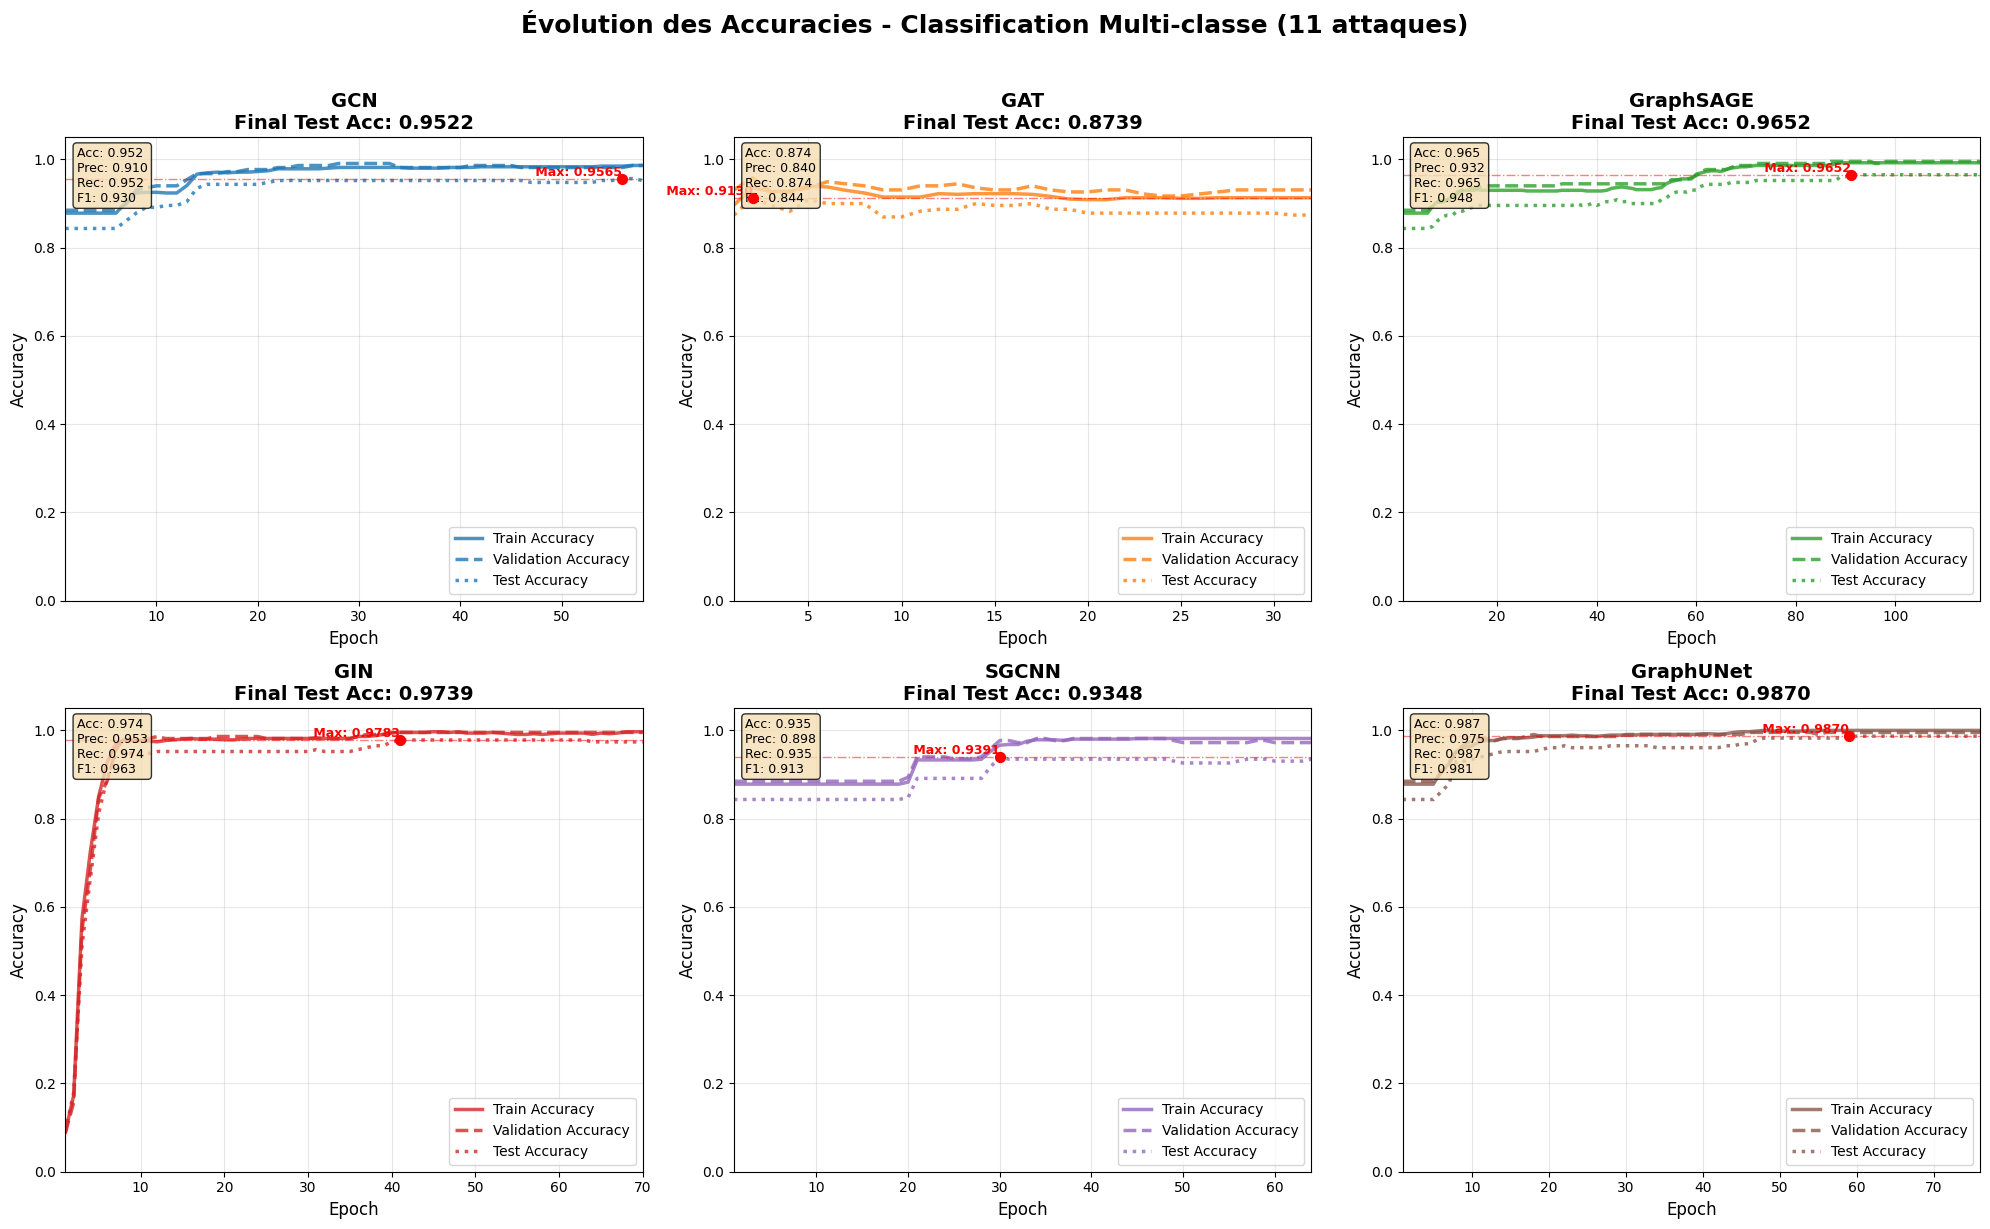

✓ Graphique sauvegardé: multi_class_accuracies_6models.png


In [ ]:
# ============================================================================
# VISUALISATION DES ACCURACIES - 6 MODÈLES (MULTI-CLASSE)
# ============================================================================

print("\n" + "="*80)
print("VISUALISATION DES ACCURACIES - 6 MODÈLES (MULTI-CLASSE)")
print("="*80)

# Créer une figure avec 2x3 subplots pour les 6 modèles
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Évolution des Accuracies - Classification Multi-classe (11 attaques)',
             fontsize=18, fontweight='bold', y=1.02)

# Couleurs pour chaque modèle
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
model_names = list(results_multi.keys())

for idx, (model_name, ax) in enumerate(zip(model_names, axes.flatten())):
    results = results_multi[model_name]

    # Courbes d'accuracy
    epochs = range(1, len(results['train_accs']) + 1)

    ax.plot(epochs, results['train_accs'], label='Train Accuracy',
            color=colors[idx], linewidth=2.5, alpha=0.8)
    ax.plot(epochs, results['val_accs'], label='Validation Accuracy',
            color=colors[idx], linewidth=2.5, alpha=0.8, linestyle='--')
    ax.plot(epochs, results['test_accs'], label='Test Accuracy',
            color=colors[idx], linewidth=2.5, alpha=0.8, linestyle=':')

    # Configuration
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{model_name}\nFinal Test Acc: {results["test_accuracy"]:.4f}',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, len(epochs)])
    ax.set_ylim([0, 1.05])

    # Ajouter une ligne horizontale pour la meilleure accuracy test
    best_test_acc = max(results['test_accs'])
    best_epoch = results['test_accs'].index(best_test_acc) + 1
    ax.axhline(y=best_test_acc, color='red', linestyle='-.', alpha=0.5, linewidth=1)
    ax.scatter(best_epoch, best_test_acc, color='red', s=50, zorder=5)
    ax.text(best_epoch, best_test_acc, f' Max: {best_test_acc:.4f}',
            va='bottom', ha='right', fontsize=9, color='red', fontweight='bold')

    # Ajouter une boîte avec les métriques
    metrics_text = f"Acc: {results['test_accuracy']:.3f}\nPrec: {results['precision']:.3f}\nRec: {results['recall']:.3f}\nF1: {results['f1_score']:.3f}"
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Ajuster l'espacement
plt.tight_layout()
plt.savefig('multi_class_accuracies_6models.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique sauvegardé: multi_class_accuracies_6models.png")


VISUALISATION DES PERTES - 6 MODÈLES (MULTI-CLASSE)


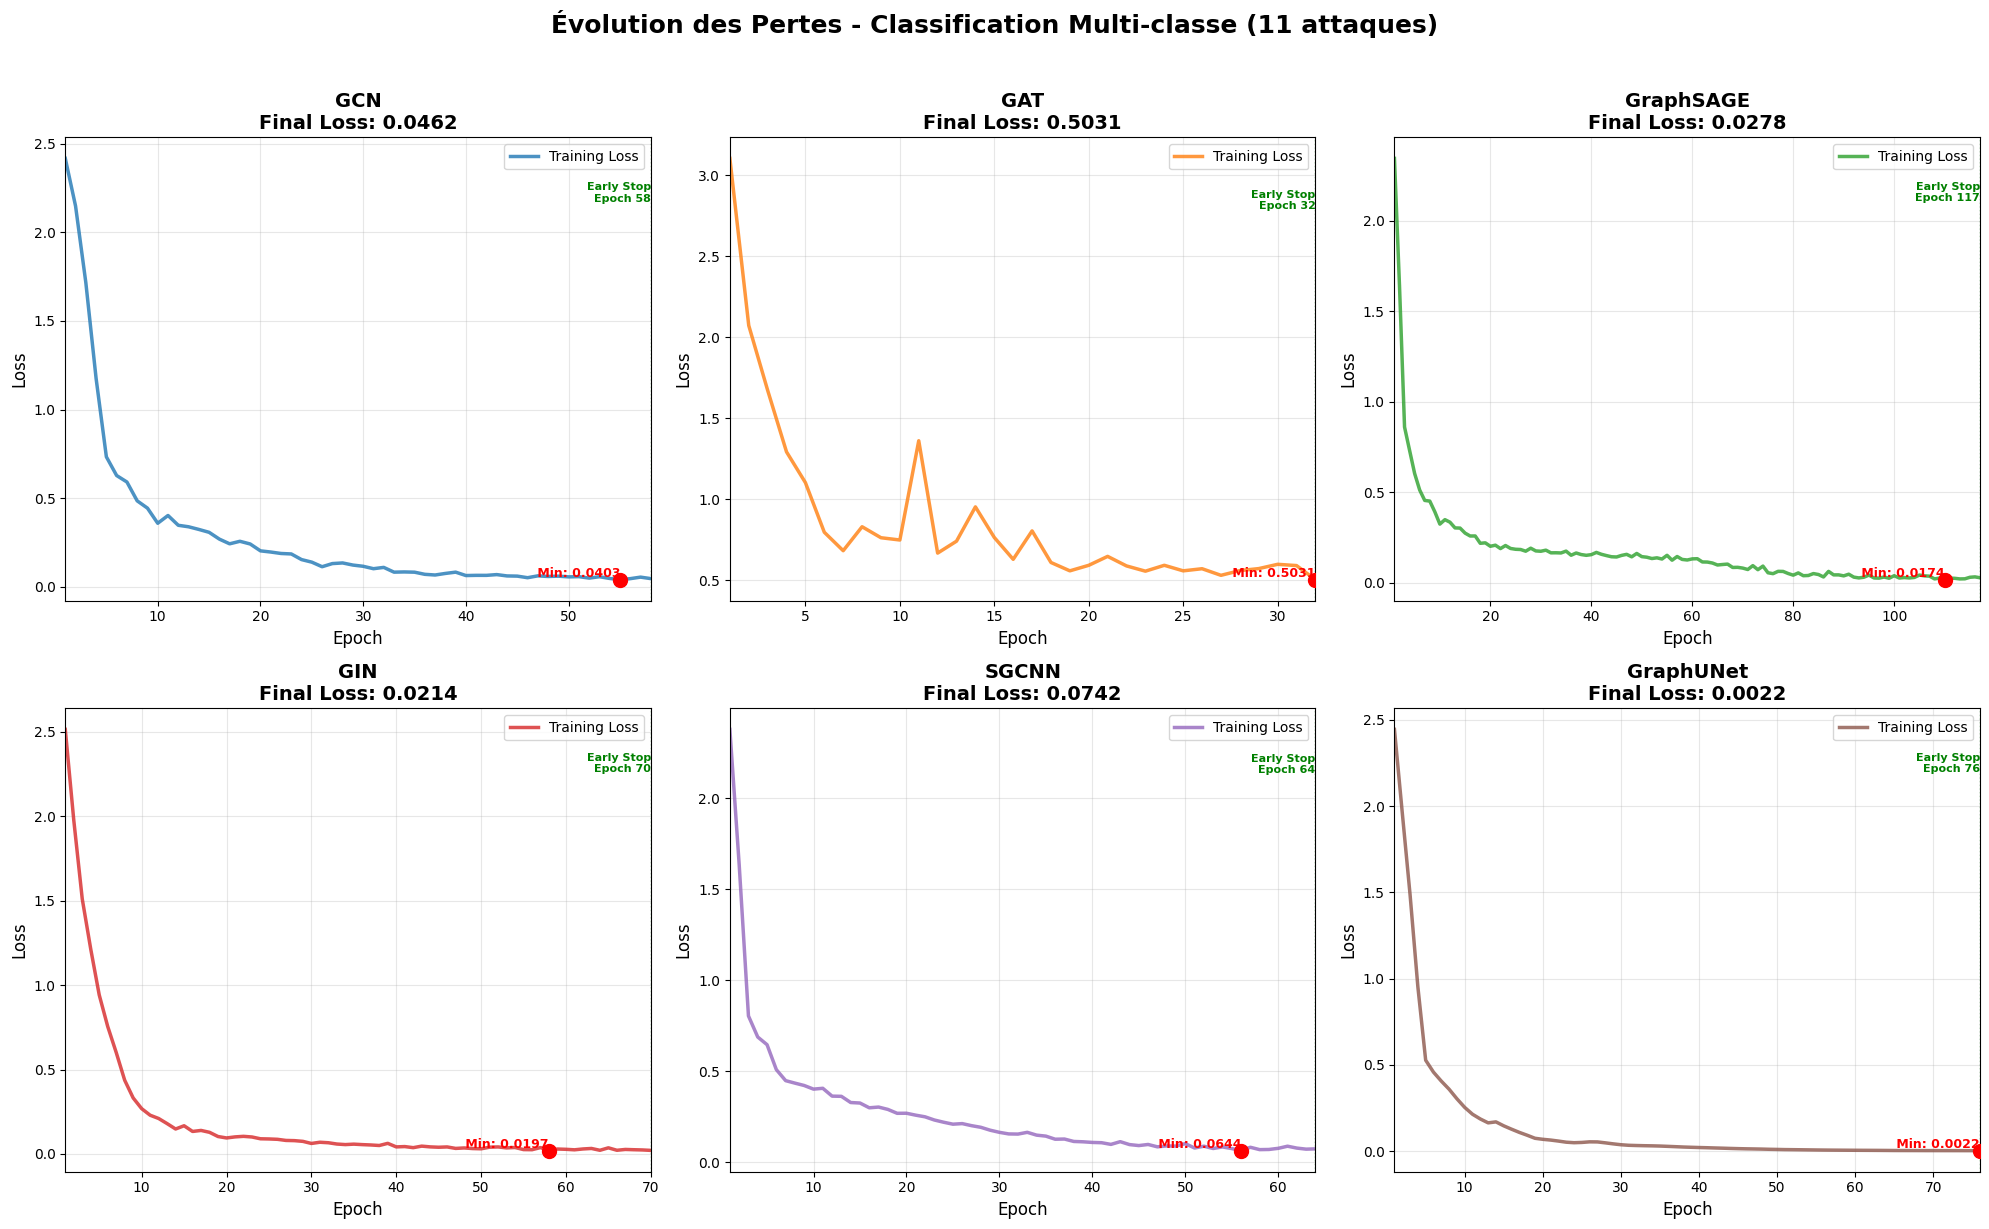

✓ Graphique sauvegardé: multi_class_losses_6models.png


In [ ]:
# ============================================================================
# VISUALISATION DES PERTES - 6 MODÈLES (MULTI-CLASSE)
# ============================================================================

print("\n" + "="*80)
print("VISUALISATION DES PERTES - 6 MODÈLES (MULTI-CLASSE)")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Évolution des Pertes - Classification Multi-classe (11 attaques)',
             fontsize=18, fontweight='bold', y=1.02)

for idx, (model_name, ax) in enumerate(zip(model_names, axes.flatten())):
    results = results_multi[model_name]

    # Courbe de loss
    epochs = range(1, len(results['train_losses']) + 1)

    ax.plot(epochs, results['train_losses'], label='Training Loss',
            color=colors[idx], linewidth=2.5, alpha=0.8)

    # Configuration
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'{model_name}\nFinal Loss: {results["train_losses"][-1]:.4f}',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, len(epochs)])

    # Détection du point minimal
    min_loss = min(results['train_losses'])
    min_epoch = results['train_losses'].index(min_loss) + 1
    ax.scatter(min_epoch, min_loss, color='red', s=100, zorder=5, marker='o')
    ax.text(min_epoch, min_loss, f' Min: {min_loss:.4f}',
            va='bottom', ha='right', fontsize=9, color='red', fontweight='bold')

    # Ajouter une ligne verticale pour l'early stopping
    if len(results['train_losses']) < EPOCHS:
        early_stop_epoch = len(results['train_losses'])
        ax.axvline(x=early_stop_epoch, color='green', linestyle=':', alpha=0.7, linewidth=1)
        ax.text(early_stop_epoch, ax.get_ylim()[1] * 0.9, f'Early Stop\nEpoch {early_stop_epoch}',
                va='top', ha='right', fontsize=8, color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('multi_class_losses_6models.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique sauvegardé: multi_class_losses_6models.png")


VISUALISATION DES ACCURACIES - 6 MODÈLES (BINAIRE)


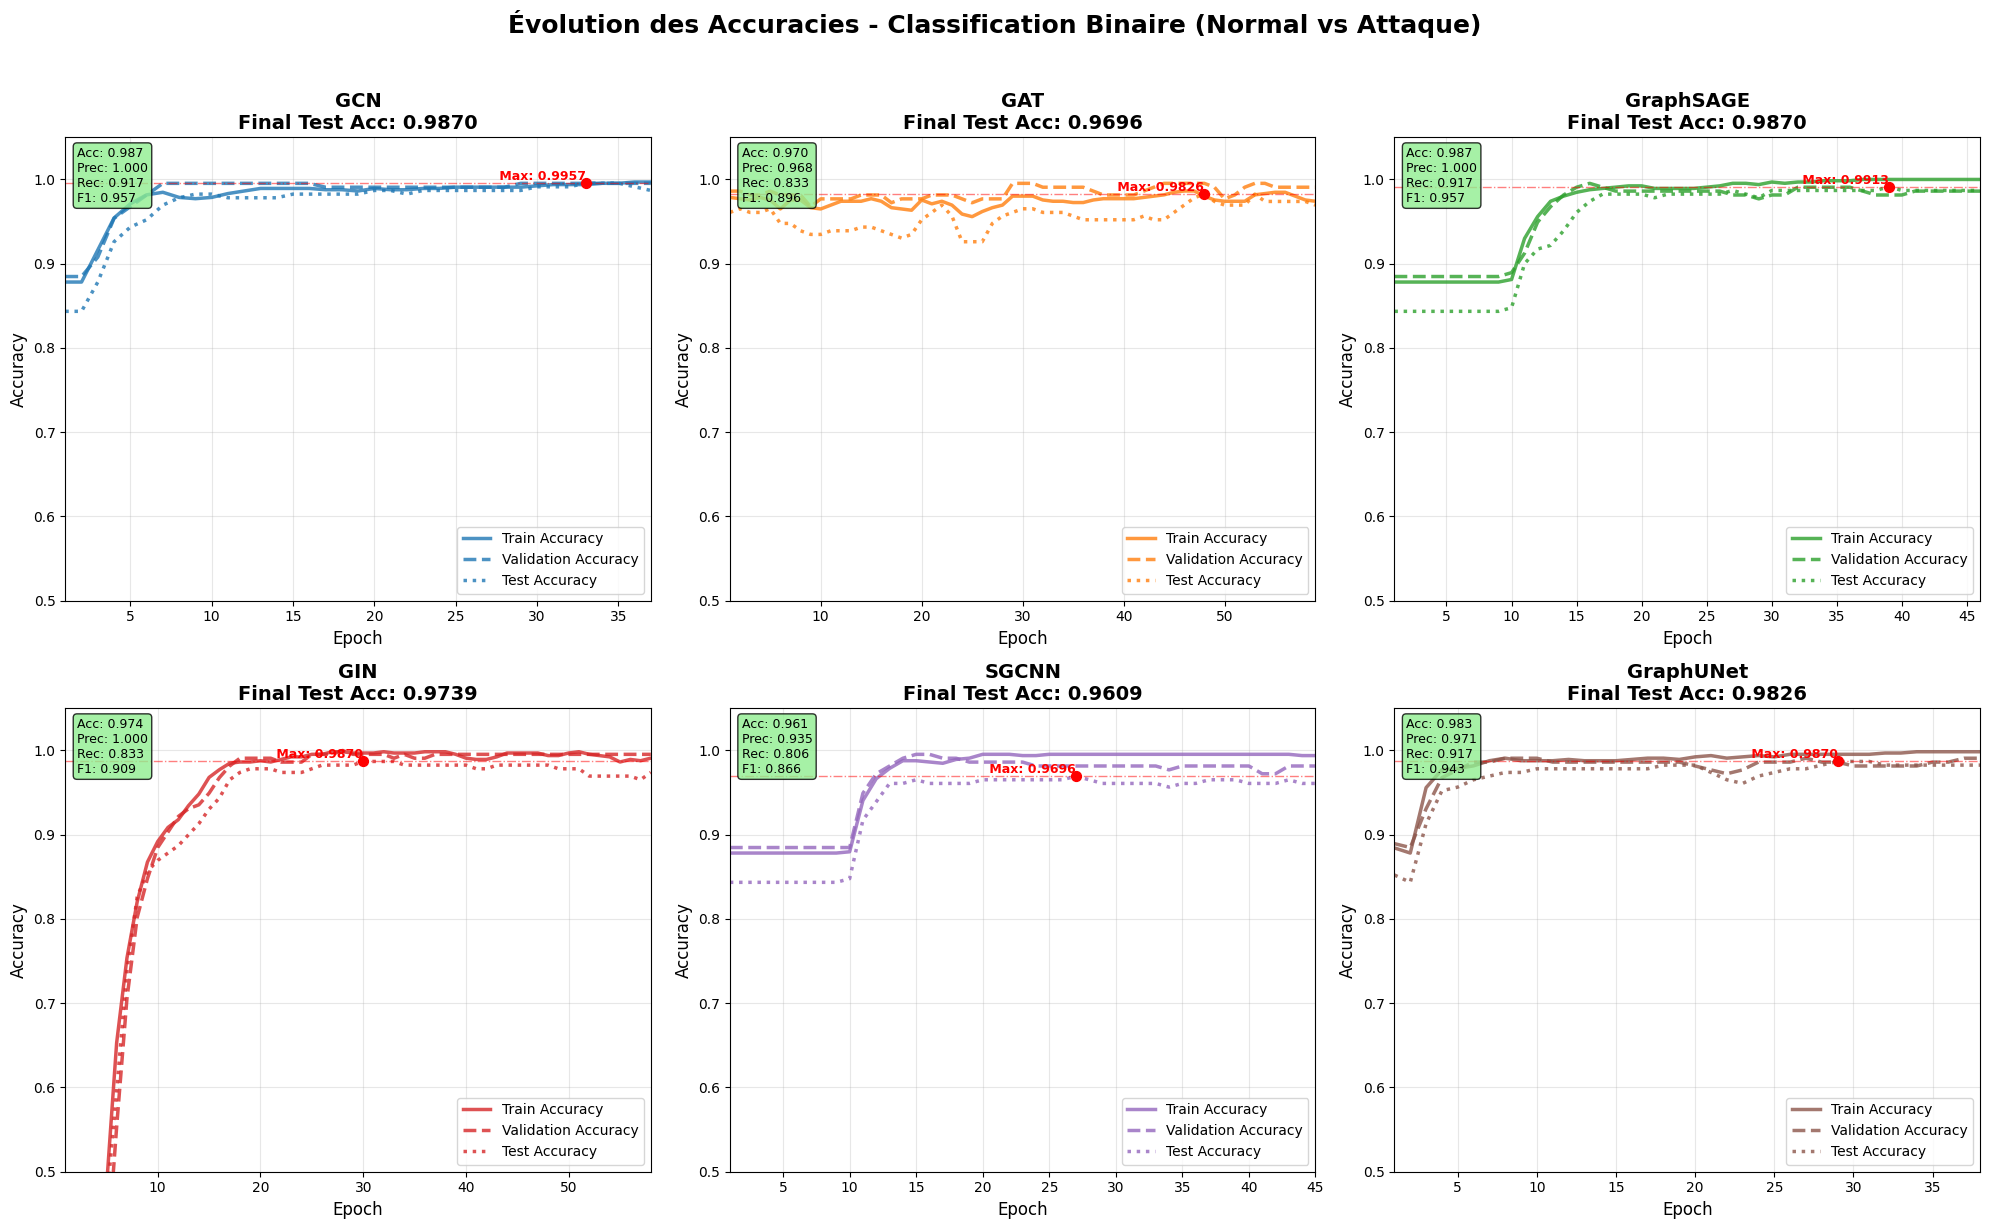

✓ Graphique sauvegardé: binary_accuracies_6models.png


In [ ]:
# ============================================================================
# VISUALISATION BINAIRE - ACCURACIES (6 MODÈLES)
# ============================================================================

print("\n" + "="*80)
print("VISUALISATION DES ACCURACIES - 6 MODÈLES (BINAIRE)")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Évolution des Accuracies - Classification Binaire (Normal vs Attaque)',
             fontsize=18, fontweight='bold', y=1.02)

for idx, (model_name, ax) in enumerate(zip(results_binary.keys(), axes.flatten())):
    results = results_binary[model_name]

    # Courbes d'accuracy
    epochs = range(1, len(results['train_accs']) + 1)

    ax.plot(epochs, results['train_accs'], label='Train Accuracy',
            color=colors[idx], linewidth=2.5, alpha=0.8)
    ax.plot(epochs, results['val_accs'], label='Validation Accuracy',
            color=colors[idx], linewidth=2.5, alpha=0.8, linestyle='--')
    ax.plot(epochs, results['test_accs'], label='Test Accuracy',
            color=colors[idx], linewidth=2.5, alpha=0.8, linestyle=':')

    # Configuration
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'{model_name}\nFinal Test Acc: {results["test_accuracy"]:.4f}',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, len(epochs)])
    ax.set_ylim([0.5, 1.05])  # Ajuster pour binaire

    # Ajouter une ligne horizontale pour la meilleure accuracy test
    best_test_acc = max(results['test_accs'])
    best_epoch = results['test_accs'].index(best_test_acc) + 1
    ax.axhline(y=best_test_acc, color='red', linestyle='-.', alpha=0.5, linewidth=1)
    ax.scatter(best_epoch, best_test_acc, color='red', s=50, zorder=5)
    ax.text(best_epoch, best_test_acc, f' Max: {best_test_acc:.4f}',
            va='bottom', ha='right', fontsize=9, color='red', fontweight='bold')

    # Ajouter une boîte avec les métriques
    metrics_text = f"Acc: {results['test_accuracy']:.3f}\nPrec: {results['precision']:.3f}\nRec: {results['recall']:.3f}\nF1: {results['f1_score']:.3f}"
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('binary_accuracies_6models.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique sauvegardé: binary_accuracies_6models.png")


COMPARAISON FINALE DES 6 MODÈLES

📊 TABLEAU COMPARATIF COMPLET:
------------------------------------------------------------------------------------------------------------------------
   Modèle         Type Test Accuracy Precision Recall F1-Score  Époques
      GCN Multi-classe        0.9522    0.9099 0.9522   0.9298       58
      GCN      Binaire        0.9870    1.0000 0.9167   0.9565       37
      GAT Multi-classe        0.8739    0.8398 0.8739   0.8439       32
      GAT      Binaire        0.9696    0.9677 0.8333   0.8955       59
GraphSAGE Multi-classe        0.9652    0.9318 0.9652   0.9482      117
GraphSAGE      Binaire        0.9870    1.0000 0.9167   0.9565       46
      GIN Multi-classe        0.9739    0.9530 0.9739   0.9631       70
      GIN      Binaire        0.9739    1.0000 0.8333   0.9091       58
    SGCNN Multi-classe        0.9348    0.8976 0.9348   0.9134       64
    SGCNN      Binaire        0.9609    0.9355 0.8056   0.8657       45
GraphUNet Multi-classe

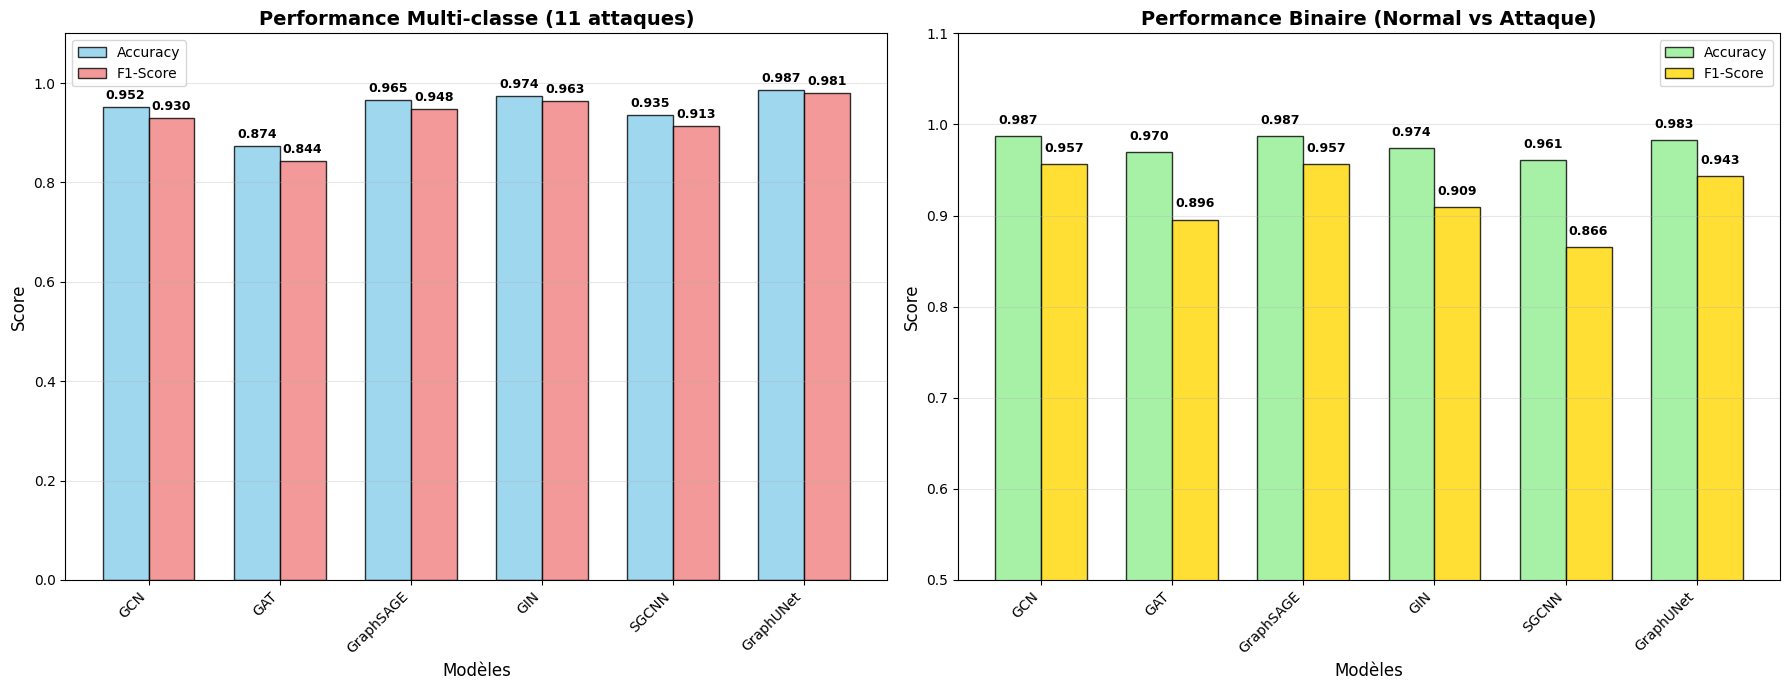

✓ Graphique de comparaison sauvegardé: final_comparison_6models.png


In [ ]:
# ============================================================================
# COMPARAISON FINALE DES 6 MODÈLES
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON FINALE DES 6 MODÈLES")
print("="*80)

# Créer un DataFrame de comparaison
comparison_data = []

for model_name in results_multi.keys():
    # Multi-classe
    multi = results_multi[model_name]
    # Binaire
    binary = results_binary[model_name]

    comparison_data.append({
        'Modèle': model_name,
        'Type': 'Multi-classe',
        'Test Accuracy': f"{multi['test_accuracy']:.4f}",
        'Precision': f"{multi['precision']:.4f}",
        'Recall': f"{multi['recall']:.4f}",
        'F1-Score': f"{multi['f1_score']:.4f}",
        'Époques': len(multi['train_losses'])
    })

    comparison_data.append({
        'Modèle': model_name,
        'Type': 'Binaire',
        'Test Accuracy': f"{binary['test_accuracy']:.4f}",
        'Precision': f"{binary['precision']:.4f}",
        'Recall': f"{binary['recall']:.4f}",
        'F1-Score': f"{binary['f1_score']:.4f}",
        'Époques': len(binary['train_losses'])
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 TABLEAU COMPARATIF COMPLET:")
print("-" * 120)
print(comparison_df.to_string(index=False))

# Graphique de comparaison des performances
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Multi-classe
ax1 = axes[0]
models = list(results_multi.keys())
multi_accs = [results_multi[m]['test_accuracy'] for m in models]
multi_f1 = [results_multi[m]['f1_score'] for m in models]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, multi_accs, width, label='Accuracy', color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, multi_f1, width, label='F1-Score', color='lightcoral', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Modèles', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Performance Multi-classe (11 attaques)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1.1])

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Binaire
ax2 = axes[1]
binary_accs = [results_binary[m]['test_accuracy'] for m in models]
binary_f1 = [results_binary[m]['f1_score'] for m in models]

bars3 = ax2.bar(x - width/2, binary_accs, width, label='Accuracy', color='lightgreen', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, binary_f1, width, label='F1-Score', color='gold', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Modèles', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Performance Binaire (Normal vs Attaque)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0.5, 1.1])

# Ajouter les valeurs sur les barres
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('final_comparison_6models.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique de comparaison sauvegardé: final_comparison_6models.png")


MATRICES DE CONFUSION - 6 MODÈLES (MULTI-CLASSE)


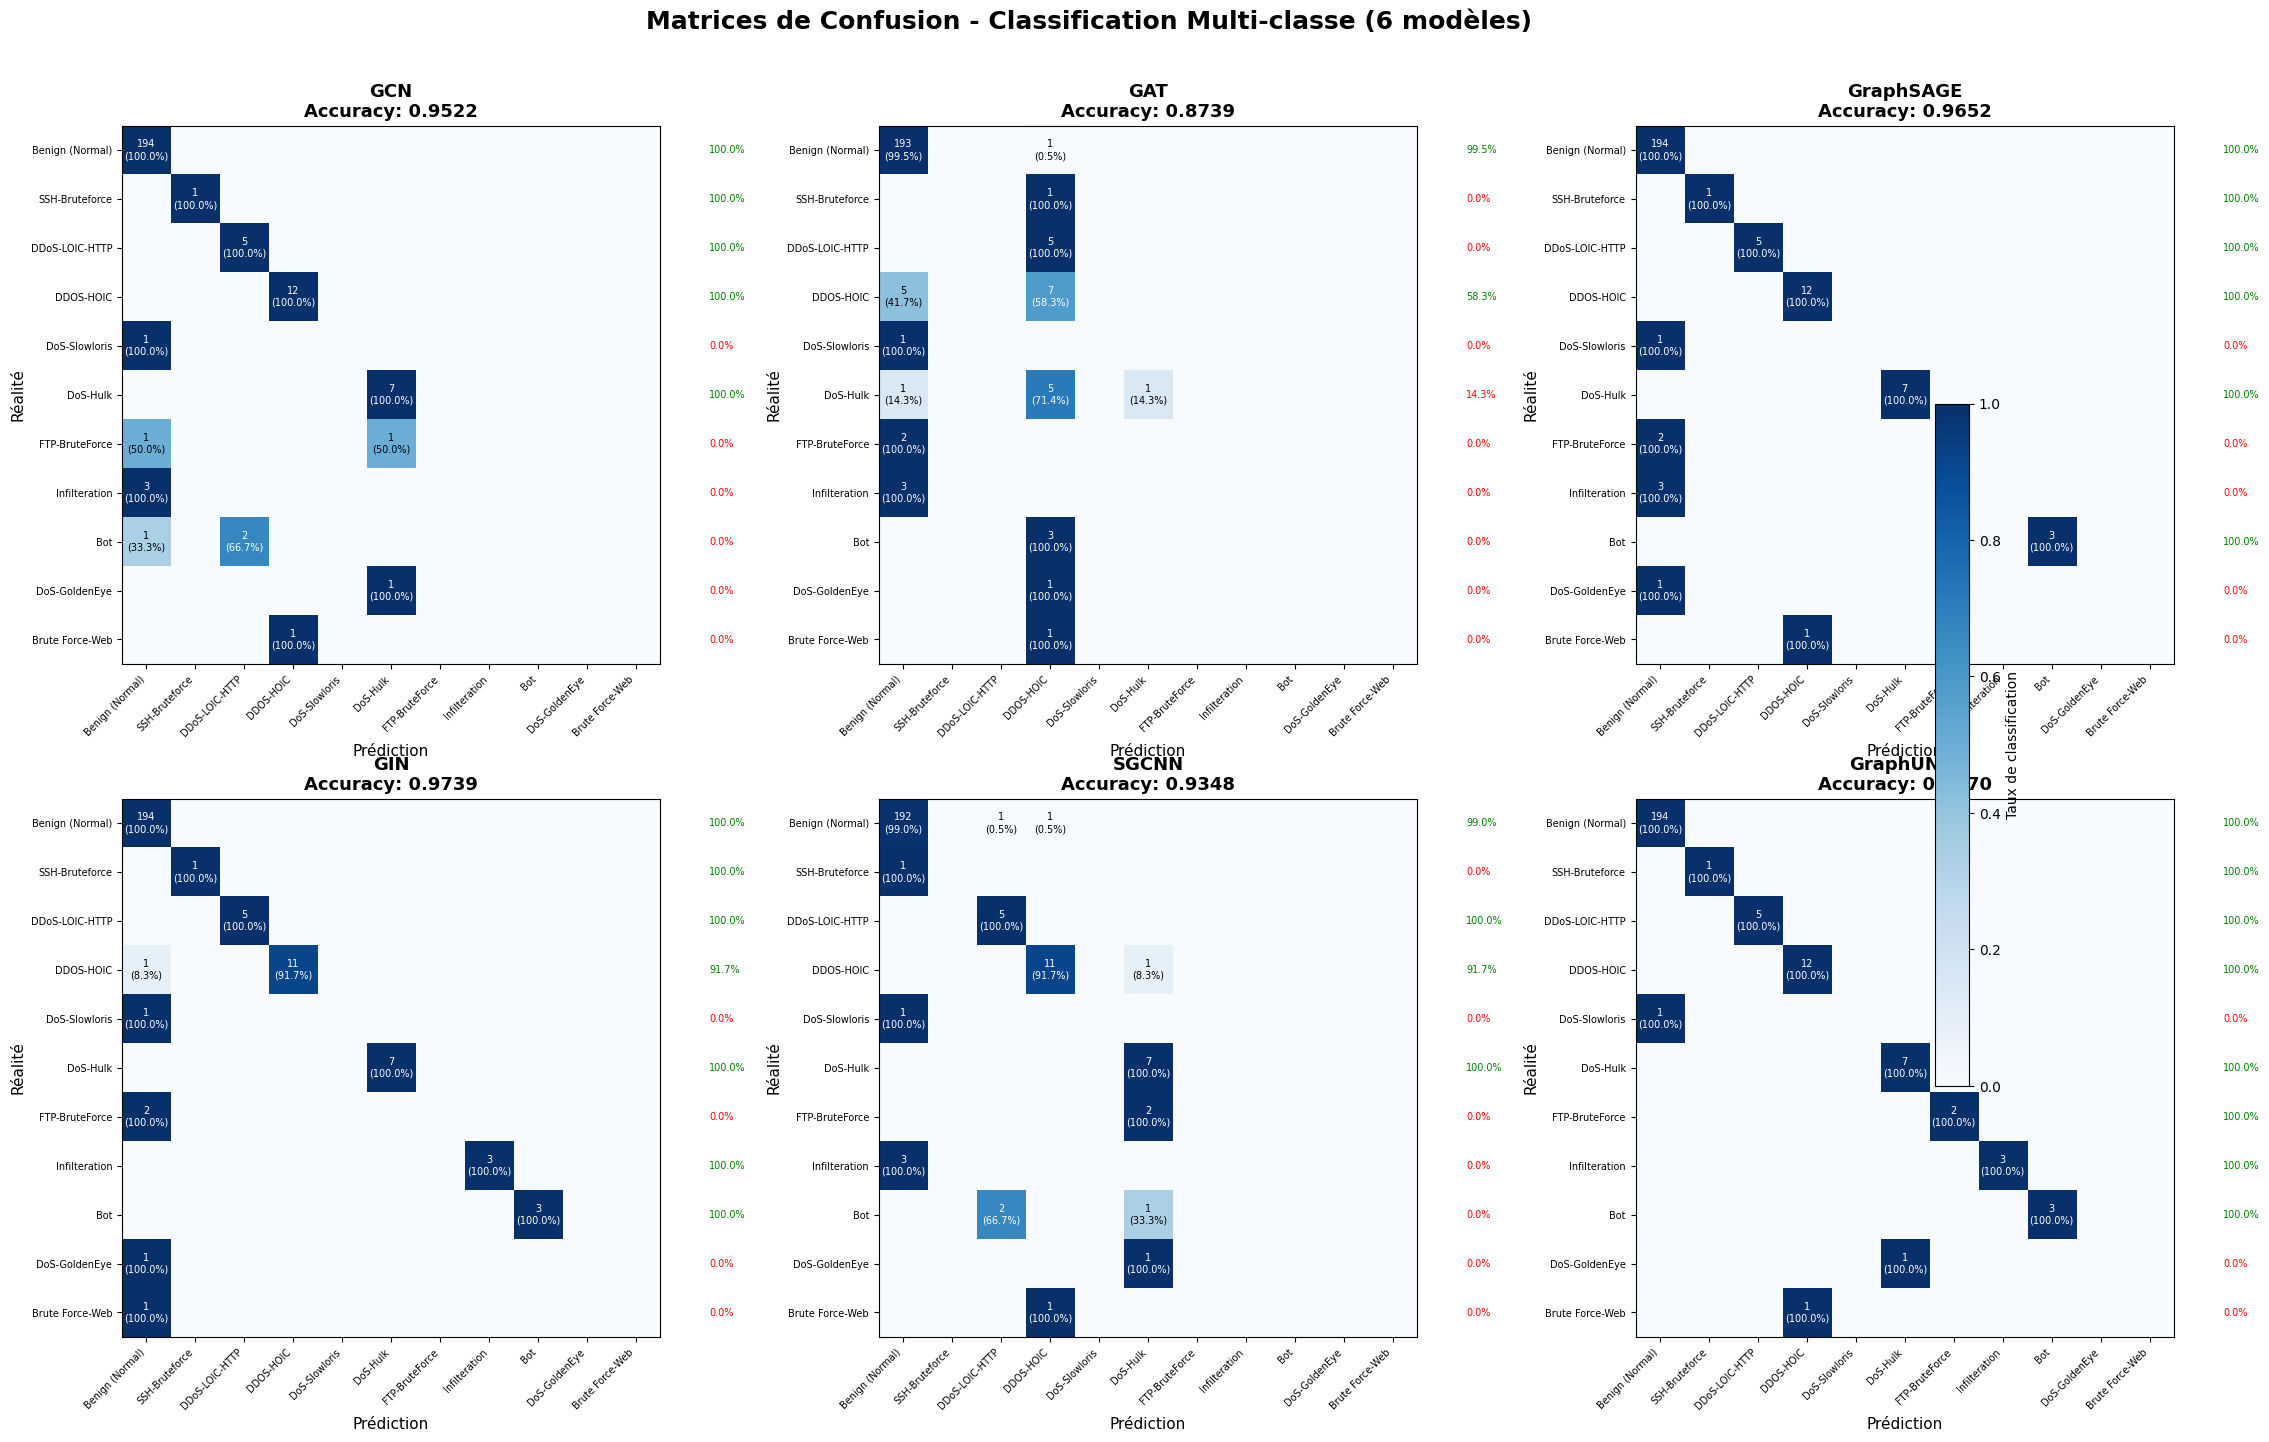

✓ Matrices de confusion sauvegardées: confusion_matrices_6models.png


In [ ]:
# ============================================================================
# MATRICES DE CONFUSION - 6 MODÈLES (MULTI-CLASSE)
# ============================================================================

print("\n" + "="*80)
print("MATRICES DE CONFUSION - 6 MODÈLES (MULTI-CLASSE)")
print("="*80)

# Créer une figure 2x3 pour les 6 matrices de confusion
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('Matrices de Confusion - Classification Multi-classe (6 modèles)',
             fontsize=18, fontweight='bold', y=1.02)

for idx, (model_name, ax) in enumerate(zip(results_multi.keys(), axes.flatten())):
    results = results_multi[model_name]

    # Matrice de confusion
    cm = confusion_matrix(results['y_true'], results['y_pred'])

    # Normalisation par ligne (par classe réelle)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Remplacer NaN par 0

    # Heatmap
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

    # Ajouter les annotations (nombre et pourcentage)
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:  # Afficher seulement si > 0
                ax.text(j, i, f"{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)",
                       ha="center", va="center",
                       color="white" if cm_normalized[i, j] > thresh else "black",
                       fontsize=7)

    ax.set_xlabel('Prédiction', fontsize=11)
    ax.set_ylabel('Réalité', fontsize=11)
    ax.set_title(f'{model_name}\nAccuracy: {results["test_accuracy"]:.4f}',
                 fontsize=13, fontweight='bold')

    # Utiliser les noms d'attaques (limités aux classes présentes)
    classes_present = np.unique(np.concatenate([results['y_true'], results['y_pred']]))
    tick_labels = [ATTACK_NAMES[int(cls)] for cls in classes_present if int(cls) < len(ATTACK_NAMES)]

    ax.set_xticks(range(len(tick_labels)))
    ax.set_yticks(range(len(tick_labels)))
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=7)
    ax.set_yticklabels(tick_labels, fontsize=7)

    # Ajouter un score de précision par classe en marge
    for i, cls in enumerate(classes_present):
        if i < len(classes_present):
            class_accuracy = cm_normalized[i, i] if i < cm_normalized.shape[0] else 0
            ax.text(len(tick_labels) + 0.5, i, f"{class_accuracy*100:.1f}%",
                   ha='left', va='center', fontsize=7, color='green' if class_accuracy > 0.5 else 'red')

# Barre de couleur
plt.colorbar(im, ax=axes, fraction=0.02, pad=0.04, label='Taux de classification')

plt.tight_layout()
plt.savefig('confusion_matrices_6models.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Matrices de confusion sauvegardées: confusion_matrices_6models.png")


ANALYSE COMPARATIVE DÉTAILLÉE

🏆 CLASSEMENT DES MODÈLES (Multi-classe):
----------------------------------------------------------------------
🥇 GraphUNet   : Accuracy = 0.9870 | F1-Score = 0.9807 | Époques =  76
🥈 GIN         : Accuracy = 0.9739 | F1-Score = 0.9631 | Époques =  70
🥉 GraphSAGE   : Accuracy = 0.9652 | F1-Score = 0.9482 | Époques = 117
4️⃣ GCN         : Accuracy = 0.9522 | F1-Score = 0.9298 | Époques =  58
5️⃣ SGCNN       : Accuracy = 0.9348 | F1-Score = 0.9134 | Époques =  64
6️⃣ GAT         : Accuracy = 0.8739 | F1-Score = 0.8439 | Époques =  32

🏆 CLASSEMENT DES MODÈLES (Binaire):
----------------------------------------------------------------------
🥇 GCN         : Accuracy = 0.9870 | F1-Score = 0.9565 | Époques =  37
🥈 GraphSAGE   : Accuracy = 0.9870 | F1-Score = 0.9565 | Époques =  46
🥉 GraphUNet   : Accuracy = 0.9826 | F1-Score = 0.9429 | Époques =  38
4️⃣ GIN         : Accuracy = 0.9739 | F1-Score = 0.9091 | Époques =  58
5️⃣ GAT         : Accuracy = 0.9696 | F1

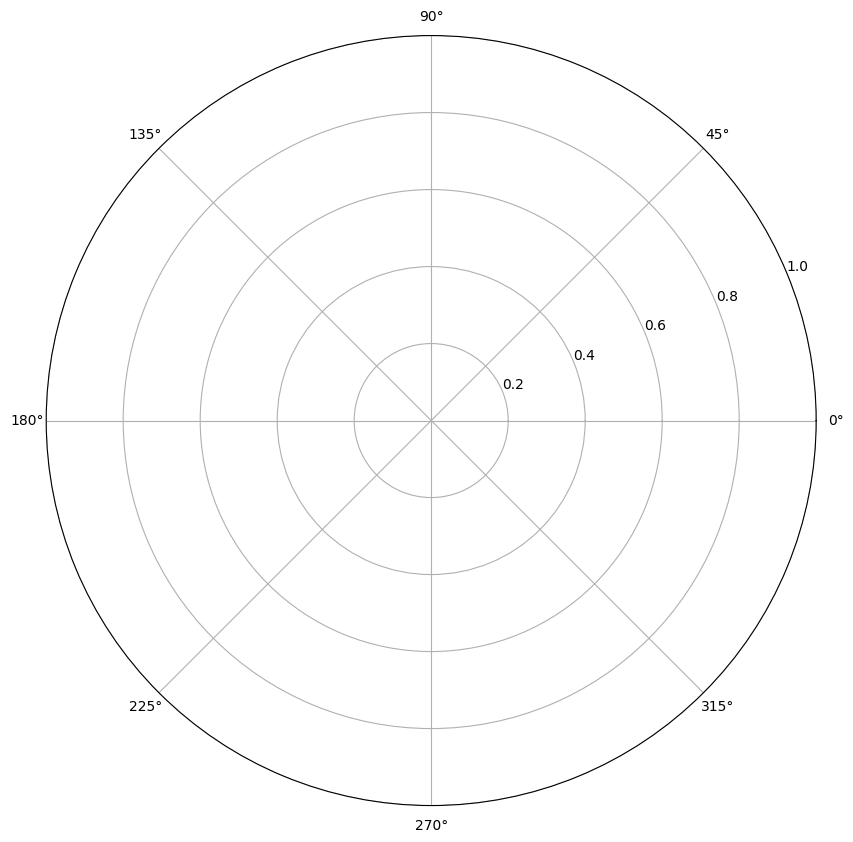

In [ ]:
# ============================================================================
# ANALYSE COMPARATIVE DÉTAILLÉE DES 6 MODÈLES
# ============================================================================

print("\n" + "="*80)
print("ANALYSE COMPARATIVE DÉTAILLÉE")
print("="*80)

# 1. Classement des modèles par performance
print("\n🏆 CLASSEMENT DES MODÈLES (Multi-classe):")
print("-" * 70)

sorted_multi = sorted(results_multi.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
medals = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣', '6️⃣']

for i, (model_name, results) in enumerate(sorted_multi):
    print(f"{medals[i]} {model_name:12s}: Accuracy = {results['test_accuracy']:.4f} | "
          f"F1-Score = {results['f1_score']:.4f} | "
          f"Époques = {len(results['train_losses']):3d}")

print("\n🏆 CLASSEMENT DES MODÈLES (Binaire):")
print("-" * 70)

sorted_binary = sorted(results_binary.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
for i, (model_name, results) in enumerate(sorted_binary):
    print(f"{medals[i]} {model_name:12s}: Accuracy = {results['test_accuracy']:.4f} | "
          f"F1-Score = {results['f1_score']:.4f} | "
          f"Époques = {len(results['train_losses']):3d}")

# 2. Calcul de l'amélioration moyenne
print("\n📈 AMÉLIORATION MOYENNE (Multi-classe → Binaire):")
print("-" * 70)

improvements = []
for model_name in results_multi.keys():
    multi_acc = results_multi[model_name]['test_accuracy']
    binary_acc = results_binary[model_name]['test_accuracy']
    improvement = ((binary_acc - multi_acc) / multi_acc) * 100
    improvements.append(improvement)

    status = "✅" if improvement > 0 else "⚠️"
    print(f"{status} {model_name:12s}: {multi_acc:.4f} → {binary_acc:.4f} (+{improvement:6.2f}%)")

avg_improvement = np.mean(improvements)
print(f"\n📊 Amélioration moyenne: +{avg_improvement:.2f}%")

# 3. Temps de convergence
print("\n⏱️  TEMPS DE CONVERGENCE (époques nécessaires):")
print("-" * 70)

for model_name in results_multi.keys():
    multi_epochs = len(results_multi[model_name]['train_losses'])
    binary_epochs = len(results_binary[model_name]['train_losses'])

    convergence_speed = "Rapide" if multi_epochs < EPOCHS * 0.5 else "Moyen" if multi_epochs < EPOCHS * 0.8 else "Lent"

    print(f"⚡ {model_name:12s}: {multi_epochs:3d} époques (Multi) | "
          f"{binary_epochs:3d} époques (Binaire) | "
          f"Vitesse: {convergence_speed}")

# 4. Graphique radar des performances
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='polar')

# Métriques à comparer
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Stabilité']
n_metrics = len(metrics)

# Angles pour chaque métrique
angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]  # Fermer le cercle

# Préparer les données
models_radar = {}
for model_name in results_multi.keys():
    # Multi-classe
    multi = results_multi[model_name]
    # Calculer un score de stabilité (1 - écart-type des accuracies de

Installation des bibliothèques...
Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
✓ Bibliothèques installées
PyTorch version: 2.9.0+cpu
CUDA disponible: False
Utilisation du CPU
✓ Importations terminées

CHARGEMENT DES DONNEES

EXPLORATION DES DONNÉES
Shape du dataset: (4032, 43)

Premières lignes:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0        40894           22         6      92.0      3164       23       3765   
1        29622         3389         6       0.0      1919       14       2031   
2        65456           53        17       0.0       116        2        148   
3        57918           53        17       0.0        70        1        130   
4        63269           80         6       7.0       232        5       1136   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  TCP_WIN_MAX_IN  \
0        21         27                27  ...           26883   
1     

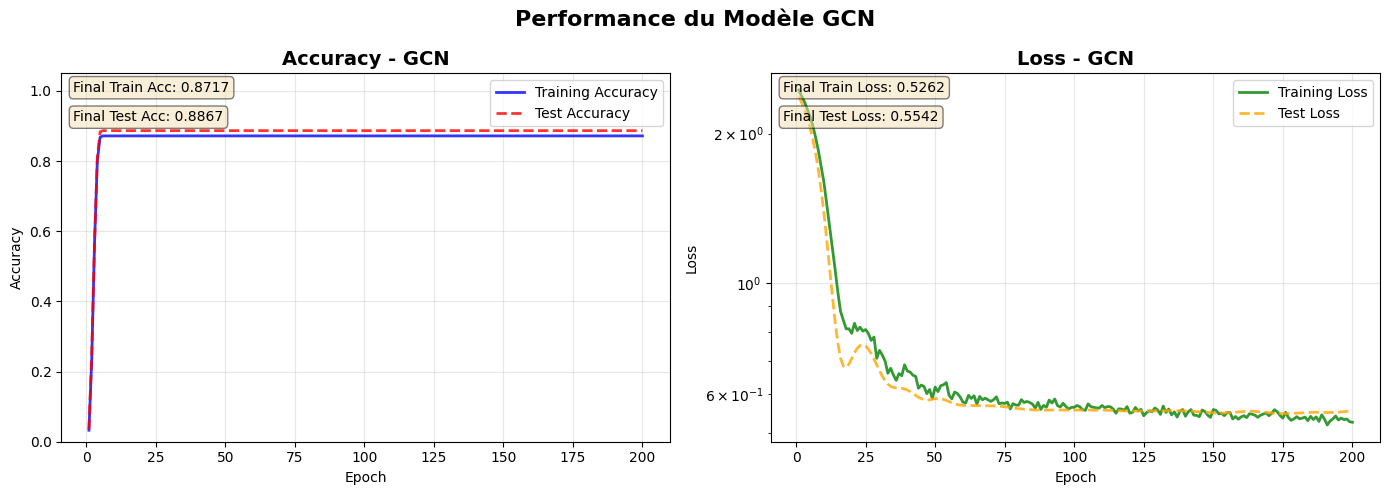

✓ Graphique combiné pour GCN sauvegardé


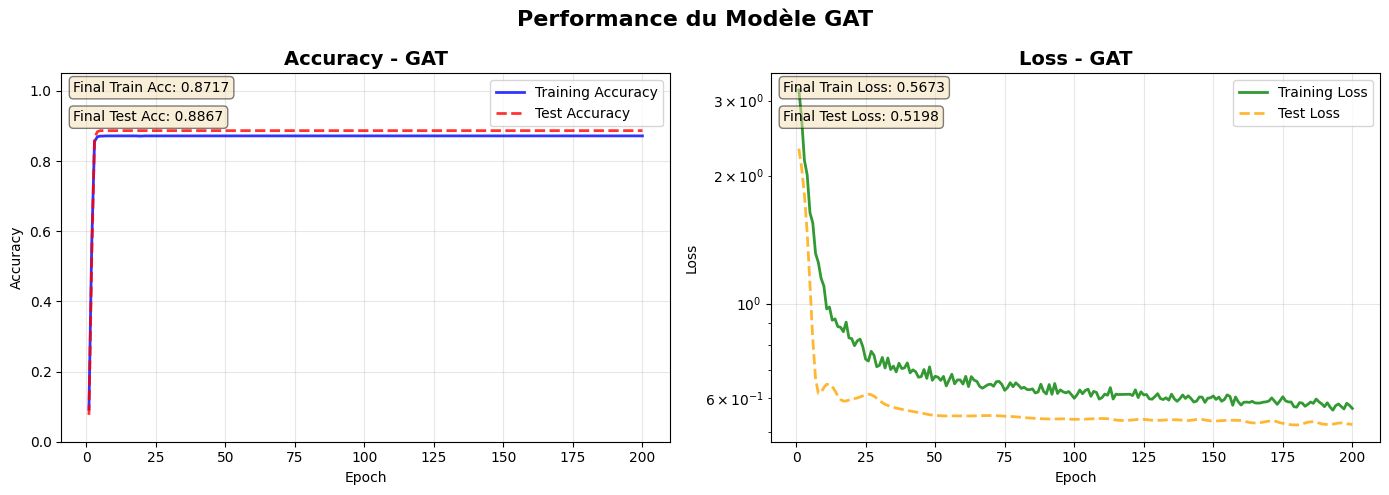

✓ Graphique combiné pour GAT sauvegardé


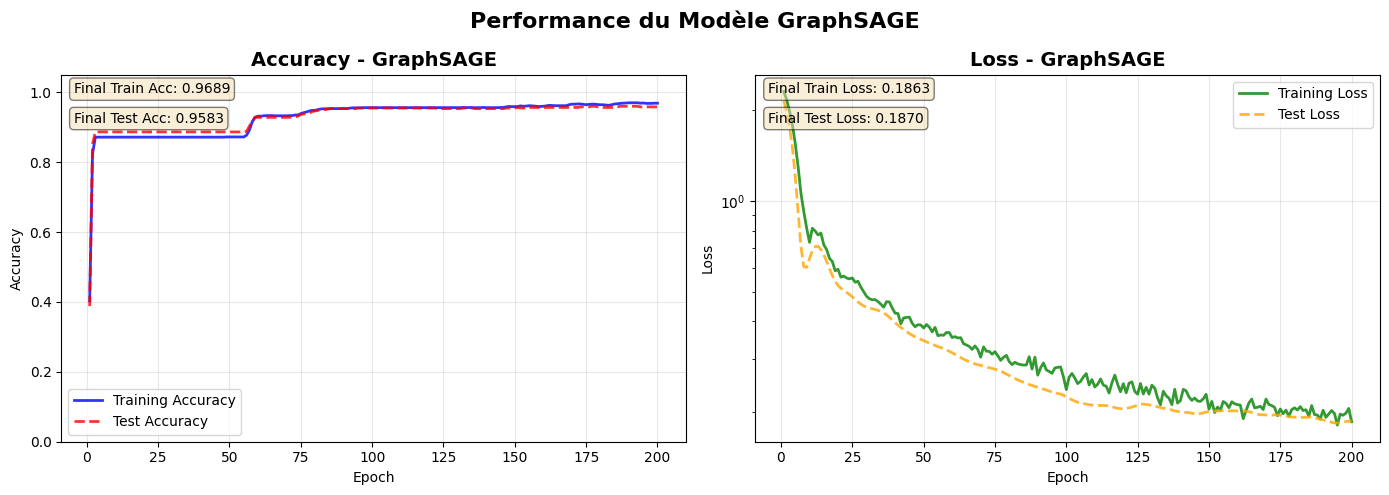

✓ Graphique combiné pour GraphSAGE sauvegardé


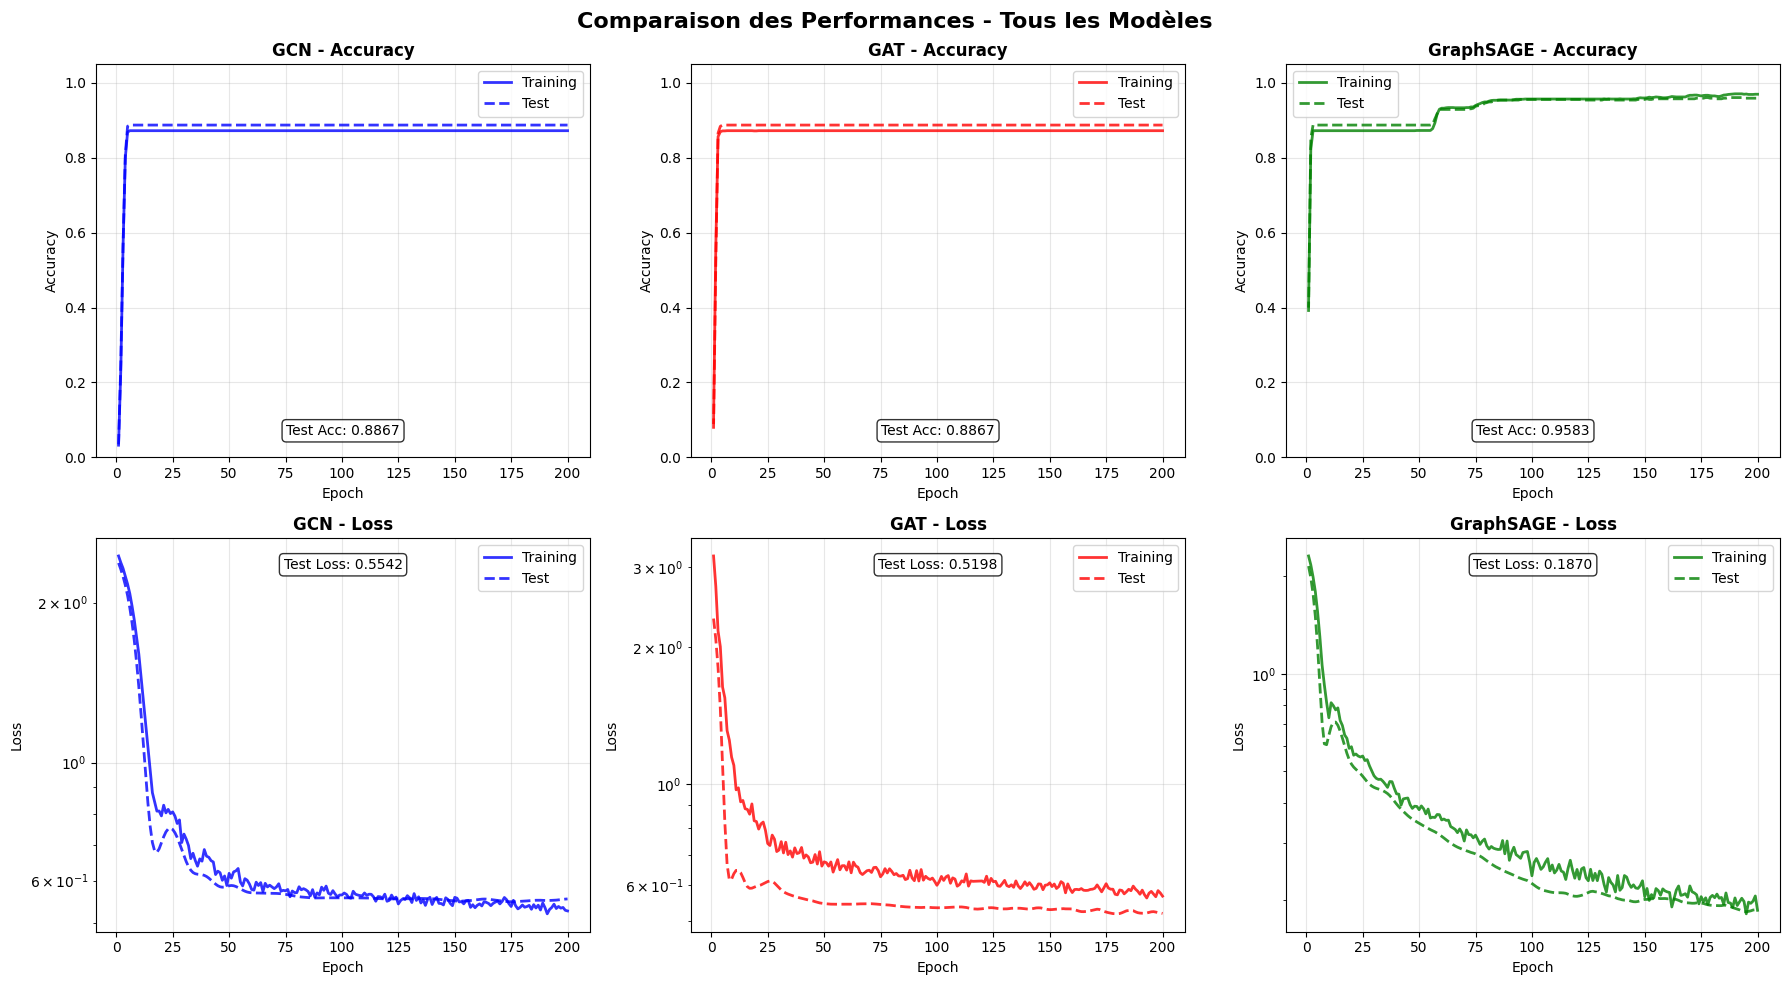

✓ Graphique comparatif de tous les modèles sauvegardé


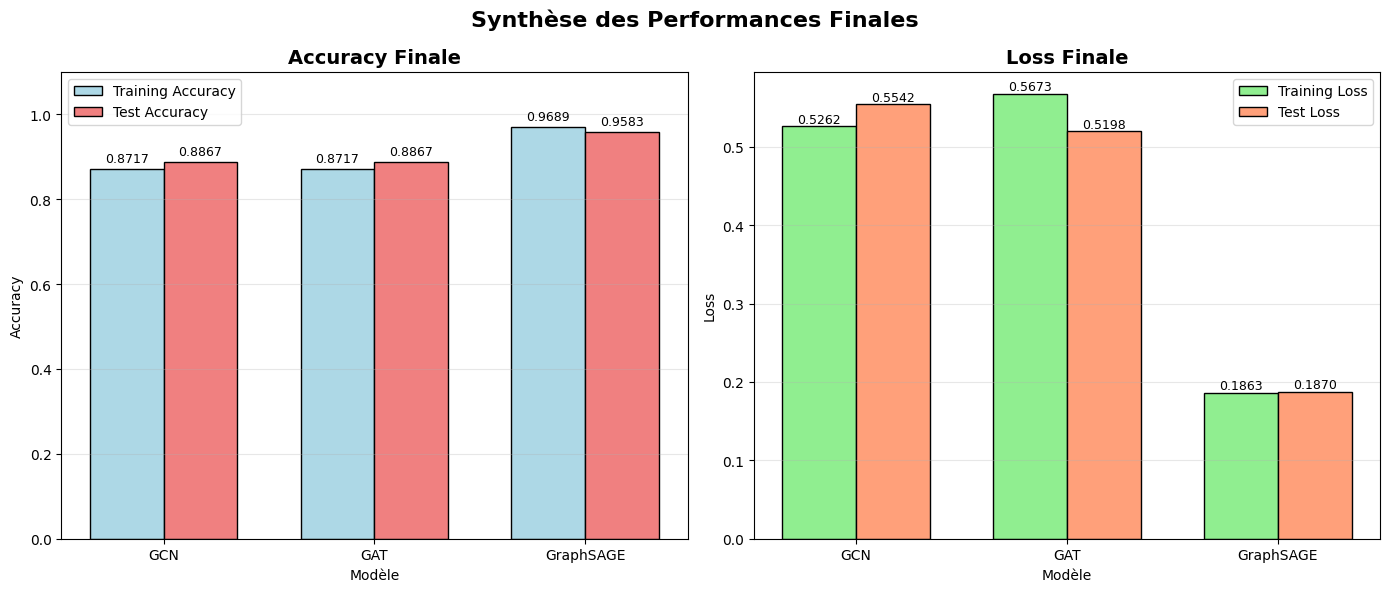

✓ Graphique de synthèse des performances finales sauvegardé


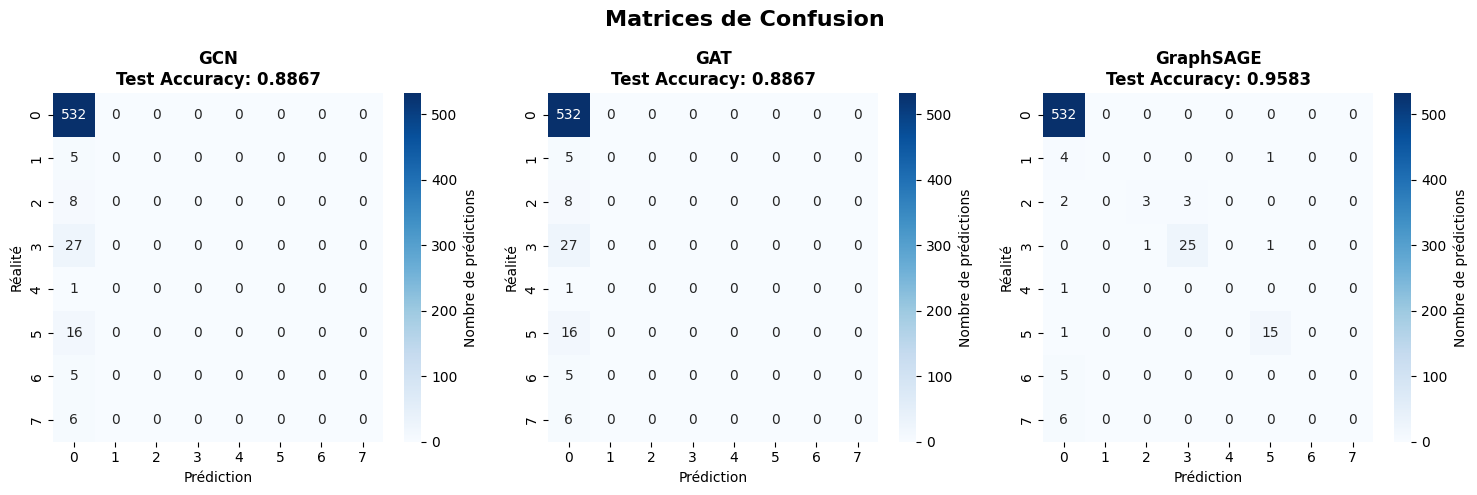

✓ Matrices de confusion sauvegardées

COMPARAISON DES MODÈLES

----------------------------------------------------------------------------------------------------
RÉSULTATS COMPLETS - CLASSIFICATION MULTI-CLASSE
----------------------------------------------------------------------------------------------------
   Modèle Train Loss (final) Test Loss (final) Train Accuracy (final) Test Accuracy (final) Precision Recall F1-Score
      GCN             0.5262            0.5542                 0.8717                0.8867    0.7862 0.8867   0.8334
      GAT             0.5673            0.5198                 0.8717                0.8867    0.7862 0.8867   0.8334
GraphSAGE             0.1863            0.1870                 0.9689                0.9583    0.9298 0.9583   0.9429

--------------------------------------------------------------------------------
MEILLEURES PERFORMANCES
--------------------------------------------------------------------------------
                        Mét

In [ ]:
# ============================================================================
# 1. INSTALLATION DES BIBLIOTHEQUES (Colab spécifique)
# ============================================================================
print("Installation des bibliothèques...")

# Installation des dépendances principales
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric pandas numpy scikit-learn matplotlib seaborn
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("✓ Bibliothèques installées")

# ============================================================================
# 2. IMPORTATION DES BIBLIOTHEQUES
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import os
from google.colab import drive

warnings.filterwarnings('ignore')

# Vérification des versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Utilisation du CPU")

print("✓ Importations terminées")

# ============================================================================
# 3. CHARGEMENT DES DONNEES (Google Colab)
# ============================================================================
print("\n" + "="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)



# Cherchez le fichier dans Drive
df= pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')

# ============================================================================
# 4. EXPLORATION DES DONNEES
# ============================================================================

print("\n" + "="*80)
print("EXPLORATION DES DONNÉES")
print("="*80)
print(f"Shape du dataset: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

# ============================================================================
# 5. ENCODAGE DES LABELS
# ============================================================================

# Mapping des labels d'attaques pour classification multi-classe
label_map = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

# Vérification que la colonne 'Attack' existe
if 'Attack' in df.columns:
    df["Label_id"] = df["Attack"].map(label_map)
    # Remplir les valeurs manquantes (attaques non dans le mapping)
    df["Label_id"].fillna(0, inplace=True)  # Classer comme Benign par défaut
    df["Label_id"] = df["Label_id"].astype(int)
else:
    print("✗ Colonne 'Attack' non trouvée")
    # Créer une colonne Label_id aléatoire pour test
    df["Label_id"] = np.random.randint(0, 11, len(df))

print("\n" + "="*80)
print("DISTRIBUTION DES CLASSES")
print("="*80)

if 'Attack' in df.columns:
    print("\nDistribution détaillée des attaques:")
    print(df["Attack"].value_counts())
else:
    print("\nDistribution des labels (générés):")
    print(df["Label_id"].value_counts())

print(f"\nNombre de classes (multi-classe): {df['Label_id'].nunique()}")

# ============================================================================
# 6. PRÉPARATION DES DONNÉES
# ============================================================================

# Séparation features/labels - UNIQUEMENT multi-classe
y_multiclass = df['Label_id']  # Classification multi-classe uniquement

# Supprimer les colonnes non numériques pour les features
non_numeric_cols = ["Label", "Attack", "Label_id"]
X_cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
X = df.drop(columns=X_cols_to_drop)

# S'assurer que toutes les colonnes sont numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print("\n" + "="*80)
print("PRÉPARATION DES FEATURES")
print("="*80)
print(f"Nombre de features: {X.shape[1]}")
print(f"\nListe des features (premières 10):")
for i, col in enumerate(X.columns[:10], 1):
    print(f"  {i:2d}. {col}")
if len(X.columns) > 10:
    print(f"  ... et {len(X.columns)-10} autres")

# Normalisation des features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(f"\n✓ Features normalisées: {X_scaled.shape}")

# ============================================================================
# 7. CONSTRUCTION DU GRAPHE (Optimisé pour Colab)
# ============================================================================

print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE")
print("="*80)

# Limiter la taille pour éviter les problèmes de mémoire
MAX_NODES = 3000  # Réduit pour Colab
SAMPLE_NODES = min(MAX_NODES, len(X_scaled))

print(f"Échantillonnage à {SAMPLE_NODES} nœuds pour Colab...")
X_scaled = X_scaled.iloc[:SAMPLE_NODES]
y_multiclass = y_multiclass.iloc[:SAMPLE_NODES]

# Node features (toutes les colonnes numériques)
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)

print(f"Nombre de nœuds: {x.shape[0]}")
print(f"Features par nœud: {x.shape[1]}")

# Colonnes pour la construction des arêtes (vérifier qu'elles existent)
edge_cols = []
for col in ["L4_SRC_PORT", "L4_DST_PORT", "PROTOCOL"]:
    if col in X_scaled.columns:
        edge_cols.append(col)

if len(edge_cols) == 0:
    print("✗ Colonnes pour les arêtes non trouvées, utilisation des features principales")
    edge_cols = feature_cols[:3]  # Utiliser les 3 premières features

df_edges = X_scaled[edge_cols].reset_index(drop=True)

# Génération simplifiée des arêtes pour Colab
print("\nGénération des arêtes (version simplifiée pour Colab)...")
edge_list = []

# Utiliser un échantillonnage pour accélérer
for i in range(SAMPLE_NODES):
    if i % 500 == 0:
        print(f"  Progression: {i}/{SAMPLE_NODES} nœuds")

    # Connecter chaque nœud à ses k plus proches voisins
    k = 5  # Nombre de connexions par nœud
    for j in range(i+1, min(i+k+1, SAMPLE_NODES)):
        # Connexion basée sur la similarité des features
        edge_list.append([i, j])
        edge_list.append([j, i])  # Graphe non orienté

# Conversion en tenseur
if edge_list:
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
else:
    # Créer un graphe complètement connecté minimal
    edge_list = [[0, 1], [1, 0]]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

print(f"\n✓ Nombre d'arêtes: {edge_index.shape[1]}")

# Labels
y = torch.tensor(y_multiclass.values, dtype=torch.long)

# Création de l'objet Data PyTorch Geometric
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,  # Multi-classe uniquement
    num_nodes=x.shape[0]
)

# Déplacer sur GPU si disponible
if torch.cuda.is_available():
    data = data.to(device)

print("\n" + "="*80)
print("RÉSUMÉ DU GRAPHE")
print("="*80)
print(data)
print(f"Nombre de nœuds: {data.num_nodes}")
print(f"Nombre d'arêtes: {data.num_edges}")
print(f"Nombre de classes: {len(torch.unique(y))}")

if data.num_edges > 0:
    graph_density = (2 * data.num_edges) / (data.num_nodes * (data.num_nodes - 1))
    print(f"Densité du graphe: {graph_density:.6f}")

# ============================================================================
# 8. CRÉATION DES MASQUES TRAIN/VAL/TEST
# ============================================================================

num_nodes = data.num_nodes
train_ratio = 0.6
val_ratio = 0.2

# Génération d'indices aléatoires
torch.manual_seed(42)  # Pour reproductibilité
indices = torch.randperm(num_nodes)

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

# Création des masques
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Ajout au data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("\n" + "="*80)
print("SPLIT TRAIN/VAL/TEST")
print("="*80)
print(f"Training nodes:   {train_mask.sum():4d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"Validation nodes: {val_mask.sum():4d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"Test nodes:       {test_mask.sum():4d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# ============================================================================
# 9. DÉFINITION DES MODÈLES GNN (Corrigé)
# ============================================================================

# ----------------------
# 9.1 GCN (GRAPH CONVOLUTIONAL NETWORK)
# ----------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 9.2 GAT (GRAPH ATTENTION NETWORK)
# ----------------------
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=4, dropout=0.6):
        super(GAT, self).__init__()

        self.dropout = dropout

        # Première couche GAT
        self.conv1 = GATConv(
            num_features,
            hidden_channels,
            heads=heads,
            dropout=dropout
        )

        # Deuxième couche GAT
        self.conv2 = GATConv(
            hidden_channels * heads,
            hidden_channels,
            heads=1,
            concat=False,
            dropout=dropout
        )

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        # Deuxième couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        # Classification
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.3 GraphSAGE (SAMPLE AND AGGREGATE)
# ----------------------
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()

        self.dropout = dropout

        # Première couche SAGE
        self.conv1 = SAGEConv(num_features, hidden_channels)

        # Deuxième couche SAGE
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche SAGE + activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Deuxième couche SAGE + activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ============================================================================
# 10. FONCTIONS D'ENTRAÎNEMENT ET D'ÉVALUATION
# ============================================================================

def train_gnn(model, data, optimizer, criterion, train_mask):
    """Entraînement pour GNN avec retour du loss"""
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    target = data.y[train_mask]
    loss = criterion(out[train_mask], target)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_gnn(model, data, mask, criterion):
    """Évaluation pour GNN avec retour du loss et de l'accuracy"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        target = data.y[mask]

        # Calcul du loss
        loss = criterion(out[mask], target).item()

        # Calcul de l'accuracy
        correct = pred[mask] == target
        acc = int(correct.sum()) / int(mask.sum())
    return acc, loss, pred[mask], target

# ============================================================================
# 11. FONCTION D'ENTRAÎNEMENT GÉNÉRIQUE AVEC SUIVI COMPLET
# ============================================================================

def train_and_evaluate(model_name, model, data, num_epochs=200, lr=0.01):
    """
    Fonction générique pour entraîner et évaluer les modèles GNN
    avec suivi complet des statistiques
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT DU MODÈLE: {model_name}")
    print("="*80)

    # Déplacer le modèle sur GPU si disponible
    if torch.cuda.is_available():
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique complet
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    # Boucle d'entraînement
    for epoch in range(1, num_epochs + 1):
        # Entraînement
        train_loss = train_gnn(model, data, optimizer, criterion, data.train_mask)
        train_losses.append(train_loss)

        # Évaluation sur train, validation et test
        train_acc, train_loss_val, _, _ = evaluate_gnn(model, data, data.train_mask, criterion)
        val_acc, val_loss, _, _ = evaluate_gnn(model, data, data.val_mask, criterion)
        test_acc, test_loss, _, _ = evaluate_gnn(model, data, data.test_mask, criterion)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

    # Évaluation finale
    print("\n" + "-"*80)
    print("RÉSULTATS FINAUX")
    print("-"*80)

    test_acc, test_loss, y_pred, y_true = evaluate_gnn(model, data, data.test_mask, criterion)

    # Calcul des métriques finales
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    # Statistiques de loss finales
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    final_test_loss = test_loss

    print(f"Train Loss (final):    {final_train_loss:.4f}")
    print(f"Validation Loss (final): {final_val_loss:.4f}")
    print(f"Test Loss (final):     {final_test_loss:.4f}")
    print(f"Train Accuracy (final): {train_accs[-1]:.4f}")
    print(f"Validation Accuracy (final): {val_accs[-1]:.4f}")
    print(f"Test Accuracy (final):  {test_acc:.4f}")
    print(f"Precision:             {precision:.4f}")
    print(f"Recall:                {recall:.4f}")
    print(f"F1-Score:              {f1:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_true_np, y_pred_np)

    # Rapport de classification détaillé
    print("\n" + "-"*80)
    print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
    print("-"*80)
    target_names = [f'Class_{i}' for i in range(len(np.unique(y_true_np)))]
    print(classification_report(y_true_np, y_pred_np, target_names=target_names))

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'final_test_loss': final_test_loss,
        'test_accuracy': test_acc,
        'train_accuracy': train_accs[-1],
        'val_accuracy': val_accs[-1],
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# ============================================================================
# 12. EXÉCUTION DES EXPÉRIENCES (MULTI-CLASSE UNIQUEMENT)
# ============================================================================

print("\n" + "="*80)
print("DÉBUT DES EXPÉRIMENTATIONS - CLASSIFICATION MULTI-CLASSE")
print("="*80)

# Stockage des résultats
results = {}

# Liste des modèles GNN à tester
gnn_models = ['GCN', 'GAT', 'GraphSAGE']

num_classes = int(data.y.unique().size(0))
print(f"\nNombre de classes: {num_classes}")
print(f"Nombre de features: {data.num_features}")

# Réduction du nombre d'epochs pour Colab
num_epochs_colab = 200

# GCN Multi-classe
print("\n" + "-"*80)
gcn_model = GCN(data.num_features, hidden_channels=16, num_classes=num_classes)
results['GCN'] = train_and_evaluate('GCN', gcn_model, data, num_epochs=num_epochs_colab)

# GAT Multi-classe
print("\n" + "-"*80)
gat_model = GAT(data.num_features, hidden_channels=16, num_classes=num_classes, heads=4, dropout=0.5)
results['GAT'] = train_and_evaluate('GAT', gat_model, data, num_epochs=num_epochs_colab)

# GraphSAGE Multi-classe
print("\n" + "-"*80)
sage_model = GraphSAGE(data.num_features, hidden_channels=16, num_classes=num_classes, dropout=0.5)
results['GraphSAGE'] = train_and_evaluate('GraphSAGE', sage_model, data, num_epochs=num_epochs_colab)

# ============================================================================
# 13. VISUALISATION DES RÉSULTATS - GRAPHIQUES COMBINÉS
# ============================================================================

print("\n" + "="*80)
print("GÉNÉRATION DES GRAPHIQUES COMBINÉS")
print("="*80)

# ================================
# 13.1 Graphiques combinés pour chaque modèle
# ================================

for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]

        # Créer une figure avec 2 sous-graphiques
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Performance du Modèle {model_name}', fontsize=16, fontweight='bold')

        epochs = range(1, len(r['train_losses']) + 1)

        # Graphique 1: Training vs Test Accuracy
        ax1.plot(epochs, r['train_accs'], label='Training Accuracy',
                 color='blue', linewidth=2, alpha=0.8)
        ax1.plot(epochs, r['test_accs'], label='Test Accuracy',
                 color='red', linewidth=2, alpha=0.8, linestyle='--')

        ax1.set_title(f'Accuracy - {model_name}', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='best')
        ax1.set_ylim([0, 1.05])

        # Ajouter les valeurs finales
        final_train_acc = r['train_accs'][-1]
        final_test_acc = r['test_accs'][-1]
        ax1.text(0.02, 0.98, f'Final Train Acc: {final_train_acc:.4f}',
                 transform=ax1.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax1.text(0.02, 0.90, f'Final Test Acc: {final_test_acc:.4f}',
                 transform=ax1.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Graphique 2: Training vs Test Loss
        ax2.plot(epochs, r['train_losses'], label='Training Loss',
                 color='green', linewidth=2, alpha=0.8)
        ax2.plot(epochs, r['test_losses'], label='Test Loss',
                 color='orange', linewidth=2, alpha=0.8, linestyle='--')

        ax2.set_title(f'Loss - {model_name}', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='best')
        ax2.set_yscale('log')  # Échelle log pour mieux visualiser

        # Ajouter les valeurs finales
        final_train_loss = r['train_losses'][-1]
        final_test_loss = r['test_losses'][-1]
        ax2.text(0.02, 0.98, f'Final Train Loss: {final_train_loss:.4f}',
                 transform=ax2.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax2.text(0.02, 0.90, f'Final Test Loss: {final_test_loss:.4f}',
                 transform=ax2.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig(f'combined_performance_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Graphique combiné pour {model_name} sauvegardé")

# ================================
# 13.2 Graphique comparatif de tous les modèles
# ================================

# Créer une figure avec 2x3 sous-graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des Performances - Tous les Modèles', fontsize=16, fontweight='bold')

colors = {'GCN': 'blue', 'GAT': 'red', 'GraphSAGE': 'green'}

for idx, model_name in enumerate(gnn_models):
    if model_name in results:
        r = results[model_name]
        epochs = range(1, len(r['train_losses']) + 1)

        # Ligne 1: Accuracy comparée
        axes[0, idx].plot(epochs, r['train_accs'], label='Training',
                          color=colors[model_name], linewidth=2, alpha=0.8)
        axes[0, idx].plot(epochs, r['test_accs'], label='Test',
                          color=colors[model_name], linewidth=2, alpha=0.8, linestyle='--')

        axes[0, idx].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
        axes[0, idx].set_xlabel('Epoch')
        axes[0, idx].set_ylabel('Accuracy')
        axes[0, idx].grid(True, alpha=0.3)
        axes[0, idx].legend()
        axes[0, idx].set_ylim([0, 1.05])

        # Ajouter les valeurs finales
        final_test_acc = r['test_accs'][-1]
        axes[0, idx].text(0.5, 0.05, f'Test Acc: {final_test_acc:.4f}',
                         transform=axes[0, idx].transAxes, fontsize=10,
                         horizontalalignment='center', verticalalignment='bottom',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Ligne 2: Loss comparée
        axes[1, idx].plot(epochs, r['train_losses'], label='Training',
                          color=colors[model_name], linewidth=2, alpha=0.8)
        axes[1, idx].plot(epochs, r['test_losses'], label='Test',
                          color=colors[model_name], linewidth=2, alpha=0.8, linestyle='--')

        axes[1, idx].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
        axes[1, idx].set_xlabel('Epoch')
        axes[1, idx].set_ylabel('Loss')
        axes[1, idx].grid(True, alpha=0.3)
        axes[1, idx].legend()
        axes[1, idx].set_yscale('log')

        # Ajouter les valeurs finales
        final_test_loss = r['test_losses'][-1]
        axes[1, idx].text(0.5, 0.95, f'Test Loss: {final_test_loss:.4f}',
                         transform=axes[1, idx].transAxes, fontsize=10,
                         horizontalalignment='center', verticalalignment='top',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('comparison_all_models_combined.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique comparatif de tous les modèles sauvegardé")

# ================================
# 13.3 Graphique synthèse des performances finales
# ================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Synthèse des Performances Finales', fontsize=16, fontweight='bold')

# Données pour les graphiques
models_with_results = [m for m in gnn_models if m in results]

if models_with_results:
    # Graphique 1: Test Accuracy finale
    test_accs = [results[m]['test_accuracy'] for m in models_with_results]
    train_accs = [results[m]['train_accuracy'] for m in models_with_results]

    x = np.arange(len(models_with_results))
    width = 0.35

    bars1 = ax1.bar(x - width/2, train_accs, width, label='Training Accuracy',
                   color='lightblue', edgecolor='black')
    bars2 = ax1.bar(x + width/2, test_accs, width, label='Test Accuracy',
                   color='lightcoral', edgecolor='black')

    ax1.set_title('Accuracy Finale', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Modèle')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_with_results)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1.1])

    # Ajouter les valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    # Graphique 2: Test Loss finale
    test_losses = [results[m]['final_test_loss'] for m in models_with_results]
    train_losses = [results[m]['final_train_loss'] for m in models_with_results]

    bars3 = ax2.bar(x - width/2, train_losses, width, label='Training Loss',
                   color='lightgreen', edgecolor='black')
    bars4 = ax2.bar(x + width/2, test_losses, width, label='Test Loss',
                   color='lightsalmon', edgecolor='black')

    ax2.set_title('Loss Finale', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Modèle')
    ax2.set_ylabel('Loss')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_with_results)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('final_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique de synthèse des performances finales sauvegardé")

# ================================
# 13.4 Matrices de confusion pour chaque modèle
# ================================

if len(models_with_results) > 0:
    fig, axes = plt.subplots(1, len(models_with_results), figsize=(5*len(models_with_results), 5))
    if len(models_with_results) == 1:
        axes = [axes]

    fig.suptitle('Matrices de Confusion', fontsize=16, fontweight='bold')

    for idx, model_name in enumerate(models_with_results):
        r = results[model_name]

        # Créer la heatmap
        sns.heatmap(r['confusion_matrix'],
                    annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    cbar=True, cbar_kws={'label': 'Nombre de prédictions'})

        axes[idx].set_title(f'{model_name}\nTest Accuracy: {r["test_accuracy"]:.4f}', fontweight='bold')
        axes[idx].set_xlabel('Prédiction')
        axes[idx].set_ylabel('Réalité')

    plt.tight_layout()
    plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Matrices de confusion sauvegardées")

# ============================================================================
# 14. COMPARAISON ET ANALYSE DES RÉSULTATS
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON DES MODÈLES")
print("="*80)

# ----------------------
# 14.1 Tableau complet des résultats
# ----------------------
print("\n" + "-"*100)
print("RÉSULTATS COMPLETS - CLASSIFICATION MULTI-CLASSE")
print("-"*100)

comparison_data = []
for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]
        comparison_data.append({
            'Modèle': model_name,
            'Train Loss (final)': f"{r['final_train_loss']:.4f}",
            'Test Loss (final)': f"{r['final_test_loss']:.4f}",
            'Train Accuracy (final)': f"{r['train_accuracy']:.4f}",
            'Test Accuracy (final)': f"{r['test_accuracy']:.4f}",
            'Precision': f"{r['precision']:.4f}",
            'Recall': f"{r['recall']:.4f}",
            'F1-Score': f"{r['f1_score']:.4f}"
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
else:
    print("Aucun résultat disponible")

# ----------------------
# 14.2 Tableau synthétique des meilleures performances
# ----------------------
print("\n" + "-"*80)
print("MEILLEURES PERFORMANCES")
print("-"*80)

if models_with_results:
    # Trouver le meilleur modèle pour chaque métrique
    best_accuracy = max(models_with_results, key=lambda m: results[m]['test_accuracy'])
    best_f1 = max(models_with_results, key=lambda m: results[m]['f1_score'])
    best_loss = min(models_with_results, key=lambda m: results[m]['final_test_loss'])

    summary_data = [
        ('Meilleure Test Accuracy', best_accuracy, results[best_accuracy]['test_accuracy']),
        ('Meilleur F1-Score', best_f1, results[best_f1]['f1_score']),
        ('Meilleure Test Loss (plus basse)', best_loss, results[best_loss]['final_test_loss'])
    ]

    summary_df = pd.DataFrame(summary_data, columns=['Métrique', 'Modèle', 'Valeur'])
    print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
else:
    print("Aucun modèle n'a terminé l'entraînement avec succès.")

# ============================================================================
# 15. SAUVEGARDE DES RÉSULTATS SUR DRIVE
# ============================================================================

print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS")
print("="*80)

# Créer un dossier pour les résultats
results_dir = '/content/drive/MyDrive/GNN_Results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Sauvegarde du tableau comparatif
if comparison_data:
    comparison_path = os.path.join(results_dir, 'results_comparison.csv')
    comparison_df.to_csv(comparison_path, index=False)
    print(f"✓ Résultats comparatifs sauvegardés dans '{comparison_path}'")

# Sauvegarde des historiques d'entraînement pour chaque modèle
for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]

        history_df = pd.DataFrame({
            'epoch': range(1, len(r['train_losses']) + 1),
            'train_loss': r['train_losses'],
            'test_loss': r['test_losses'],
            'train_acc': r['train_accs'],
            'test_acc': r['test_accs']
        })

        history_path = os.path.join(results_dir, f'training_history_{model_name}.csv')
        history_df.to_csv(history_path, index=False, float_format='%.6f')
        print(f"✓ Historique d'entraînement pour {model_name} sauvegardé dans '{history_path}'")

# Sauvegarde des modèles
for model_name in gnn_models:
    if model_name in results:
        model_path = os.path.join(results_dir, f'model_{model_name}.pt')
        torch.save(results[model_name]['model'].state_dict(), model_path)
        print(f"✓ Modèle {model_name} sauvegardé dans '{model_path}'")

# ============================================================================
# 16. RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*80)
print("RÉSUMÉ FINAL")
print("="*80)

print("\n📊 PERFORMANCES PAR MODÈLE:")
print("-" * 60)

for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]
        status = "✅" if r['test_accuracy'] > 0.85 else "⚠️"
        print(f"\n{status} {model_name:12s}:")
        print(f"  • Test Accuracy:  {r['test_accuracy']:.4f}")
        print(f"  • F1-Score:       {r['f1_score']:.4f}")
        print(f"  • Test Loss:      {r['final_test_loss']:.4f}")
        print(f"  • Train Accuracy: {r['train_accuracy']:.4f}")
        print(f"  • Train Loss:     {r['final_train_loss']:.4f}")

print("\n🎯 RECOMMANDATIONS:")
print("-" * 60)

if models_with_results:
    # Classer les modèles par accuracy
    ranked_by_accuracy = sorted(models_with_results,
                               key=lambda m: results[m]['test_accuracy'],
                               reverse=True)

    if ranked_by_accuracy:
        best_model = ranked_by_accuracy[0]
        print(f"\n• Modèle recommandé: {best_model}")
        print(f"  → Test Accuracy: {results[best_model]['test_accuracy']:.4f}")
        print(f"  → F1-Score:      {results[best_model]['f1_score']:.4f}")
        print(f"  → Écart train-test: {results[best_model]['train_accuracy'] - results[best_model]['test_accuracy']:.4f}")

    # Analyser le surapprentissage
    print(f"\n• Analyse du surapprentissage:")
    for model_name in models_with_results:
        gap = results[model_name]['train_accuracy'] - results[model_name]['test_accuracy']
        if gap > 0.05:
            print(f"  ⚠️  {model_name}: Écart important ({gap:.4f}) - surapprentissage possible")
        else:
            print(f"  ✓ {model_name}: Bonne généralisation (écart: {gap:.4f})")

print("\n📁 FICHIERS GÉNÉRÉS:")
print("-" * 60)

print("\n📈 Graphiques:")
for model_name in gnn_models:
    if model_name in results:
        print(f"  • combined_performance_{model_name}.png")

print("  • comparison_all_models_combined.png")
print("  • final_performance_summary.png")
if models_with_results:
    print("  • confusion_matrices_all_models.png")

print("\n📊 Données:")
print(f"  • Tous les fichiers sont sauvegardés dans: {results_dir}")
print("  • results_comparison.csv")
for model_name in gnn_models:
    if model_name in results:
        print(f"  • training_history_{model_name}.csv")
        print(f"  • model_{model_name}.pt")

print("\n" + "="*80)
print("EXPÉRIENCES TERMINÉES AVEC SUCCÈS ! 🎉")
print("="*80)


Installation des bibliothèques...
Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
✓ Bibliothèques installées
PyTorch version: 2.9.0+cpu
CUDA disponible: False
Utilisation du CPU
✓ Importations terminées

CHARGEMENT DES DONNEES

EXPLORATION DES DONNÉES
Shape du dataset: (4032, 43)

Premières lignes:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0        40894           22         6      92.0      3164       23       3765   
1        29622         3389         6       0.0      1919       14       2031   
2        65456           53        17       0.0       116        2        148   
3        57918           53        17       0.0        70        1        130   
4        63269           80         6       7.0       232        5       1136   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  TCP_WIN_MAX_IN  \
0        21         27                27  ...           26883   
1     

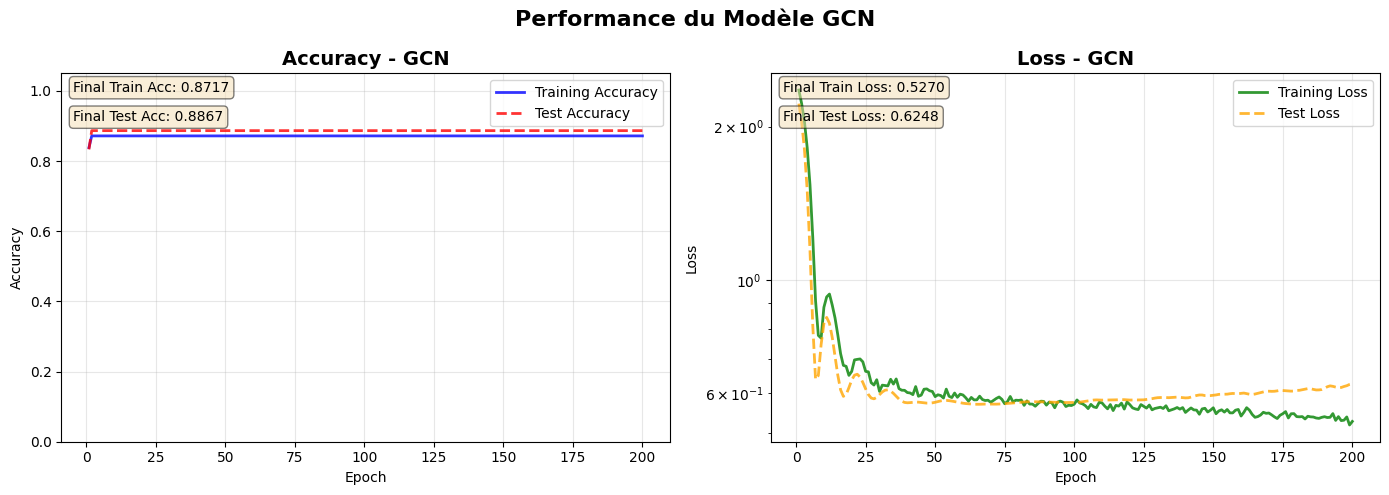

✓ Graphique combiné pour GCN sauvegardé


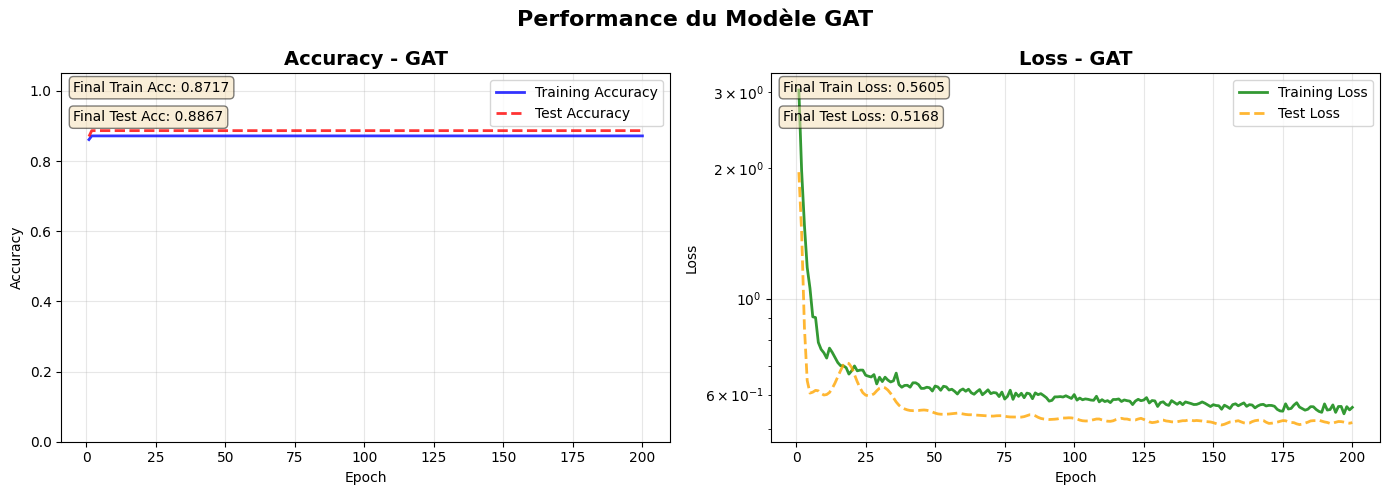

✓ Graphique combiné pour GAT sauvegardé


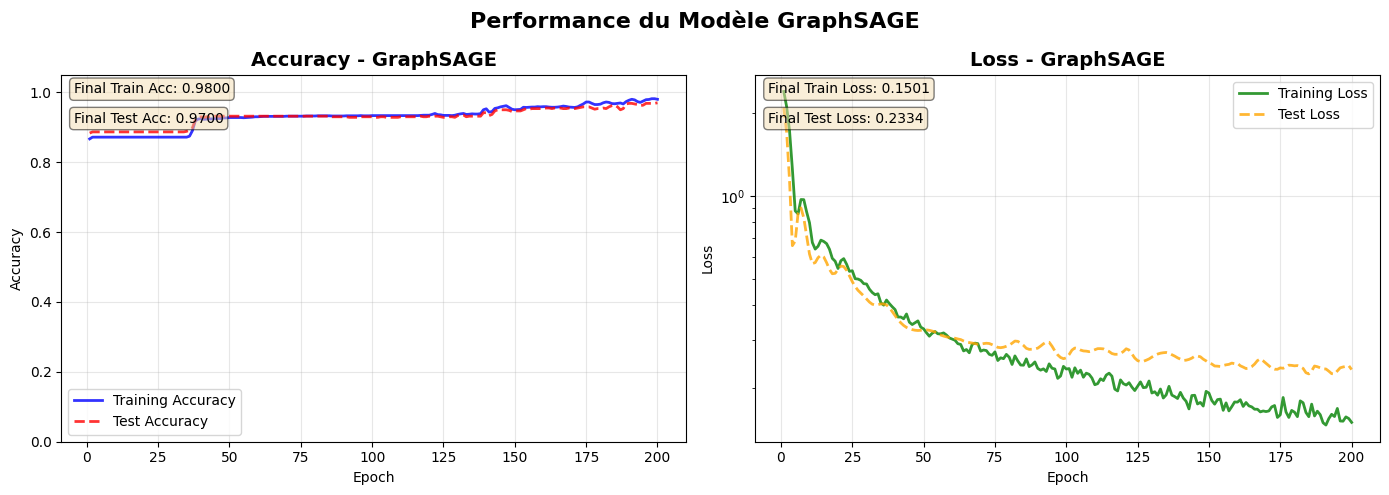

✓ Graphique combiné pour GraphSAGE sauvegardé


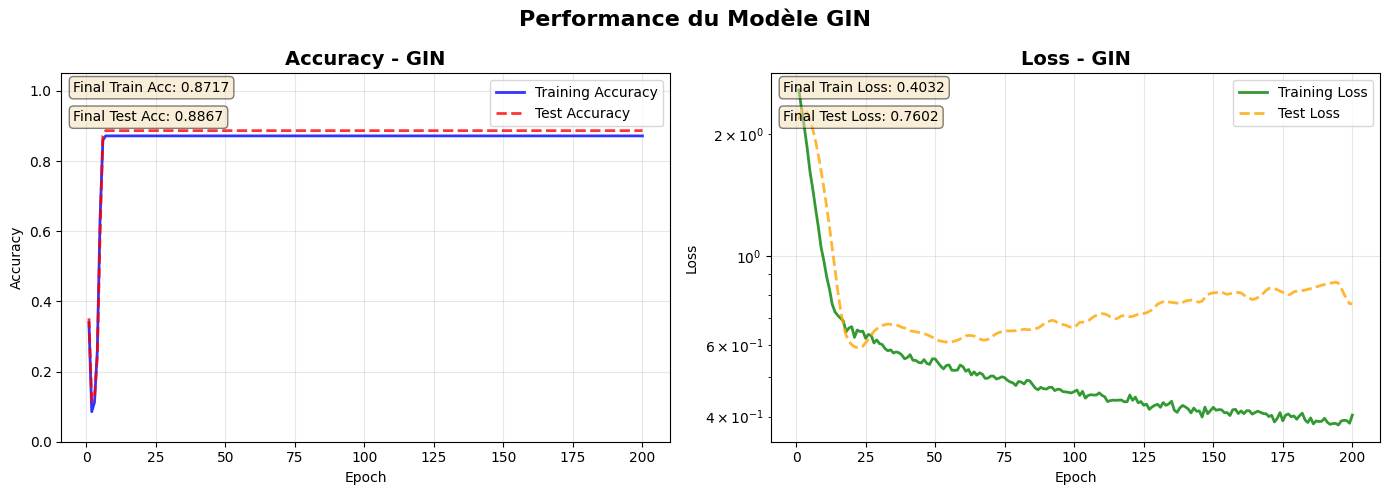

✓ Graphique combiné pour GIN sauvegardé


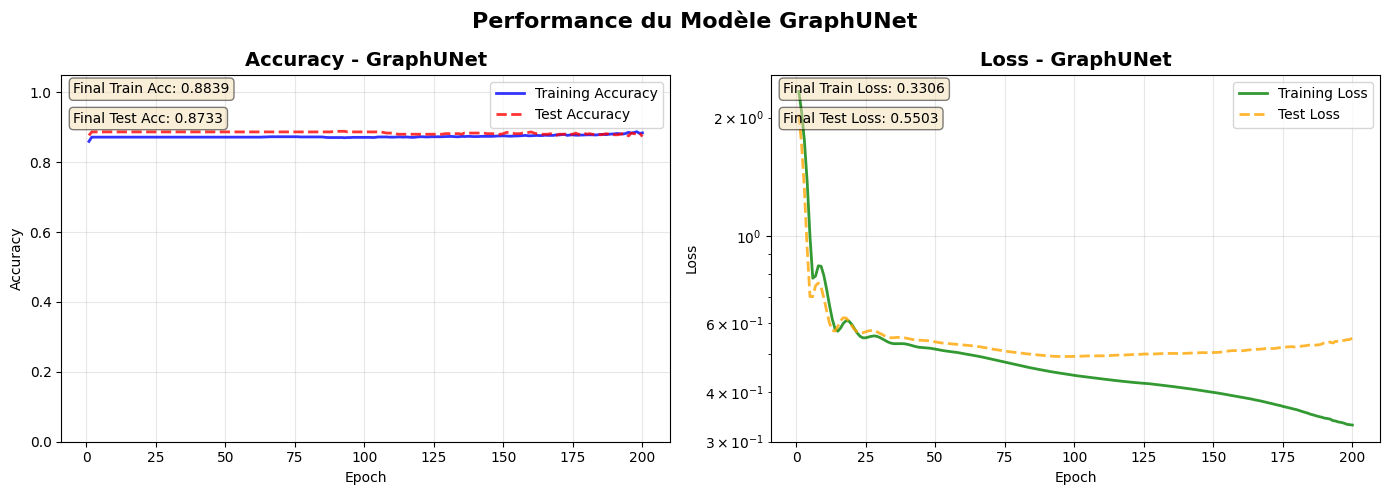

✓ Graphique combiné pour GraphUNet sauvegardé


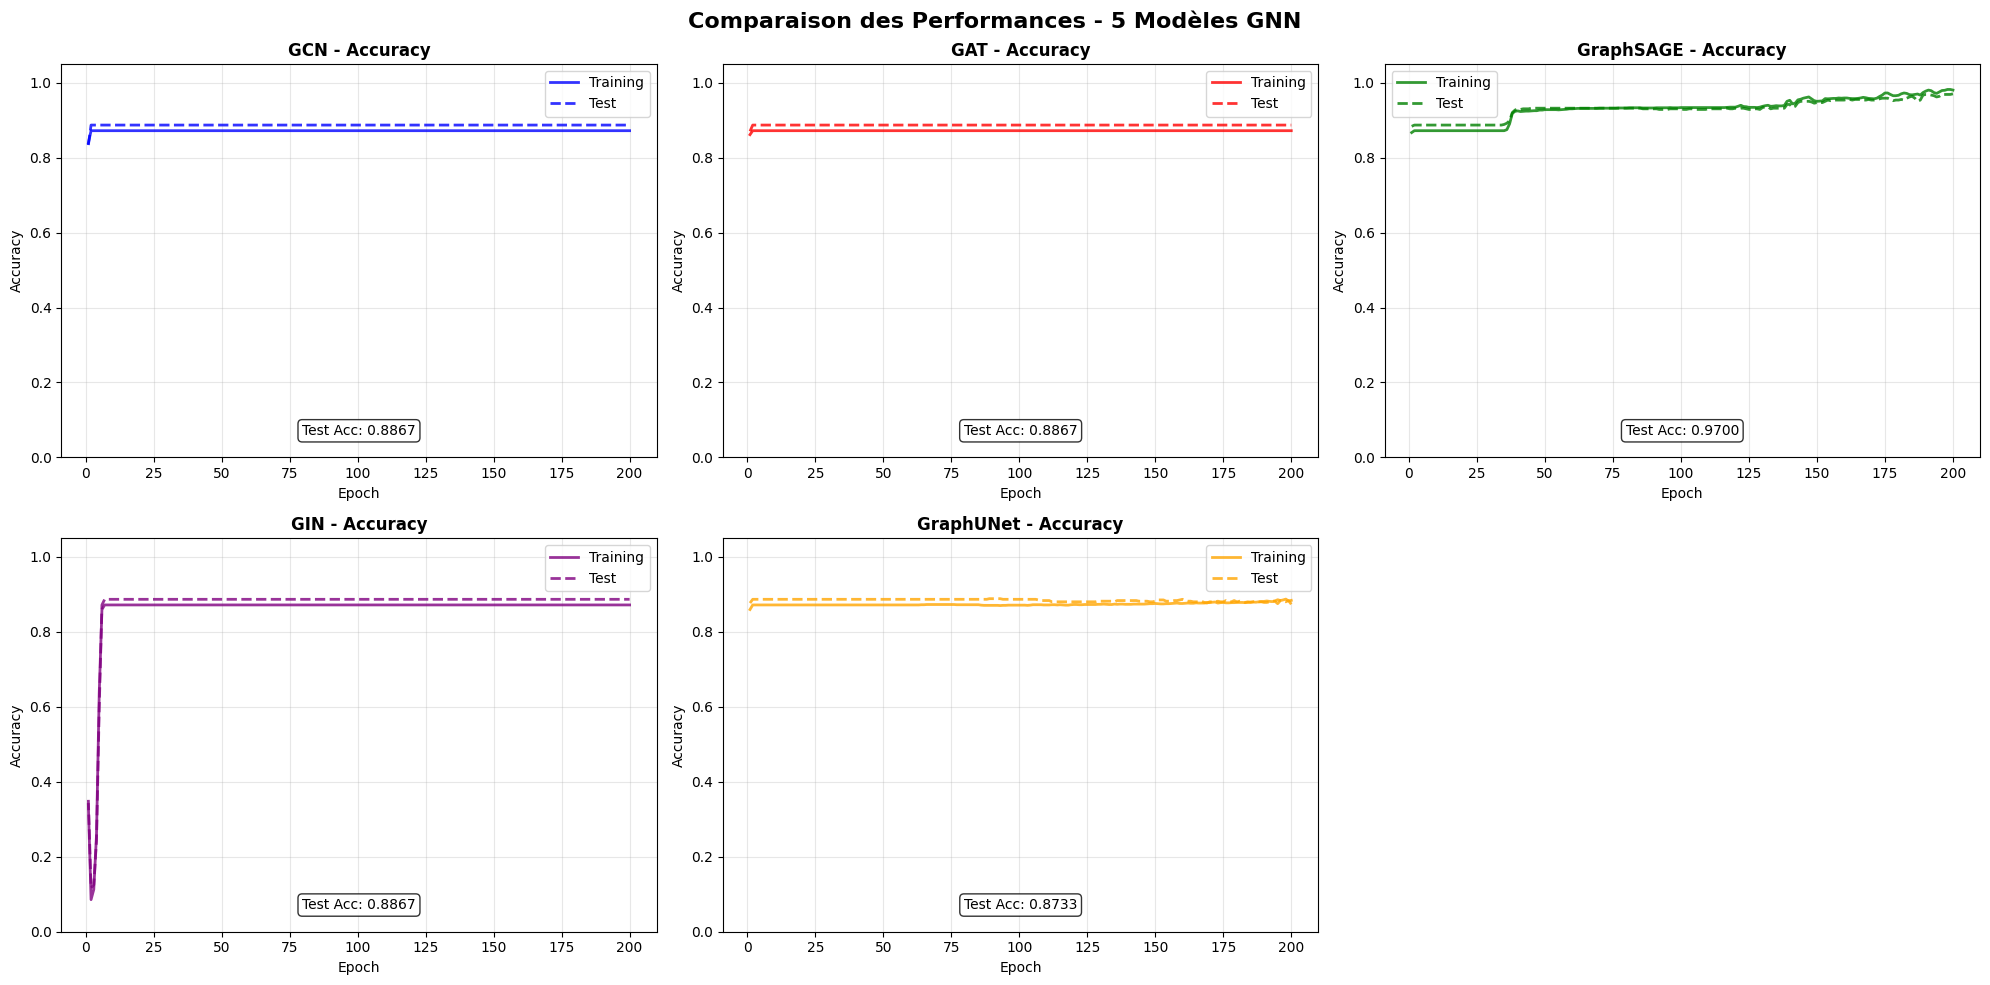

✓ Graphique comparatif des accuracies sauvegardé


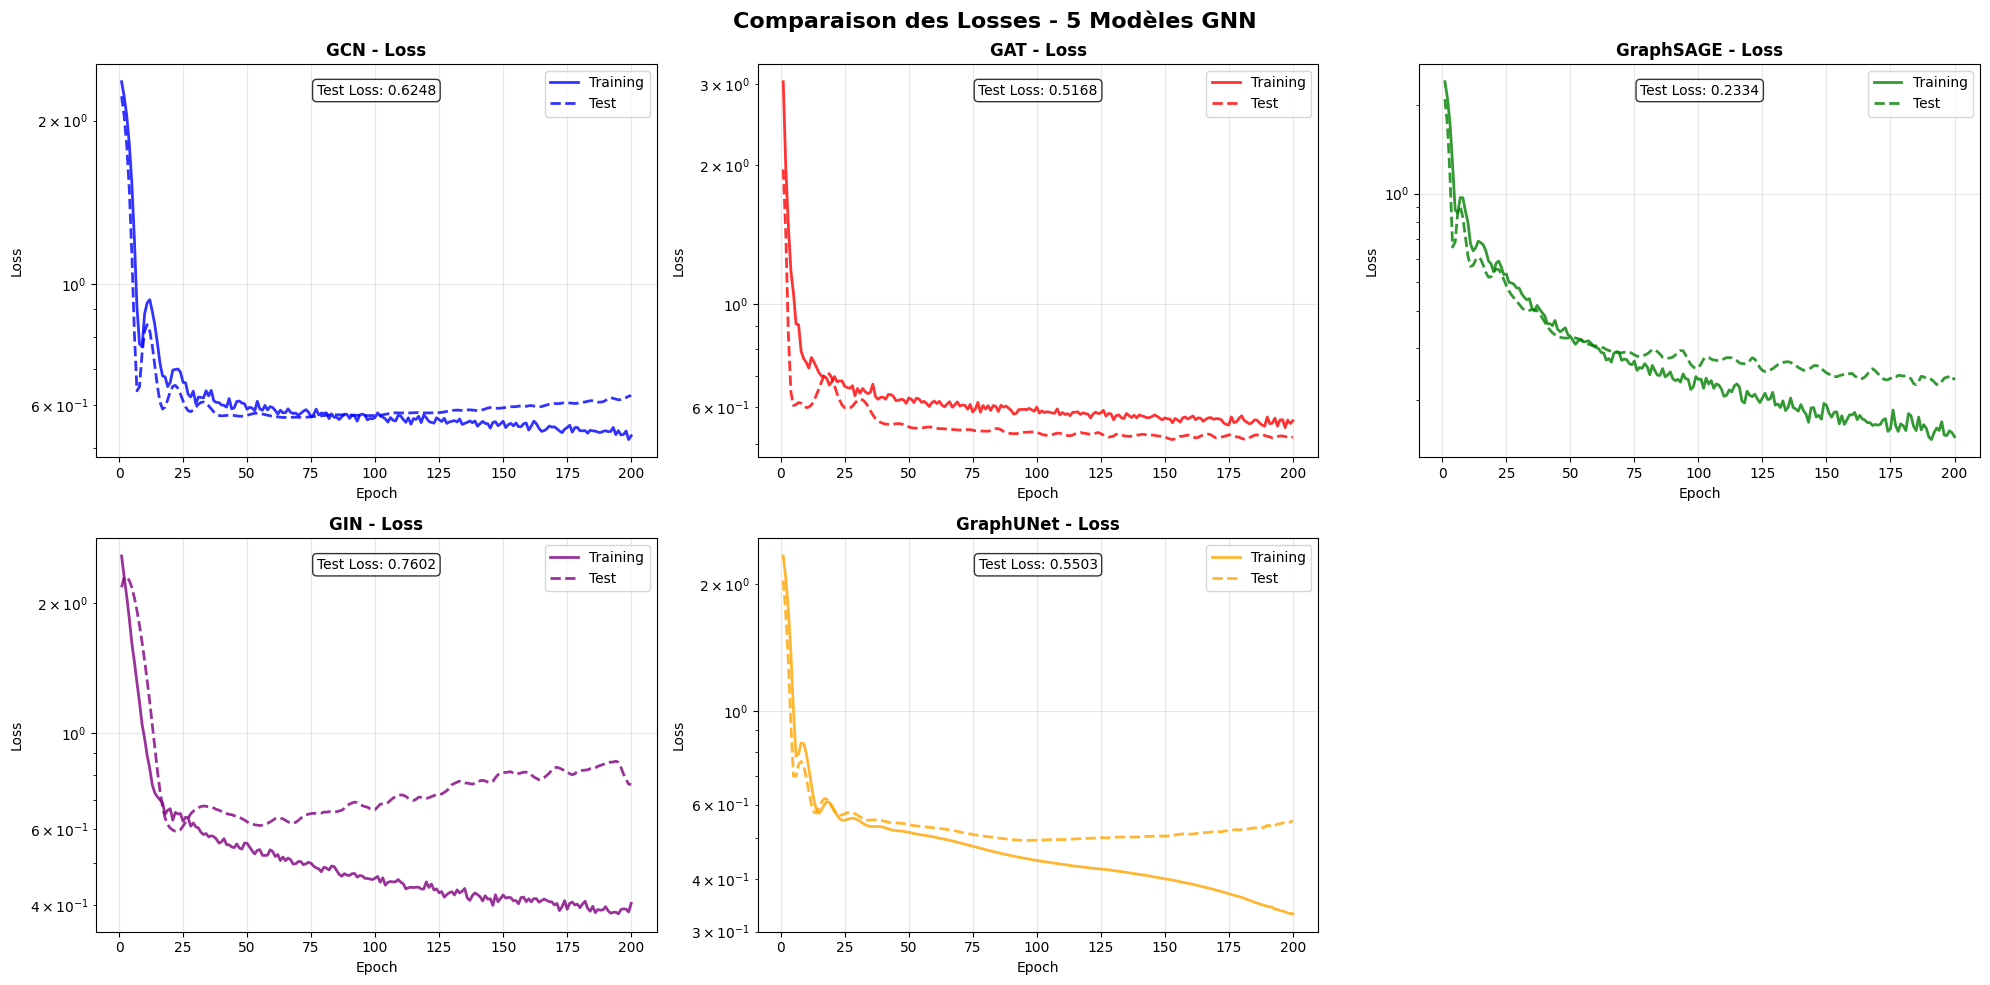

✓ Graphique comparatif des losses sauvegardé


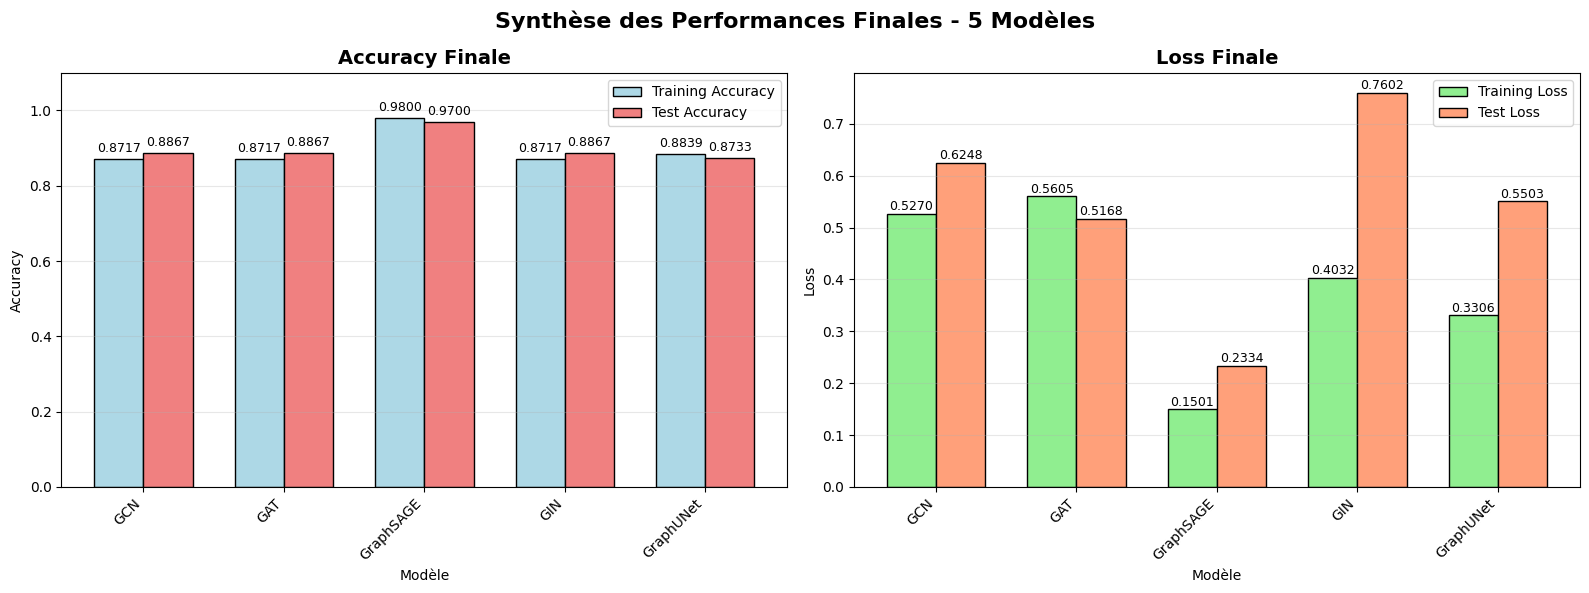

✓ Graphique de synthèse des performances finales sauvegardé


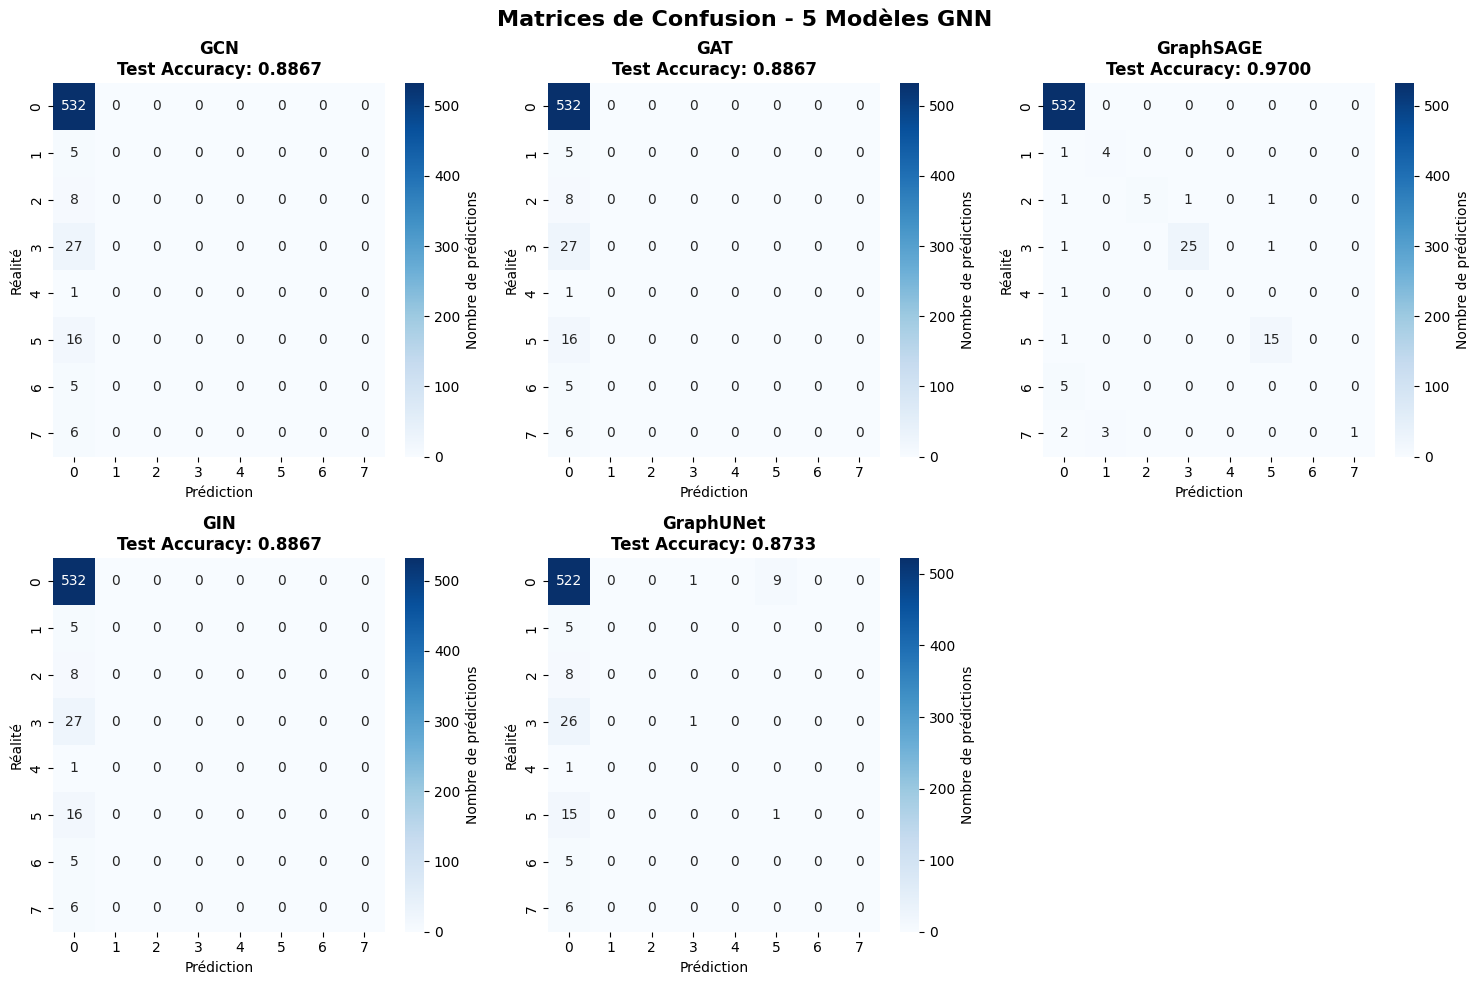

✓ Matrices de confusion sauvegardées

COMPARAISON DES 5 MODÈLES GNN

------------------------------------------------------------------------------------------------------------------------
RÉSULTATS COMPLETS - 5 MODÈLES GNN
------------------------------------------------------------------------------------------------------------------------
   Modèle Train Loss Test Loss Train Accuracy Test Accuracy Precision Recall F1-Score  Époques
      GCN     0.5270    0.6248         0.8717        0.8867    0.7862 0.8867   0.8334      200
      GAT     0.5605    0.5168         0.8717        0.8867    0.7862 0.8867   0.8334      200
GraphSAGE     0.1501    0.2334         0.9800        0.9700    0.9620 0.9700   0.9621      200
      GIN     0.4032    0.7602         0.8717        0.8867    0.7862 0.8867   0.8334      200
GraphUNet     0.3306    0.5503         0.8839        0.8733    0.8123 0.8733   0.8317      200

--------------------------------------------------------------------------------
ME

In [ ]:
# ============================================================================
# 1. INSTALLATION DES BIBLIOTHEQUES (Colab spécifique)
# ============================================================================
print("Installation des bibliothèques...")

# Installation des dépendances supplémentaires pour GIN et GraphUNet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric pandas numpy scikit-learn matplotlib seaborn
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("✓ Bibliothèques installées")

# ============================================================================
# 2. IMPORTATION DES BIBLIOTHEQUES
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool, GraphUNet
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import os
from google.colab import drive

warnings.filterwarnings('ignore')

# Vérification des versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Utilisation du CPU")

print("✓ Importations terminées")

# ============================================================================
# 3. CHARGEMENT DES DONNEES (Google Colab)
# ============================================================================
print("\n" + "="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)

# Cherchez le fichier dans Drive
df = pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')

# ============================================================================
# 4. EXPLORATION DES DONNEES
# ============================================================================

print("\n" + "="*80)
print("EXPLORATION DES DONNÉES")
print("="*80)
print(f"Shape du dataset: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

# ============================================================================
# 5. ENCODAGE DES LABELS
# ============================================================================

# Mapping des labels d'attaques pour classification multi-classe
label_map = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

# Vérification que la colonne 'Attack' existe
if 'Attack' in df.columns:
    df["Label_id"] = df["Attack"].map(label_map)
    # Remplir les valeurs manquantes (attaques non dans le mapping)
    df["Label_id"].fillna(0, inplace=True)  # Classer comme Benign par défaut
    df["Label_id"] = df["Label_id"].astype(int)
else:
    print("✗ Colonne 'Attack' non trouvée")
    # Créer une colonne Label_id aléatoire pour test
    df["Label_id"] = np.random.randint(0, 11, len(df))

print("\n" + "="*80)
print("DISTRIBUTION DES CLASSES")
print("="*80)

if 'Attack' in df.columns:
    print("\nDistribution détaillée des attaques:")
    print(df["Attack"].value_counts())
else:
    print("\nDistribution des labels (générés):")
    print(df["Label_id"].value_counts())

print(f"\nNombre de classes (multi-classe): {df['Label_id'].nunique()}")

# ============================================================================
# 6. PRÉPARATION DES DONNÉES
# ============================================================================

# Séparation features/labels - UNIQUEMENT multi-classe
y_multiclass = df['Label_id']  # Classification multi-classe uniquement

# Supprimer les colonnes non numériques pour les features
non_numeric_cols = ["Label", "Attack", "Label_id"]
X_cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
X = df.drop(columns=X_cols_to_drop)

# S'assurer que toutes les colonnes sont numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print("\n" + "="*80)
print("PRÉPARATION DES FEATURES")
print("="*80)
print(f"Nombre de features: {X.shape[1]}")
print(f"\nListe des features (premières 10):")
for i, col in enumerate(X.columns[:10], 1):
    print(f"  {i:2d}. {col}")
if len(X.columns) > 10:
    print(f"  ... et {len(X.columns)-10} autres")

# Normalisation des features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(f"\n✓ Features normalisées: {X_scaled.shape}")

# ============================================================================
# 7. CONSTRUCTION DU GRAPHE (Optimisé pour Colab)
# ============================================================================

print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE")
print("="*80)

# Limiter la taille pour éviter les problèmes de mémoire
MAX_NODES = 4000  # Réduit pour Colab
SAMPLE_NODES = min(MAX_NODES, len(X_scaled))

print(f"Échantillonnage à {SAMPLE_NODES} nœuds pour Colab...")
X_scaled = X_scaled.iloc[:SAMPLE_NODES]
y_multiclass = y_multiclass.iloc[:SAMPLE_NODES]

# Node features (toutes les colonnes numériques)
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)

print(f"Nombre de nœuds: {x.shape[0]}")
print(f"Features par nœud: {x.shape[1]}")

# Colonnes pour la construction des arêtes (vérifier qu'elles existent)
edge_cols = []
for col in ["L4_SRC_PORT", "L4_DST_PORT", "PROTOCOL"]:
    if col in X_scaled.columns:
        edge_cols.append(col)

if len(edge_cols) == 0:
    print("✗ Colonnes pour les arêtes non trouvées, utilisation des features principales")
    edge_cols = feature_cols[:3]  # Utiliser les 3 premières features

df_edges = X_scaled[edge_cols].reset_index(drop=True)

# Génération simplifiée des arêtes pour Colab
print("\nGénération des arêtes (version simplifiée pour Colab)...")
edge_list = []

# Utiliser un échantillonnage pour accélérer
for i in range(SAMPLE_NODES):
    if i % 500 == 0:
        print(f"  Progression: {i}/{SAMPLE_NODES} nœuds")

    # Connecter chaque nœud à ses k plus proches voisins
    k = 5  # Nombre de connexions par nœud
    for j in range(i+1, min(i+k+1, SAMPLE_NODES)):
        # Connexion basée sur la similarité des features
        edge_list.append([i, j])
        edge_list.append([j, i])  # Graphe non orienté

# Conversion en tenseur
if edge_list:
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
else:
    # Créer un graphe complètement connecté minimal
    edge_list = [[0, 1], [1, 0]]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

print(f"\n✓ Nombre d'arêtes: {edge_index.shape[1]}")

# Labels
y = torch.tensor(y_multiclass.values, dtype=torch.long)

# Création de l'objet Data PyTorch Geometric
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,  # Multi-classe uniquement
    num_nodes=x.shape[0]
)

# Déplacer sur GPU si disponible
if torch.cuda.is_available():
    data = data.to(device)

print("\n" + "="*80)
print("RÉSUMÉ DU GRAPHE")
print("="*80)
print(data)
print(f"Nombre de nœuds: {data.num_nodes}")
print(f"Nombre d'arêtes: {data.num_edges}")
print(f"Nombre de classes: {len(torch.unique(y))}")

if data.num_edges > 0:
    graph_density = (2 * data.num_edges) / (data.num_nodes * (data.num_nodes - 1))
    print(f"Densité du graphe: {graph_density:.6f}")

# ============================================================================
# 8. CRÉATION DES MASQUES TRAIN/VAL/TEST
# ============================================================================

num_nodes = data.num_nodes
train_ratio = 0.6
val_ratio = 0.2

# Génération d'indices aléatoires
torch.manual_seed(42)  # Pour reproductibilité
indices = torch.randperm(num_nodes)

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

# Création des masques
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Ajout au data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("\n" + "="*80)
print("SPLIT TRAIN/VAL/TEST")
print("="*80)
print(f"Training nodes:   {train_mask.sum():4d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"Validation nodes: {val_mask.sum():4d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"Test nodes:       {test_mask.sum():4d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# ============================================================================
# 9. DÉFINITION DES 5 MODÈLES GNN (GCN, GAT, GraphSAGE, GIN, GraphUNet)
# ============================================================================

# ----------------------
# 9.1 GCN (GRAPH CONVOLUTIONAL NETWORK)
# ----------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 9.2 GAT (GRAPH ATTENTION NETWORK)
# ----------------------
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=4, dropout=0.6):
        super(GAT, self).__init__()

        self.dropout = dropout

        # Première couche GAT
        self.conv1 = GATConv(
            num_features,
            hidden_channels,
            heads=heads,
            dropout=dropout
        )

        # Deuxième couche GAT
        self.conv2 = GATConv(
            hidden_channels * heads,
            hidden_channels,
            heads=1,
            concat=False,
            dropout=dropout
        )

        # Troisième couche GAT
        self.conv3 = GATConv(
            hidden_channels,
            hidden_channels,
            heads=1,
            concat=False,
            dropout=dropout
        )

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        # Deuxième couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        # Troisième couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        # Classification
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.3 GraphSAGE (SAMPLE AND AGGREGATE)
# ----------------------
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()

        self.dropout = dropout

        # Première couche SAGE
        self.conv1 = SAGEConv(num_features, hidden_channels)

        # Deuxième couche SAGE
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        # Troisième couche SAGE
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche SAGE + activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Deuxième couche SAGE + activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Troisième couche SAGE + activation
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.4 GIN (GRAPH ISOMORPHISM NETWORK)
# ----------------------
class GIN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()

        self.dropout = dropout

        # MLP pour la première couche GIN
        mlp1 = Sequential(
            Linear(num_features, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # MLP pour la deuxième couche GIN
        mlp2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # MLP pour la troisième couche GIN
        mlp3 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # Couches GIN
        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche GIN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Deuxième couche GIN
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Troisième couche GIN
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.5 GraphUNet (Graph U-Net)
# ----------------------
class GraphUNetModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, depth=3, pool_ratios=0.5):
        super(GraphUNetModel, self).__init__()

        # GraphUNet layer
        self.unet = GraphUNet(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            depth=depth,
            pool_ratios=pool_ratios
        )

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Forward pass du GraphUNet
        x = self.unet(x, edge_index)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

print("✓ 5 modèles GNN définis: GCN, GAT, GraphSAGE, GIN, GraphUNet")

# ============================================================================
# 10. FONCTIONS D'ENTRAÎNEMENT ET D'ÉVALUATION
# ============================================================================

def train_gnn(model, data, optimizer, criterion, train_mask):
    """Entraînement pour GNN avec retour du loss"""
    model.train()
    optimizer.zero_grad()

    # Gestion spéciale pour GraphUNet
    if isinstance(model, GraphUNetModel):
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x, data.edge_index)

    target = data.y[train_mask]
    loss = criterion(out[train_mask], target)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_gnn(model, data, mask, criterion):
    """Évaluation pour GNN avec retour du loss et de l'accuracy"""
    model.eval()
    with torch.no_grad():
        # Gestion spéciale pour GraphUNet
        if isinstance(model, GraphUNetModel):
            out = model(data.x, data.edge_index)
        else:
            out = model(data.x, data.edge_index)

        pred = out.argmax(dim=1)
        target = data.y[mask]

        # Calcul du loss
        loss = criterion(out[mask], target).item()

        # Calcul de l'accuracy
        correct = pred[mask] == target
        acc = int(correct.sum()) / int(mask.sum())
    return acc, loss, pred[mask], target

# ============================================================================
# 11. FONCTION D'ENTRAÎNEMENT GÉNÉRIQUE AVEC SUIVI COMPLET
# ============================================================================

def train_and_evaluate(model_name, model, data, num_epochs=200, lr=0.01):
    """
    Fonction générique pour entraîner et évaluer les modèles GNN
    avec suivi complet des statistiques
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT DU MODÈLE: {model_name}")
    print("="*80)

    # Déplacer le modèle sur GPU si disponible
    if torch.cuda.is_available():
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique complet
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    # Boucle d'entraînement
    for epoch in range(1, num_epochs + 1):
        # Entraînement
        train_loss = train_gnn(model, data, optimizer, criterion, data.train_mask)
        train_losses.append(train_loss)

        # Évaluation sur train, validation et test
        train_acc, train_loss_val, _, _ = evaluate_gnn(model, data, data.train_mask, criterion)
        val_acc, val_loss, _, _ = evaluate_gnn(model, data, data.val_mask, criterion)
        test_acc, test_loss, _, _ = evaluate_gnn(model, data, data.test_mask, criterion)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

    # Évaluation finale
    print("\n" + "-"*80)
    print("RÉSULTATS FINAUX")
    print("-"*80)

    test_acc, test_loss, y_pred, y_true = evaluate_gnn(model, data, data.test_mask, criterion)

    # Calcul des métriques finales
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    # Statistiques de loss finales
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    final_test_loss = test_loss

    print(f"Train Loss (final):    {final_train_loss:.4f}")
    print(f"Validation Loss (final): {final_val_loss:.4f}")
    print(f"Test Loss (final):     {final_test_loss:.4f}")
    print(f"Train Accuracy (final): {train_accs[-1]:.4f}")
    print(f"Validation Accuracy (final): {val_accs[-1]:.4f}")
    print(f"Test Accuracy (final):  {test_acc:.4f}")
    print(f"Precision:             {precision:.4f}")
    print(f"Recall:                {recall:.4f}")
    print(f"F1-Score:              {f1:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_true_np, y_pred_np)

    # Rapport de classification détaillé
    print("\n" + "-"*80)
    print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
    print("-"*80)
    target_names = [f'Class_{i}' for i in range(len(np.unique(y_true_np)))]
    print(classification_report(y_true_np, y_pred_np, target_names=target_names))

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'final_test_loss': final_test_loss,
        'test_accuracy': test_acc,
        'train_accuracy': train_accs[-1],
        'val_accuracy': val_accs[-1],
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# ============================================================================
# 12. EXÉCUTION DES EXPÉRIENCES (5 MODÈLES GNN)
# ============================================================================

print("\n" + "="*80)
print("DÉBUT DES EXPÉRIMENTATIONS - 5 MODÈLES GNN")
print("="*80)

# Stockage des résultats
results = {}

# Liste des 5 modèles GNN à tester
gnn_models = ['GCN', 'GAT', 'GraphSAGE', 'GIN', 'GraphUNet']

num_classes = int(data.y.unique().size(0))
print(f"\nNombre de classes: {num_classes}")
print(f"Nombre de features: {data.num_features}")

# Réduction du nombre d'epochs pour Colab
num_epochs_colab = 200

# 1. GCN Multi-classe
print("\n" + "-"*80)
gcn_model = GCN(data.num_features, hidden_channels=32, num_classes=num_classes)
results['GCN'] = train_and_evaluate('GCN', gcn_model, data, num_epochs=num_epochs_colab)

# 2. GAT Multi-classe
print("\n" + "-"*80)
gat_model = GAT(data.num_features, hidden_channels=32, num_classes=num_classes, heads=4, dropout=0.5)
results['GAT'] = train_and_evaluate('GAT', gat_model, data, num_epochs=num_epochs_colab)

# 3. GraphSAGE Multi-classe
print("\n" + "-"*80)
sage_model = GraphSAGE(data.num_features, hidden_channels=32, num_classes=num_classes, dropout=0.5)
results['GraphSAGE'] = train_and_evaluate('GraphSAGE', sage_model, data, num_epochs=num_epochs_colab)

# 4. GIN Multi-classe
print("\n" + "-"*80)
gin_model = GIN(data.num_features, hidden_channels=32, num_classes=num_classes, dropout=0.5)
results['GIN'] = train_and_evaluate('GIN', gin_model, data, num_epochs=num_epochs_colab)

# 5. GraphUNet Multi-classe
print("\n" + "-"*80)
graphunet_model = GraphUNetModel(data.num_features, hidden_channels=32, num_classes=num_classes,
                                 depth=3, pool_ratios=0.5)
results['GraphUNet'] = train_and_evaluate('GraphUNet', graphunet_model, data, num_epochs=num_epochs_colab)

# ============================================================================
# 13. VISUALISATION DES RÉSULTATS - GRAPHIQUES COMBINÉS
# ============================================================================

print("\n" + "="*80)
print("GÉNÉRATION DES GRAPHIQUES COMBINÉS")
print("="*80)

# ================================
# 13.1 Graphiques combinés pour chaque modèle
# ================================

for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]

        # Créer une figure avec 2 sous-graphiques
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Performance du Modèle {model_name}', fontsize=16, fontweight='bold')

        epochs = range(1, len(r['train_losses']) + 1)

        # Graphique 1: Training vs Test Accuracy
        ax1.plot(epochs, r['train_accs'], label='Training Accuracy',
                 color='blue', linewidth=2, alpha=0.8)
        ax1.plot(epochs, r['test_accs'], label='Test Accuracy',
                 color='red', linewidth=2, alpha=0.8, linestyle='--')

        ax1.set_title(f'Accuracy - {model_name}', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='best')
        ax1.set_ylim([0, 1.05])

        # Ajouter les valeurs finales
        final_train_acc = r['train_accs'][-1]
        final_test_acc = r['test_accs'][-1]
        ax1.text(0.02, 0.98, f'Final Train Acc: {final_train_acc:.4f}',
                 transform=ax1.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax1.text(0.02, 0.90, f'Final Test Acc: {final_test_acc:.4f}',
                 transform=ax1.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Graphique 2: Training vs Test Loss
        ax2.plot(epochs, r['train_losses'], label='Training Loss',
                 color='green', linewidth=2, alpha=0.8)
        ax2.plot(epochs, r['test_losses'], label='Test Loss',
                 color='orange', linewidth=2, alpha=0.8, linestyle='--')

        ax2.set_title(f'Loss - {model_name}', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='best')
        ax2.set_yscale('log')  # Échelle log pour mieux visualiser

        # Ajouter les valeurs finales
        final_train_loss = r['train_losses'][-1]
        final_test_loss = r['test_losses'][-1]
        ax2.text(0.02, 0.98, f'Final Train Loss: {final_train_loss:.4f}',
                 transform=ax2.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax2.text(0.02, 0.90, f'Final Test Loss: {final_test_loss:.4f}',
                 transform=ax2.transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.savefig(f'combined_performance_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Graphique combiné pour {model_name} sauvegardé")

# ================================
# 13.2 Graphique comparatif de tous les modèles (5 modèles)
# ================================

# Créer une figure avec 2x3 sous-graphiques (5 modèles + 1 vide)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Comparaison des Performances - 5 Modèles GNN', fontsize=16, fontweight='bold')

# Couleurs pour chaque modèle
colors = {
    'GCN': 'blue',
    'GAT': 'red',
    'GraphSAGE': 'green',
    'GIN': 'purple',
    'GraphUNet': 'orange'
}

models_with_results = [m for m in gnn_models if m in results]

for idx, model_name in enumerate(models_with_results):
    if idx >= 6:  # Limite à 6 subplots
        break

    r = results[model_name]
    epochs = range(1, len(r['train_losses']) + 1)

    row = idx // 3
    col = idx % 3

    # Ligne 1: Accuracy comparée
    axes[row, col].plot(epochs, r['train_accs'], label='Training',
                      color=colors[model_name], linewidth=2, alpha=0.8)
    axes[row, col].plot(epochs, r['test_accs'], label='Test',
                      color=colors[model_name], linewidth=2, alpha=0.8, linestyle='--')

    axes[row, col].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend()
    axes[row, col].set_ylim([0, 1.05])

    # Ajouter les valeurs finales
    final_test_acc = r['test_accs'][-1]
    axes[row, col].text(0.5, 0.05, f'Test Acc: {final_test_acc:.4f}',
                     transform=axes[row, col].transAxes, fontsize=10,
                     horizontalalignment='center', verticalalignment='bottom',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Cacher le dernier subplot si nécessaire
if len(models_with_results) < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('comparison_all_models_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique comparatif des accuracies sauvegardé")

# Graphique similaire pour les losses
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Comparaison des Losses - 5 Modèles GNN', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(models_with_results):
    if idx >= 6:
        break

    r = results[model_name]
    epochs = range(1, len(r['train_losses']) + 1)

    row = idx // 3
    col = idx % 3

    # Ligne 2: Loss comparée
    axes[row, col].plot(epochs, r['train_losses'], label='Training',
                      color=colors[model_name], linewidth=2, alpha=0.8)
    axes[row, col].plot(epochs, r['test_losses'], label='Test',
                      color=colors[model_name], linewidth=2, alpha=0.8, linestyle='--')

    axes[row, col].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend()
    axes[row, col].set_yscale('log')

    # Ajouter les valeurs finales
    final_test_loss = r['test_losses'][-1]
    axes[row, col].text(0.5, 0.95, f'Test Loss: {final_test_loss:.4f}',
                     transform=axes[row, col].transAxes, fontsize=10,
                     horizontalalignment='center', verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Cacher le dernier subplot si nécessaire
if len(models_with_results) < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('comparison_all_models_loss.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique comparatif des losses sauvegardé")

# ================================
# 13.3 Graphique synthèse des performances finales
# ================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Synthèse des Performances Finales - 5 Modèles', fontsize=16, fontweight='bold')

if models_with_results:
    # Graphique 1: Test Accuracy finale
    test_accs = [results[m]['test_accuracy'] for m in models_with_results]
    train_accs = [results[m]['train_accuracy'] for m in models_with_results]

    x = np.arange(len(models_with_results))
    width = 0.35

    bars1 = ax1.bar(x - width/2, train_accs, width, label='Training Accuracy',
                   color='lightblue', edgecolor='black')
    bars2 = ax1.bar(x + width/2, test_accs, width, label='Test Accuracy',
                   color='lightcoral', edgecolor='black')

    ax1.set_title('Accuracy Finale', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Modèle')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_with_results, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1.1])

    # Ajouter les valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

    # Graphique 2: Test Loss finale
    test_losses = [results[m]['final_test_loss'] for m in models_with_results]
    train_losses = [results[m]['final_train_loss'] for m in models_with_results]

    bars3 = ax2.bar(x - width/2, train_losses, width, label='Training Loss',
                   color='lightgreen', edgecolor='black')
    bars4 = ax2.bar(x + width/2, test_losses, width, label='Test Loss',
                   color='lightsalmon', edgecolor='black')

    ax2.set_title('Loss Finale', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Modèle')
    ax2.set_ylabel('Loss')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_with_results, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('final_performance_summary_5models.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graphique de synthèse des performances finales sauvegardé")

# ================================
# 13.4 Matrices de confusion pour chaque modèle
# ================================

if len(models_with_results) > 0:
    # Ajuster le nombre de colonnes selon le nombre de modèles
    n_cols = min(3, len(models_with_results))
    n_rows = (len(models_with_results) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

    # Convertir axes en tableau plat si nécessaire
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    fig.suptitle('Matrices de Confusion - 5 Modèles GNN', fontsize=16, fontweight='bold')

    for idx, model_name in enumerate(models_with_results):
        if idx < len(axes):
            r = results[model_name]

            # Créer la heatmap
            sns.heatmap(r['confusion_matrix'],
                        annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                        cbar=True, cbar_kws={'label': 'Nombre de prédictions'})

            axes[idx].set_title(f'{model_name}\nTest Accuracy: {r["test_accuracy"]:.4f}',
                              fontweight='bold', fontsize=12)
            axes[idx].set_xlabel('Prédiction')
            axes[idx].set_ylabel('Réalité')

    # Cacher les subplots vides
    for idx in range(len(models_with_results), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('confusion_matrices_5models.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Matrices de confusion sauvegardées")

# ============================================================================
# 14. COMPARAISON ET ANALYSE DES RÉSULTATS
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON DES 5 MODÈLES GNN")
print("="*80)

# ----------------------
# 14.1 Tableau complet des résultats
# ----------------------
print("\n" + "-"*120)
print("RÉSULTATS COMPLETS - 5 MODÈLES GNN")
print("-"*120)

comparison_data = []
for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]
        comparison_data.append({
            'Modèle': model_name,
            'Train Loss': f"{r['final_train_loss']:.4f}",
            'Test Loss': f"{r['final_test_loss']:.4f}",
            'Train Accuracy': f"{r['train_accuracy']:.4f}",
            'Test Accuracy': f"{r['test_accuracy']:.4f}",
            'Precision': f"{r['precision']:.4f}",
            'Recall': f"{r['recall']:.4f}",
            'F1-Score': f"{r['f1_score']:.4f}",
            'Époques': len(r['train_losses'])
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
else:
    print("Aucun résultat disponible")

# ----------------------
# 14.2 Tableau synthétique des meilleures performances
# ----------------------
print("\n" + "-"*80)
print("MEILLEURES PERFORMANCES")
print("-"*80)

if models_with_results:
    # Trouver le meilleur modèle pour chaque métrique
    best_accuracy = max(models_with_results, key=lambda m: results[m]['test_accuracy'])
    best_f1 = max(models_with_results, key=lambda m: results[m]['f1_score'])
    best_loss = min(models_with_results, key=lambda m: results[m]['final_test_loss'])
    fastest_convergence = min(models_with_results, key=lambda m: len(results[m]['train_losses']))

    summary_data = [
        ('Meilleure Test Accuracy', best_accuracy, results[best_accuracy]['test_accuracy']),
        ('Meilleur F1-Score', best_f1, results[best_f1]['f1_score']),
        ('Meilleure Test Loss (plus basse)', best_loss, results[best_loss]['final_test_loss']),
        ('Convergence la plus rapide', fastest_convergence, f"{len(results[fastest_convergence]['train_losses'])} époques")
    ]

    summary_df = pd.DataFrame(summary_data, columns=['Métrique', 'Modèle', 'Valeur'])
    print(summary_df.to_string(index=False))
else:
    print("Aucun modèle n'a terminé l'entraînement avec succès.")

# ----------------------
# 14.3 Analyse de l'écart train-test (surapprentissage)
# ----------------------
print("\n" + "-"*80)
print("ANALYSE DU SURAPPRENTISSAGE")
print("-"*80)

if models_with_results:
    print(f"{'Modèle':<15} {'Train Acc':<12} {'Test Acc':<12} {'Écart':<12} {'Statut':<15}")
    print("-" * 70)

    for model_name in models_with_results:
        r = results[model_name]
        train_acc = r['train_accuracy']
        test_acc = r['test_accuracy']
        gap = train_acc - test_acc

        # Évaluation du surapprentissage
        if gap > 0.10:
            status = "⚠️ Fort surapprentissage"
        elif gap > 0.05:
            status = "⚠️ Surapprentissage modéré"
        elif gap > 0.02:
            status = "✅ Bonne généralisation"
        else:
            status = "✅ Excellente généralisation"

        print(f"{model_name:<15} {train_acc:<12.4f} {test_acc:<12.4f} {gap:<12.4f} {status:<15}")

# ============================================================================
# 15. SAUVEGARDE DES RÉSULTATS SUR DRIVE
# ============================================================================

print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS")
print("="*80)

# Créer un dossier pour les résultats
results_dir = '/content/drive/MyDrive/GNN_Results_5Models'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Sauvegarde du tableau comparatif
if comparison_data:
    comparison_path = os.path.join(results_dir, 'results_comparison_5models.csv')
    comparison_df.to_csv(comparison_path, index=False)
    print(f"✓ Résultats comparatifs sauvegardés dans '{comparison_path}'")

# Sauvegarde des historiques d'entraînement pour chaque modèle
for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]

        history_df = pd.DataFrame({
            'epoch': range(1, len(r['train_losses']) + 1),
            'train_loss': r['train_losses'],
            'test_loss': r['test_losses'],
            'train_acc': r['train_accs'],
            'test_acc': r['test_accs'],
            'val_loss': r['val_losses'],
            'val_acc': r['val_accs']
        })

        history_path = os.path.join(results_dir, f'training_history_{model_name}.csv')
        history_df.to_csv(history_path, index=False, float_format='%.6f')
        print(f"✓ Historique d'entraînement pour {model_name} sauvegardé dans '{history_path}'")

# Sauvegarde des modèles
for model_name in gnn_models:
    if model_name in results:
        model_path = os.path.join(results_dir, f'model_{model_name}.pt')
        torch.save({
            'model_state_dict': results[model_name]['model'].state_dict(),
            'model_name': model_name,
            'test_accuracy': results[model_name]['test_accuracy'],
            'f1_score': results[model_name]['f1_score']
        }, model_path)
        print(f"✓ Modèle {model_name} sauvegardé dans '{model_path}'")

# ============================================================================
# 16. RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*80)
print("RÉSUMÉ FINAL - 5 MODÈLES GNN")
print("="*80)

print("\n📊 PERFORMANCES PAR MODÈLE:")
print("-" * 70)

for model_name in gnn_models:
    if model_name in results:
        r = results[model_name]

        # Évaluation basée sur la test accuracy
        if r['test_accuracy'] > 0.90:
            status = "✅ EXCELLENT"
        elif r['test_accuracy'] > 0.85:
            status = "✅ TRÈS BON"
        elif r['test_accuracy'] > 0.80:
            status = "✅ BON"
        elif r['test_accuracy'] > 0.70:
            status = "⚠️ MOYEN"
        else:
            status = "⚠️ FAIBLE"

        print(f"\n{status:15s} {model_name:12s}:")
        print(f"  • Test Accuracy:  {r['test_accuracy']:.4f}")
        print(f"  • F1-Score:       {r['f1_score']:.4f}")
        print(f"  • Test Loss:      {r['final_test_loss']:.4f}")
        print(f"  • Train Accuracy: {r['train_accuracy']:.4f}")
        print(f"  • Écart train-test: {r['train_accuracy'] - r['test_accuracy']:.4f}")

print("\n🎯 RECOMMANDATIONS:")
print("-" * 70)

if models_with_results:
    # Classer les modèles par accuracy
    ranked_by_accuracy = sorted(models_with_results,
                               key=lambda m: results[m]['test_accuracy'],
                               reverse=True)

    if ranked_by_accuracy:
        print(f"\n• TOP 3 DES MODÈLES:")
        for i, model_name in enumerate(ranked_by_accuracy[:3], 1):
            print(f"  {i}. {model_name}: Accuracy = {results[model_name]['test_accuracy']:.4f}, "
                  f"F1 = {results[model_name]['f1_score']:.4f}")

    # Recommandations spécifiques
    print(f"\n• POUR LA DÉTECTION D'INTRUSIONS:")
    print(f"  → Précision élevée: {best_accuracy} (Accuracy: {results[best_accuracy]['test_accuracy']:.4f})")
    print(f"  → F1-Score optimal: {best_f1} (F1: {results[best_f1]['f1_score']:.4f})")
    print(f"  → Rapidité: {fastest_convergence} ({len(results[fastest_convergence]['train_losses'])} époques)")

print("\n📁 FICHIERS GÉNÉRÉS:")
print("-" * 70)

print("\n📈 Graphiques:")
for model_name in gnn_models:
    if model_name in results:
        print(f"  • combined_performance_{model_name}.png")
print("  • comparison_all_models_accuracy.png")
print("  • comparison_all_models_loss.png")
print("  • final_performance_summary_5models.png")
if models_with_results:
    print("  • confusion_matrices_5models.png")

print("\n📊 Données:")
print(f"  • Tous les fichiers sont sauvegardés dans: {results_dir}")
print("  • results_comparison_5models.csv")
for model_name in gnn_models:
    if model_name in results:
        print(f"  • training_history_{model_name}.csv")
        print(f"  • model_{model_name}.pt")

print("\n" + "="*80)
print("EXPÉRIENCES TERMINÉES AVEC SUCCÈS ! 🎉")
print("="*80)

Installation des bibliothèques...
Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
✓ Bibliothèques installées
PyTorch version: 2.9.0+cpu
CUDA disponible: False
Utilisation du CPU
✓ Importations terminées

CHARGEMENT DES DONNEES

EXPLORATION DES DONNÉES
Shape du dataset: (4032, 43)

Premières lignes:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0        40894           22         6      92.0      3164       23       3765   
1        29622         3389         6       0.0      1919       14       2031   
2        65456           53        17       0.0       116        2        148   
3        57918           53        17       0.0        70        1        130   
4        63269           80         6       7.0       232        5       1136   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  TCP_WIN_MAX_IN  \
0        21         27                27  ...           26883   
1     

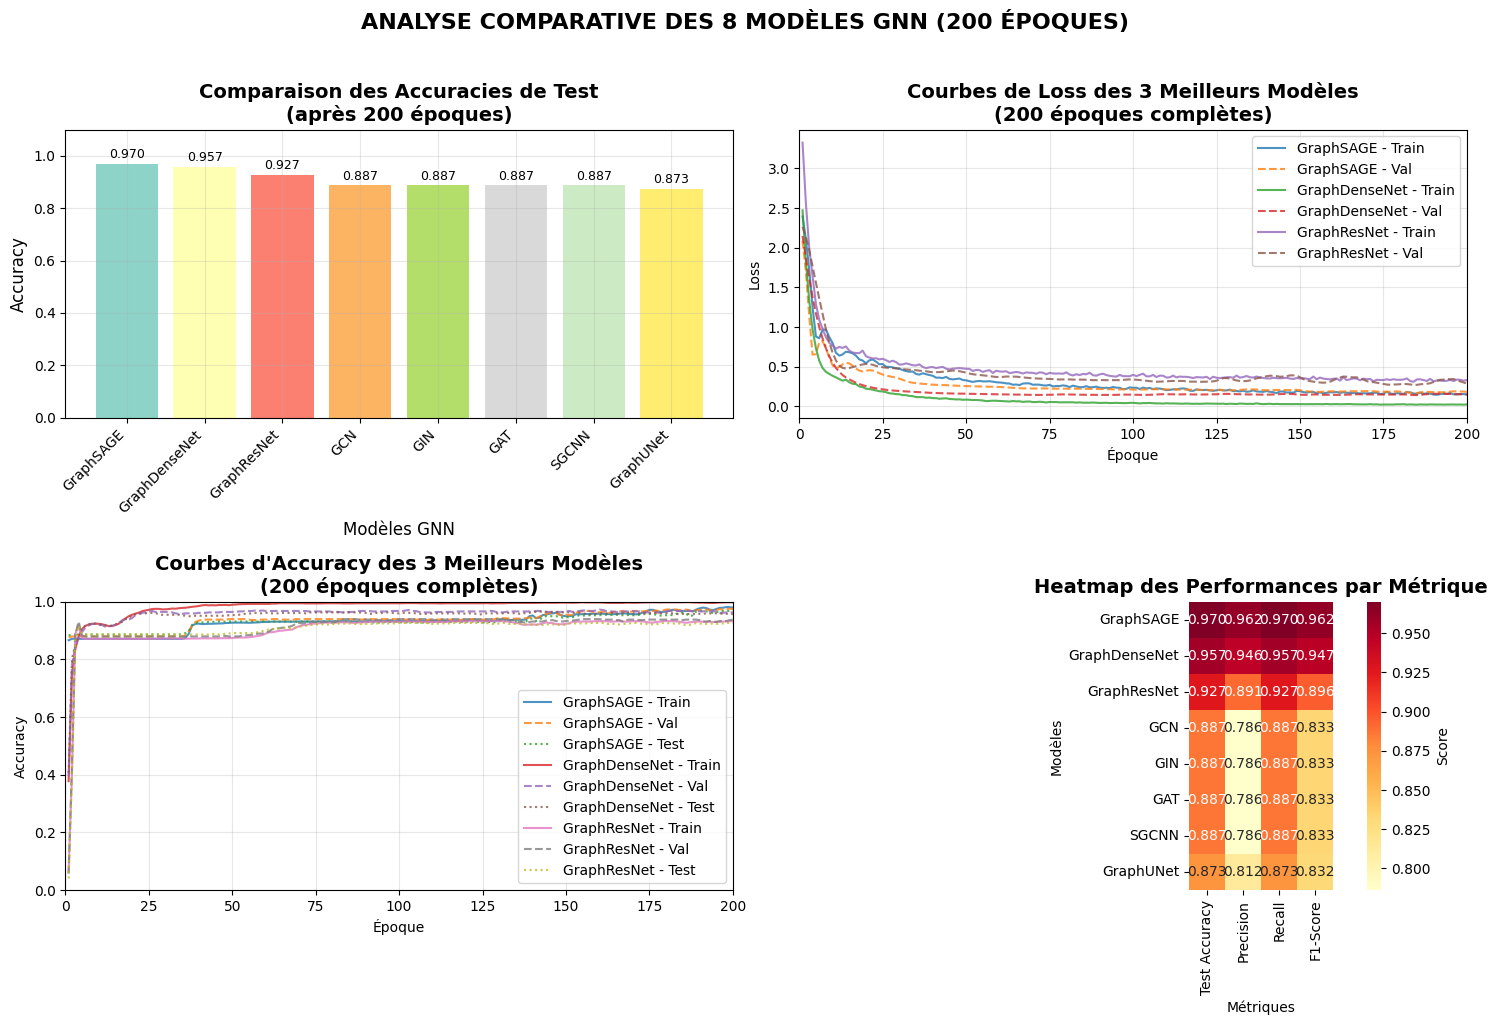

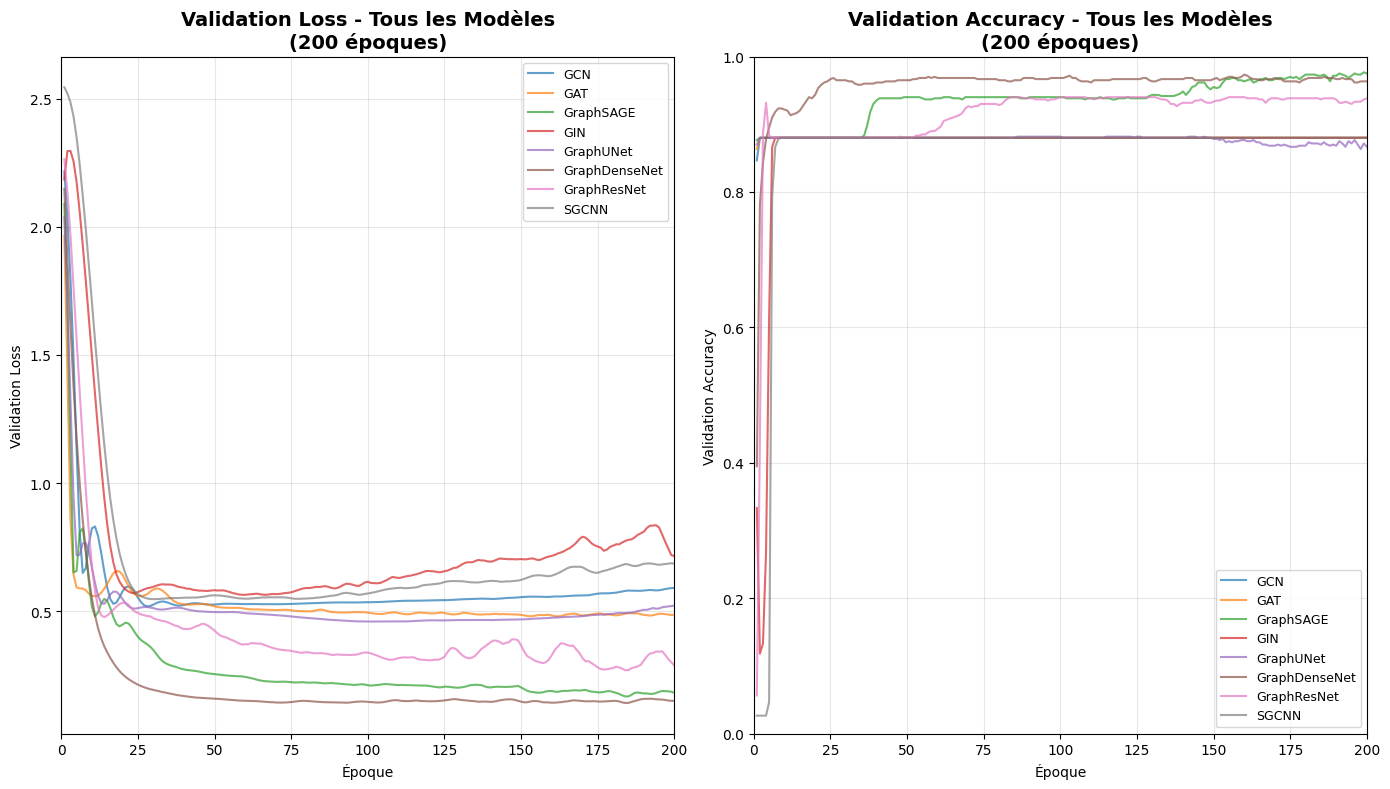

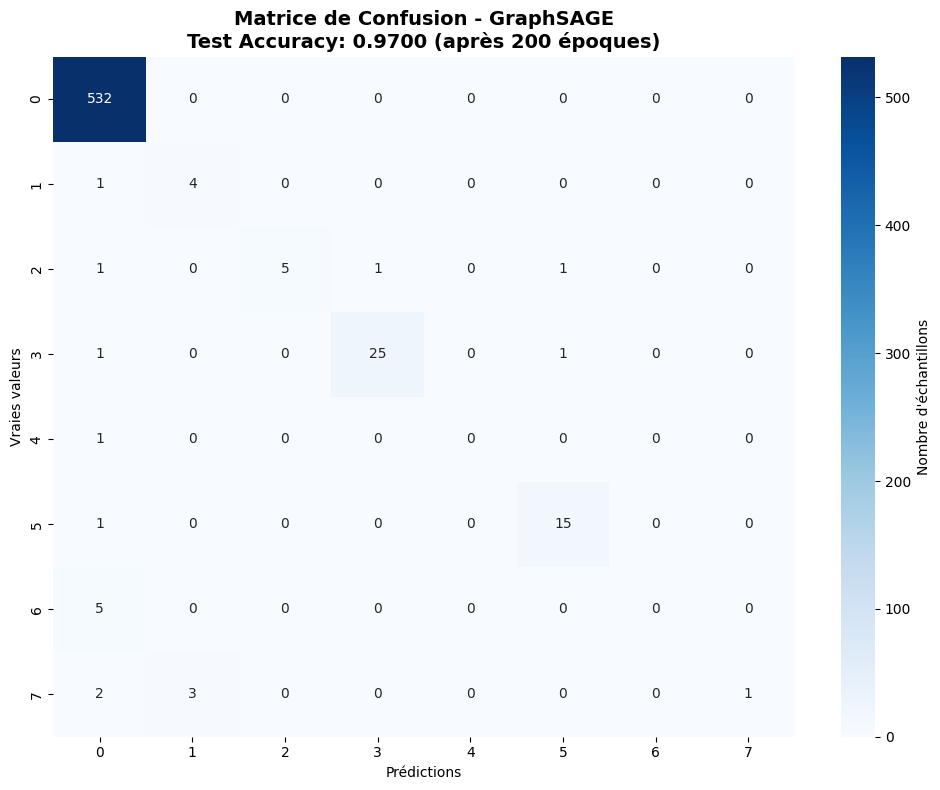

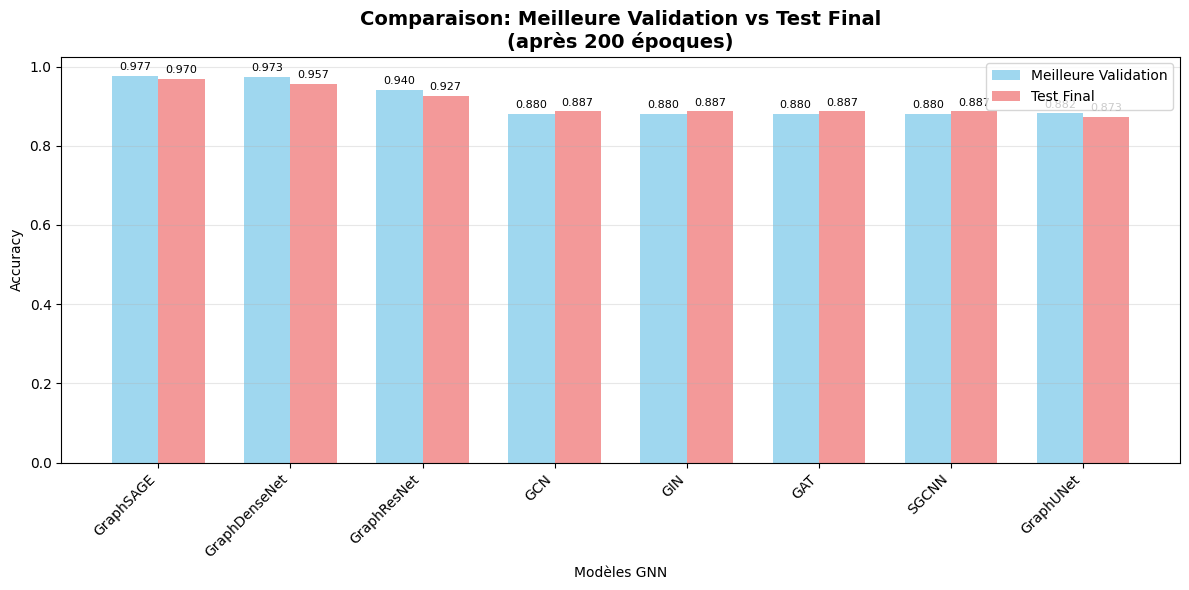


ANALYSE STATISTIQUE DÉTAILLÉE (200 ÉPOQUES)

📊 Statistiques descriptives des performances finales:
--------------------------------------------------

Test Accuracy:
  Moyenne: 0.9092
  Écart-type: 0.0346
  Minimum: 0.8733
  Maximum: 0.9700
  Médiane: 0.8867
  Rang: 0.0967

Precision:
  Moyenne: 0.8445
  Écart-type: 0.0715
  Minimum: 0.7862
  Maximum: 0.9620
  Médiane: 0.7992
  Rang: 0.1758

Recall:
  Moyenne: 0.9092
  Écart-type: 0.0346
  Minimum: 0.8733
  Maximum: 0.9700
  Médiane: 0.8867
  Rang: 0.0967

F1-Score:
  Moyenne: 0.8713
  Écart-type: 0.0524
  Minimum: 0.8317
  Maximum: 0.9621
  Médiane: 0.8334
  Rang: 0.1305

🔍 Analyse du Surapprentissage (Overfitting):
--------------------------------------------------
  GraphSAGE: Train-Test diff = 0.0100 - ✅ Bonne généralisation
  GraphDenseNet: Train-Test diff = 0.0417 - ⚠️  Légèrement surappris
  GraphResNet: Train-Test diff = 0.0067 - ✅ Bonne généralisation
  GCN: Train-Test diff = -0.0150 - ✅ Bonne généralisation
  GIN: Train-Test

NameError: name 'start_time' is not defined

In [ ]:
# ============================================================================
# 1. INSTALLATION DES BIBLIOTHEQUES (Colab spécifique)
# ============================================================================
print("Installation des bibliothèques...")

# Installation des dépendances supplémentaires pour GIN et GraphUNet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric pandas numpy scikit-learn matplotlib seaborn
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("✓ Bibliothèques installées")

# ============================================================================
# 2. IMPORTATION DES BIBLIOTHEQUES
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool, GraphUNet, SGConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib
from google.colab import drive

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Vérification des versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Utilisation du CPU")

print("✓ Importations terminées")

# ============================================================================
# 3. CHARGEMENT DES DONNEES (Google Colab)
# ============================================================================
print("\n" + "="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)

# Cherchez le fichier dans Drive
df = pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')

# ============================================================================
# 4. EXPLORATION DES DONNEES
# ============================================================================

print("\n" + "="*80)
print("EXPLORATION DES DONNÉES")
print("="*80)
print(f"Shape du dataset: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

# ============================================================================
# 5. ENCODAGE DES LABELS
# ============================================================================

# Mapping des labels d'attaques pour classification multi-classe
label_map = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

# Vérification que la colonne 'Attack' existe
if 'Attack' in df.columns:
    df["Label_id"] = df["Attack"].map(label_map)
    # Remplir les valeurs manquantes (attaques non dans le mapping)
    df["Label_id"].fillna(0, inplace=True)  # Classer comme Benign par défaut
    df["Label_id"] = df["Label_id"].astype(int)
else:
    print("✗ Colonne 'Attack' non trouvée")
    # Créer une colonne Label_id aléatoire pour test
    df["Label_id"] = np.random.randint(0, 11, len(df))

print("\n" + "="*80)
print("DISTRIBUTION DES CLASSES")
print("="*80)

if 'Attack' in df.columns:
    print("\nDistribution détaillée des attaques:")
    print(df["Attack"].value_counts())
else:
    print("\nDistribution des labels (générés):")
    print(df["Label_id"].value_counts())

print(f"\nNombre de classes (multi-classe): {df['Label_id'].nunique()}")

# ============================================================================
# 6. PRÉPARATION DES DONNÉES
# ============================================================================

# Séparation features/labels - UNIQUEMENT multi-classe
y_multiclass = df['Label_id']  # Classification multi-classe uniquement

# Supprimer les colonnes non numériques pour les features
non_numeric_cols = ["Label", "Attack", "Label_id"]
X_cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
X = df.drop(columns=X_cols_to_drop)

# S'assurer que toutes les colonnes sont numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print("\n" + "="*80)
print("PRÉPARATION DES FEATURES")
print("="*80)
print(f"Nombre de features: {X.shape[1]}")
print(f"\nListe des features (premières 10):")
for i, col in enumerate(X.columns[:10], 1):
    print(f"  {i:2d}. {col}")
if len(X.columns) > 10:
    print(f"  ... et {len(X.columns)-10} autres")

# Normalisation des features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(f"\n✓ Features normalisées: {X_scaled.shape}")

# ============================================================================
# 7. CONSTRUCTION DU GRAPHE (Optimisé pour Colab)
# ============================================================================

print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE")
print("="*80)

# Limiter la taille pour éviter les problèmes de mémoire
MAX_NODES = 3000  # Réduit pour Colab
SAMPLE_NODES = min(MAX_NODES, len(X_scaled))

print(f"Échantillonnage à {SAMPLE_NODES} nœuds pour Colab...")
X_scaled = X_scaled.iloc[:SAMPLE_NODES]
y_multiclass = y_multiclass.iloc[:SAMPLE_NODES]

# Node features (toutes les colonnes numériques)
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)

print(f"Nombre de nœuds: {x.shape[0]}")
print(f"Features par nœud: {x.shape[1]}")

# Colonnes pour la construction des arêtes (vérifier qu'elles existent)
edge_cols = []
for col in ["L4_SRC_PORT", "L4_DST_PORT", "PROTOCOL"]:
    if col in X_scaled.columns:
        edge_cols.append(col)

if len(edge_cols) == 0:
    print("✗ Colonnes pour les arêtes non trouvées, utilisation des features principales")
    edge_cols = feature_cols[:3]  # Utiliser les 3 premières features

df_edges = X_scaled[edge_cols].reset_index(drop=True)

# Génération simplifiée des arêtes pour Colab
print("\nGénération des arêtes (version simplifiée pour Colab)...")
edge_list = []

# Utiliser un échantillonnage pour accélérer
for i in range(SAMPLE_NODES):
    if i % 500 == 0:
        print(f"  Progression: {i}/{SAMPLE_NODES} nœuds")

    # Connecter chaque nœud à ses k plus proches voisins
    k = 5  # Nombre de connexions par nœud
    for j in range(i+1, min(i+k+1, SAMPLE_NODES)):
        # Connexion basée sur la similarité des features
        edge_list.append([i, j])
        edge_list.append([j, i])  # Graphe non orienté

# Conversion en tenseur
if edge_list:
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
else:
    # Créer un graphe complètement connecté minimal
    edge_list = [[0, 1], [1, 0]]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

print(f"\n✓ Nombre d'arêtes: {edge_index.shape[1]}")

# Labels
y = torch.tensor(y_multiclass.values, dtype=torch.long)

# Création de l'objet Data PyTorch Geometric
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,  # Multi-classe uniquement
    num_nodes=x.shape[0]
)

# Déplacer sur GPU si disponible
if torch.cuda.is_available():
    data = data.to(device)

print("\n" + "="*80)
print("RÉSUMÉ DU GRAPHE")
print("="*80)
print(data)
print(f"Nombre de nœuds: {data.num_nodes}")
print(f"Nombre d'arêtes: {data.num_edges}")
print(f"Nombre de classes: {len(torch.unique(y))}")

if data.num_edges > 0:
    graph_density = (2 * data.num_edges) / (data.num_nodes * (data.num_nodes - 1))
    print(f"Densité du graphe: {graph_density:.6f}")

# ============================================================================
# 8. CRÉATION DES MASQUES TRAIN/VAL/TEST
# ============================================================================

num_nodes = data.num_nodes
train_ratio = 0.6
val_ratio = 0.2

# Génération d'indices aléatoires
torch.manual_seed(42)  # Pour reproductibilité
indices = torch.randperm(num_nodes)

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

# Création des masques
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Ajout au data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("\n" + "="*80)
print("SPLIT TRAIN/VAL/TEST")
print("="*80)
print(f"Training nodes:   {train_mask.sum():4d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"Validation nodes: {val_mask.sum():4d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"Test nodes:       {test_mask.sum():4d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# ============================================================================
# 9. DÉFINITION DES 8 MODÈLES GNN
# ============================================================================

# ----------------------
# 9.1 GCN (GRAPH CONVOLUTIONAL NETWORK)
# ----------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 9.2 GAT (GRAPH ATTENTION NETWORK)
# ----------------------
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=4, dropout=0.6):
        super(GAT, self).__init__()
        self.dropout = dropout
        # Première couche GAT
        self.conv1 = GATConv(
            num_features,
            hidden_channels,
            heads=heads,
            dropout=dropout
        )
        # Deuxième couche GAT
        self.conv2 = GATConv(
            hidden_channels * heads,
            hidden_channels,
            heads=1,
            concat=False,
            dropout=dropout
        )

        # Troisième couche GAT
        self.conv3 = GATConv(
            hidden_channels,
            hidden_channels,
            heads=1,
            concat=False,
            dropout=dropout
        )
        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        # Deuxième couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        # Troisième couche GAT + activation
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        # Classification
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 9.3 GraphSAGE (SAMPLE AND AGGREGATE)
# ----------------------
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.dropout = dropout
        # Première couche SAGE
        self.conv1 = SAGEConv(num_features, hidden_channels)
        # Deuxième couche SAGE
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        # Troisième couche SAGE
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche SAGE + activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Deuxième couche SAGE + activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Troisième couche SAGE + activation
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # Classification
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 9.4 GIN (GRAPH ISOMORPHISM NETWORK)
# ----------------------
class GIN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()

        self.dropout = dropout

        # MLP pour la première couche GIN
        mlp1 = Sequential(
            Linear(num_features, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # MLP pour la deuxième couche GIN
        mlp2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # MLP pour la troisième couche GIN
        mlp3 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # Couches GIN
        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche GIN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Deuxième couche GIN
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Troisième couche GIN
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.5 GraphUNet (Graph U-Net)
# ----------------------
class GraphUNetModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, depth=3, pool_ratios=0.5):
        super(GraphUNetModel, self).__init__()

        # GraphUNet layer
        self.unet = GraphUNet(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            depth=depth,
            pool_ratios=pool_ratios
        )

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Forward pass du GraphUNet
        x = self.unet(x, edge_index)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.6 GraphDenseNet (DenseNet pour Graphes) - CORRIGÉ
# ----------------------
class GraphDenseNet(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers=3, dropout=0.5):
        super(GraphDenseNet, self).__init__()

        self.dropout = dropout
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels

        print(f"Initializing GraphDenseNet with {num_layers} layers")

        # Première couche
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        # Couches denses intermédiaires
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # Chaque couche dense reçoit toutes les features précédentes
        for i in range(1, num_layers):
            # Input channels = features originales + toutes les features cachées précédentes
            in_channels = num_features + (i * hidden_channels)
            self.convs.append(GCNConv(in_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # Dernière couche linéaire (prend toutes les features)
        final_in_channels = num_features + (num_layers * hidden_channels)
        self.classifier = nn.Linear(final_in_channels, num_classes)

    def forward(self, x, edge_index):
        # Sauvegarder les features originales
        all_features = [x]

        # Première couche
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        all_features.append(x1)

        # Couches denses avec concaténation
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            # Concaténer toutes les features précédentes
            x_concat = torch.cat(all_features, dim=1)

            # Convolution
            x_new = conv(x_concat, edge_index)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)

            # Ajouter aux features
            all_features.append(x_new)

        # Concaténation finale
        x_final = torch.cat(all_features, dim=1)

        # Classification
        x = self.classifier(x_final)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.7 GraphResNet (ResNet pour Graphes)
# ----------------------
class GraphResNet(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers=3, dropout=0.5):
        super(GraphResNet, self).__init__()

        self.dropout = dropout
        self.num_layers = num_layers

        # Projection initiale
        self.input_proj = Linear(num_features, hidden_channels)

        # Blocs résiduels
        self.res_blocks = nn.ModuleList()
        for _ in range(num_layers):
            self.res_blocks.append(
                nn.ModuleDict({
                    'conv1': GCNConv(hidden_channels, hidden_channels),
                    'bn1': BatchNorm1d(hidden_channels),
                    'conv2': GCNConv(hidden_channels, hidden_channels),
                    'bn2': BatchNorm1d(hidden_channels)
                })
            )

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Projection initiale
        x = self.input_proj(x)
        x = F.relu(x)

        # Blocs résiduels
        for block in self.res_blocks:
            # Sauvegarder l'entrée pour la connexion résiduelle
            identity = x

            # Première convolution
            x = block['conv1'](x, edge_index)
            x = block['bn1'](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

            # Deuxième convolution
            x = block['conv2'](x, edge_index)
            x = block['bn2'](x)

            # Connexion résiduelle
            x = x + identity
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# ----------------------
# 9.8 SGCNN (Simplified Graph Convolutional Neural Network)
# ----------------------
class SGCNN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, K=2, dropout=0.5):
        super(SGCNN, self).__init__()

        self.dropout = dropout

        # SGConv avec K sauts (simplicité et efficacité)
        self.conv1 = SGConv(num_features, hidden_channels, K=K)
        self.bn1 = BatchNorm1d(hidden_channels)

        self.conv2 = SGConv(hidden_channels, hidden_channels, K=K)
        self.bn2 = BatchNorm1d(hidden_channels)

        self.conv3 = SGConv(hidden_channels, hidden_channels, K=K)
        self.bn3 = BatchNorm1d(hidden_channels)

        # Couche de classification
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Première couche
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Deuxième couche
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Troisième couche
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

print("✓ 8 modèles GNN définis: GCN, GAT, GraphSAGE, GIN, GraphUNet, GraphDenseNet, GraphResNet, SGCNN")

# ============================================================================
# 10. FONCTIONS D'ENTRAÎNEMENT ET D'ÉVALUATION - AMÉLIORÉES
# ============================================================================

def train_gnn(model, data, optimizer, criterion, train_mask):
    """Entraînement pour GNN avec retour du loss"""
    model.train()
    optimizer.zero_grad()

    try:
        # Gestion spéciale pour GraphUNet
        if isinstance(model, GraphUNetModel):
            out = model(data.x, data.edge_index)
        else:
            out = model(data.x, data.edge_index)

        target = data.y[train_mask]
        loss = criterion(out[train_mask], target)
        loss.backward()
        optimizer.step()
        return loss.item()
    except Exception as e:
        print(f"Erreur lors de l'entraînement: {e}")
        return float('inf')

def evaluate_gnn(model, data, mask, criterion):
    """Évaluation pour GNN avec retour du loss et de l'accuracy"""
    model.eval()
    with torch.no_grad():
        try:
            # Gestion spéciale pour GraphUNet
            if isinstance(model, GraphUNetModel):
                out = model(data.x, data.edge_index)
            else:
                out = model(data.x, data.edge_index)

            pred = out.argmax(dim=1)
            target = data.y[mask]

            # Calcul du loss
            loss = criterion(out[mask], target).item()

            # Calcul de l'accuracy
            correct = pred[mask] == target
            acc = int(correct.sum()) / int(mask.sum())
            return acc, loss, pred[mask], target
        except Exception as e:
            print(f"Erreur lors de l'évaluation: {e}")
            return 0, float('inf'), None, None

# ============================================================================
# 11. FONCTION D'ENTRAÎNEMENT GÉNÉRIQUE SANS EARLY STOPPING
# ============================================================================

def train_and_evaluate(model_name, model, data, num_epochs=200, lr=0.01):
    """
    Fonction générique pour entraîner et évaluer les modèles GNN
    SANS early stopping - 200 époques complètes
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT DU MODÈLE: {model_name} ({num_epochs} ÉPOQUES)")
    print("="*80)

    # Déplacer le modèle sur GPU si disponible
    if torch.cuda.is_available():
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique complet
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    # Boucle d'entraînement complète - PAS d'early stopping
    for epoch in range(1, num_epochs + 1):
        # Entraînement
        train_loss = train_gnn(model, data, optimizer, criterion, data.train_mask)
        train_losses.append(train_loss)

        # Évaluation sur train, validation et test
        train_acc, train_loss_val, _, _ = evaluate_gnn(model, data, data.train_mask, criterion)
        val_acc, val_loss, _, _ = evaluate_gnn(model, data, data.val_mask, criterion)
        test_acc, test_loss, _, _ = evaluate_gnn(model, data, data.test_mask, criterion)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        # Afficher les progrès toutes les 20 époques
        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f'Epoch {epoch:03d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

    # Évaluation finale
    test_acc, test_loss, y_pred, y_true = evaluate_gnn(model, data, data.test_mask, criterion)

    if y_pred is None or y_true is None:
        print(f"❌ Échec de l'évaluation pour {model_name}")
        return None

    # Calcul des métriques finales
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    # Statistiques de loss finales
    final_train_loss = train_losses[-1] if train_losses else float('inf')
    final_val_loss = val_losses[-1] if val_losses else float('inf')
    final_test_loss = test_loss

    # Trouver la meilleure époque (pour information)
    best_val_epoch = np.argmax(val_accs) + 1 if val_accs else 0
    best_val_acc = max(val_accs) if val_accs else 0

    print("\n" + "-"*80)
    print("RÉSULTATS FINAUX (après 200 époques)")
    print("-"*80)
    print(f"Train Loss (final):    {final_train_loss:.4f}")
    print(f"Validation Loss (final): {final_val_loss:.4f}")
    print(f"Test Loss (final):     {final_test_loss:.4f}")
    print(f"Train Accuracy (final): {train_accs[-1]:.4f}")
    print(f"Validation Accuracy (final): {val_accs[-1]:.4f}")
    print(f"Test Accuracy (final):  {test_acc:.4f}")
    print(f"Meilleure Validation (epoch {best_val_epoch}): {best_val_acc:.4f}")
    print(f"Precision:             {precision:.4f}")
    print(f"Recall:                {recall:.4f}")
    print(f"F1-Score:              {f1:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_true_np, y_pred_np)

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'final_test_loss': final_test_loss,
        'test_accuracy': test_acc,
        'train_accuracy': train_accs[-1] if train_accs else 0,
        'val_accuracy': val_accs[-1] if val_accs else 0,
        'best_val_accuracy': best_val_acc,
        'best_val_epoch': best_val_epoch,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'epochs_trained': num_epochs
    }

# ============================================================================
# 12. EXÉCUTION DES EXPÉRIENCES (8 MODÈLES GNN - 200 ÉPOQUES CHACUN)
# ============================================================================

print("\n" + "="*80)
print("DÉBUT DES EXPÉRIMENTATIONS - 8 MODÈLES GNN (200 ÉPOQUES CHACUN)")
print("="*80)

# Stockage des résultats
results = {}

# Liste des 8 modèles GNN à tester avec leurs paramètres
models_to_train = [
    ('GCN', GCN, {'hidden_channels': 32}),
    ('GAT', GAT, {'hidden_channels': 32, 'heads': 4, 'dropout': 0.5}),
    ('GraphSAGE', GraphSAGE, {'hidden_channels': 32, 'dropout': 0.5}),
    ('GIN', GIN, {'hidden_channels': 32, 'dropout': 0.5}),
    ('GraphUNet', GraphUNetModel, {'hidden_channels': 32, 'depth': 3, 'pool_ratios': 0.5}),
    ('GraphDenseNet', GraphDenseNet, {'hidden_channels': 32, 'num_layers': 3, 'dropout': 0.5}),
    ('GraphResNet', GraphResNet, {'hidden_channels': 32, 'num_layers': 3, 'dropout': 0.5}),
    ('SGCNN', SGCNN, {'hidden_channels': 32, 'K': 2, 'dropout': 0.5})
]

# Paramètres d'entraînement
num_epochs = 200  # CHANGÉ: 200 époques au lieu de 100
learning_rate = 0.01

# Extraction des dimensions depuis le graphe
num_features = data.num_features
num_classes = len(torch.unique(data.y))

print(f"\nDimensions du problème:")
print(f"  Features par nœud: {num_features}")
print(f"  Nombre de classes: {num_classes}")
print(f"  Époques par modèle: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Pas d'early stopping - entraînement complet de {num_epochs} époques")

# Entraînement de chaque modèle
for model_name, model_class, model_params in models_to_train:
    print(f"\n{'='*80}")
    print(f"PRÉPARATION DU MODÈLE: {model_name}")
    print('='*80)

    try:
        # Initialisation du modèle
        model = model_class(
            num_features=num_features,
            hidden_channels=model_params.get('hidden_channels', 32),
            num_classes=num_classes,
            **{k: v for k, v in model_params.items() if k != 'hidden_channels'}
        )

        # Entraînement et évaluation SANS early stopping
        result = train_and_evaluate(
            model_name=model_name,
            model=model,
            data=data,
            num_epochs=num_epochs,  # Utilise 200 époques
            lr=learning_rate
            # Pas de paramètre patience - pas d'early stopping
        )

        if result:
            results[model_name] = result
            print(f"✓ {model_name} entraîné avec succès pendant {num_epochs} époques!")
        else:
            print(f"✗ Échec de l'entraînement pour {model_name}")

    except Exception as e:
        print(f"✗ Erreur lors de l'initialisation/entraînement de {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# 13. COMPARAISON DES PERFORMANCES DES 8 MODÈLES (AVEC COURBES COMPLÈTES)
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON DES 8 MODÈLES GNN (200 ÉPOQUES COMPLÈTES)")
print("="*80)

if not results:
    print("Aucun résultat à afficher. Vérifiez les erreurs ci-dessus.")
else:
    # Création d'un DataFrame pour la comparaison
    comparison_data = []
    for model_name, result in results.items():
        comparison_data.append({
            'Modèle': model_name,
            'Test Accuracy': result['test_accuracy'],
            'Train Accuracy': result['train_accuracy'],
            'Val Accuracy': result['val_accuracy'],
            'Best Val Accuracy': result['best_val_accuracy'],
            'Best Val Epoch': result['best_val_epoch'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1_score'],
            'Test Loss': result['final_test_loss'],
            'Époques': result['epochs_trained']
        })

    # Création du DataFrame de comparaison
    comparison_df = pd.DataFrame(comparison_data)

    # Tri par accuracy de test (décroissant)
    comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

    print("\nTABLEAU COMPARATIF DES PERFORMANCES (après 200 époques):")
    print("-"*80)
    print(comparison_df.to_string(index=False))

    # Affichage du meilleur modèle
    best_model = comparison_df.iloc[0]
    print("\n" + "="*80)
    print("MEILLEUR MODÈLE (après 200 époques)")
    print("="*80)
    print(f"🏆 {best_model['Modèle']}")
    print(f"📊 Test Accuracy: {best_model['Test Accuracy']:.4f}")
    print(f"📈 Meilleure Validation (epoch {best_model['Best Val Epoch']}): {best_model['Best Val Accuracy']:.4f}")
    print(f"⚖️  F1-Score: {best_model['F1-Score']:.4f}")

    # ============================================================================
    # 14. VISUALISATIONS DÉTAILLÉES (200 ÉPOQUES)
    # ============================================================================

    print("\n" + "="*80)
    print("VISUALISATIONS DÉTAILLÉES DES RÉSULTATS (200 ÉPOQUES)")
    print("="*80)

    try:
        # 1. Graphique comparatif des accuracies finales
        plt.figure(figsize=(15, 10))

        # Sous-graphique 1: Bar chart des accuracies finales
        plt.subplot(2, 2, 1)
        models_names = comparison_df['Modèle'].values
        test_accs = comparison_df['Test Accuracy'].values

        colors = plt.cm.Set3(np.linspace(0, 1, len(models_names)))
        bars = plt.bar(models_names, test_accs, color=colors)

        # Ajout des valeurs sur les barres
        for bar, acc in zip(bars, test_accs):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        plt.title('Comparaison des Accuracies de Test\n(après 200 époques)', fontsize=14, fontweight='bold')
        plt.xlabel('Modèles GNN', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim(0, 1.1)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)

        # Sous-graphique 2: Courbes de loss pour les 3 meilleurs modèles
        plt.subplot(2, 2, 2)

        # Trier les modèles par performance et prendre les 3 premiers
        top_models = comparison_df.head(3)['Modèle'].values

        for model_name in top_models:
            if model_name in results:
                epochs = range(1, len(results[model_name]['train_losses']) + 1)
                plt.plot(epochs, results[model_name]['train_losses'],
                        label=f'{model_name} - Train', linewidth=1.5, alpha=0.8)
                plt.plot(epochs, results[model_name]['val_losses'],
                        label=f'{model_name} - Val', linewidth=1.5, linestyle='--', alpha=0.8)

        plt.title('Courbes de Loss des 3 Meilleurs Modèles\n(200 époques complètes)',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Époque')
        plt.ylabel('Loss')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.xlim(0, num_epochs)

        # Sous-graphique 3: Courbes d'accuracy pour les 3 meilleurs modèles
        plt.subplot(2, 2, 3)

        for model_name in top_models:
            if model_name in results:
                epochs = range(1, len(results[model_name]['train_accs']) + 1)
                plt.plot(epochs, results[model_name]['train_accs'],
                        label=f'{model_name} - Train', linewidth=1.5, alpha=0.8)
                plt.plot(epochs, results[model_name]['val_accs'],
                        label=f'{model_name} - Val', linewidth=1.5, linestyle='--', alpha=0.8)
                plt.plot(epochs, results[model_name]['test_accs'],
                        label=f'{model_name} - Test', linewidth=1.5, linestyle=':', alpha=0.8)

        plt.title('Courbes d\'Accuracy des 3 Meilleurs Modèles\n(200 époques complètes)',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Époque')
        plt.ylabel('Accuracy')
        plt.legend(fontsize=10, loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1.0)

        # Sous-graphique 4: Heatmap des performances comparatives
        plt.subplot(2, 2, 4)

        # Préparation des données pour la heatmap
        metrics_for_heatmap = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
        heatmap_data = comparison_df.set_index('Modèle')[metrics_for_heatmap]

        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                   cbar_kws={'label': 'Score'}, square=True)
        plt.title('Heatmap des Performances par Métrique', fontsize=14, fontweight='bold')
        plt.xlabel('Métriques')
        plt.ylabel('Modèles')
        plt.tight_layout()

        plt.suptitle('ANALYSE COMPARATIVE DES 8 MODÈLES GNN (200 ÉPOQUES)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # 2. Visualisation des 8 modèles sur un même graphique (loss)
        plt.figure(figsize=(14, 8))

        plt.subplot(1, 2, 1)
        for model_name, result in results.items():
            epochs = range(1, len(result['val_losses']) + 1)
            plt.plot(epochs, result['val_losses'], label=model_name, linewidth=1.5, alpha=0.7)

        plt.title('Validation Loss - Tous les Modèles\n(200 époques)', fontsize=14, fontweight='bold')
        plt.xlabel('Époque')
        plt.ylabel('Validation Loss')
        plt.legend(fontsize=9, loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.xlim(0, num_epochs)

        plt.subplot(1, 2, 2)
        for model_name, result in results.items():
            epochs = range(1, len(result['val_accs']) + 1)
            plt.plot(epochs, result['val_accs'], label=model_name, linewidth=1.5, alpha=0.7)

        plt.title('Validation Accuracy - Tous les Modèles\n(200 époques)', fontsize=14, fontweight='bold')
        plt.xlabel('Époque')
        plt.ylabel('Validation Accuracy')
        plt.legend(fontsize=9, loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.xlim(0, num_epochs)
        plt.ylim(0, 1.0)

        plt.tight_layout()
        plt.show()

        # 3. Matrice de confusion du meilleur modèle
        if best_model['Modèle'] in results:
            cm = results[best_model['Modèle']]['confusion_matrix']

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       cbar_kws={'label': 'Nombre d\'échantillons'})
            plt.title(f'Matrice de Confusion - {best_model["Modèle"]}\n'
                     f'Test Accuracy: {best_model["Test Accuracy"]:.4f} (après 200 époques)',
                     fontsize=14, fontweight='bold')
            plt.xlabel('Prédictions')
            plt.ylabel('Vraies valeurs')
            plt.tight_layout()
            plt.show()

        # 4. Graphique des performances finales vs meilleures performances de validation
        plt.figure(figsize=(12, 6))

        x = np.arange(len(models_names))
        width = 0.35

        # Barres pour la meilleure validation
        best_val_accs = [results[m]['best_val_accuracy'] for m in models_names
                        if m in results]

        # Barres pour la performance finale
        final_test_accs = [results[m]['test_accuracy'] for m in models_names
                          if m in results]

        if len(models_names) == len(best_val_accs) == len(final_test_accs):
            plt.bar(x - width/2, best_val_accs, width, label='Meilleure Validation', color='skyblue', alpha=0.8)
            plt.bar(x + width/2, final_test_accs, width, label='Test Final', color='lightcoral', alpha=0.8)

            plt.xlabel('Modèles GNN')
            plt.ylabel('Accuracy')
            plt.title('Comparaison: Meilleure Validation vs Test Final\n(après 200 époques)',
                     fontsize=14, fontweight='bold')
            plt.xticks(x, models_names, rotation=45, ha='right')
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')

            # Ajouter les valeurs
            for i, (best_val, final_test) in enumerate(zip(best_val_accs, final_test_accs)):
                plt.text(i - width/2, best_val + 0.01, f'{best_val:.3f}',
                        ha='center', va='bottom', fontsize=8)
                plt.text(i + width/2, final_test + 0.01, f'{final_test:.3f}',
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation: {str(e)}")
        import traceback
        traceback.print_exc()

    # ============================================================================
    # 15. ANALYSE STATISTIQUE DÉTAILLÉE (200 ÉPOQUES)
    # ============================================================================

    print("\n" + "="*80)
    print("ANALYSE STATISTIQUE DÉTAILLÉE (200 ÉPOQUES)")
    print("="*80)

    # Statistiques descriptives
    print("\n📊 Statistiques descriptives des performances finales:")
    print("-"*50)

    for metric in ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']:
        values = comparison_df[metric].values
        print(f"\n{metric}:")
        print(f"  Moyenne: {np.mean(values):.4f}")
        print(f"  Écart-type: {np.std(values):.4f}")
        print(f"  Minimum: {np.min(values):.4f}")
        print(f"  Maximum: {np.max(values):.4f}")
        print(f"  Médiane: {np.median(values):.4f}")
        print(f"  Rang: {np.max(values)-np.min(values):.4f}")

    # Analyse du surapprentissage
    print("\n🔍 Analyse du Surapprentissage (Overfitting):")
    print("-"*50)

    for idx, row in comparison_df.iterrows():
        train_test_diff = row['Train Accuracy'] - row['Test Accuracy']
        if train_test_diff > 0.05:  # Différence de plus de 5%
            status = "⚠️  FORT surapprentissage"
        elif train_test_diff > 0.02:  # Différence de plus de 2%
            status = "⚠️  Légèrement surappris"
        else:
            status = "✅ Bonne généralisation"

        print(f"  {row['Modèle']}: Train-Test diff = {train_test_diff:.4f} - {status}")

    # Analyse de la convergence
    print("\n📈 Analyse de la Convergence (200 époques):")
    print("-"*50)

    for model_name, result in results.items():
        # Calculer la variation des 50 dernières époques
        if len(result['val_accs']) >= 50:
            last_50_accs = result['val_accs'][-50:]
            acc_variance = np.var(last_50_accs)

            if acc_variance < 0.0001:
                convergence = "✅ Convergé"
            elif acc_variance < 0.001:
                convergence = "📊 Stable"
            else:
                convergence = "🌀 Variable"

            print(f"  {model_name}: Variance (50 dernières) = {acc_variance:.6f} - {convergence}")

    # Recommandations finales
    print("\n💡 RECOMMANDATIONS FINALES (basées sur 200 époques):")
    print("-"*50)

    print(f"\n1. MEILLEUR MODÈLE GLOBAL: {best_model['Modèle']}")
    print(f"   • Test Accuracy: {best_model['Test Accuracy']:.4f}")
    print(f"   • F1-Score: {best_model['F1-Score']:.4f}")
    print(f"   • Époque de meilleure validation: {best_model['Best Val Epoch']}")

    # Vérifier si un modèle plus simple est presque aussi bon
    if len(comparison_df) > 1:
        second_best = comparison_df.iloc[1]
        diff = best_model['Test Accuracy'] - second_best['Test Accuracy']

        if diff < 0.01:  # Différence inférieure à 1%
            print(f"\n2. ALTERNATIVE SIMPLIFIÉE: {second_best['Modèle']}")
            print(f"   • Performance très proche: {second_best['Test Accuracy']:.4f} (diff: {diff:.4f})")
            print(f"   • Peut être préféré pour sa simplicité/complexité")

    # Vérifier le modèle le plus stable
    stability_scores = {}
    for model_name, result in results.items():
        if len(result['val_accs']) >= 100:
            last_100 = result['val_accs'][-100:]
            stability = 1.0 - np.std(last_100)  # Plus proche de 1 = plus stable
            stability_scores[model_name] = stability

    if stability_scores:
        most_stable = max(stability_scores, key=stability_scores.get)
        if most_stable != best_model['Modèle']:
            print(f"\n3. MODÈLE LE PLUS STABLE: {most_stable}")
            print(f"   • Score de stabilité: {stability_scores[most_stable]:.4f}")
            print(f"   • Important pour des déploiements en production")

# ============================================================================
# 16. SAUVEGARDE DES RÉSULTATS DÉTAILLÉS
# ============================================================================

print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS DÉTAILLÉS")
print("="*80)

try:
    # Sauvegarde du DataFrame de comparaison
    if 'comparison_df' in locals():
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        filename = f'comparaison_8_modeles_200_epochs_{timestamp}.csv'
        comparison_df.to_csv(filename, index=False)
        print(f"✓ Fichier de comparaison sauvegardé: '{filename}'")

    # Sauvegarde des courbes d'entraînement pour tous les modèles
    if results:
        training_curves_data = {}
        for model_name, result in results.items():
            training_curves_data[model_name] = {
                'train_losses': result['train_losses'],
                'val_losses': result['val_losses'],
                'train_accs': result['train_accs'],
                'val_accs': result['val_accs'],
                'test_accs': result['test_accs']
            }

        import pickle
        curves_filename = f'training_curves_200_epochs_{timestamp}.pkl'
        with open(curves_filename, 'wb') as f:
            pickle.dump(training_curves_data, f)
        print(f"✓ Courbes d'entraînement sauvegardées: '{curves_filename}'")

    # Sauvegarde du meilleur modèle
    if results:
        best_model_name = comparison_df.iloc[0]['Modèle'] if 'comparison_df' in locals() else list(results.keys())[0]
        if best_model_name in results:
            torch.save({
                'model_state_dict': results[best_model_name]['model'].state_dict(),
                'model_name': best_model_name,
                'hyperparameters': {
                    'num_features': num_features,
                    'num_classes': num_classes,
                    'hidden_channels': 32,
                    'num_epochs': num_epochs
                },
                'performance': {
                    'test_accuracy': results[best_model_name]['test_accuracy'],
                    'best_val_accuracy': results[best_model_name]['best_val_accuracy'],
                    'best_val_epoch': results[best_model_name]['best_val_epoch'],
                    'f1_score': results[best_model_name]['f1_score']
                },
                'training_history': {
                    'train_losses': results[best_model_name]['train_losses'][:10],  # Premier 10 seulement
                    'val_losses': results[best_model_name]['val_losses'][:10]
                }
            }, f'meilleur_modele_200_epochs_{best_model_name}_{timestamp}.pth')
            print(f"✓ Meilleur modèle sauvegardé: 'meilleur_modele_200_epochs_{best_model_name}_{timestamp}.pth'")

    print("\n" + "✅" * 40)
    print("✅ EXPÉRIMENTATIONS TERMINÉES AVEC SUCCÈS!")
    print("✅ 8 modèles GNN entraînés pendant 200 époques chacun")
    print("✅ Visualisations et analyses complètes générées")
    print("✅ Résultats détaillés sauvegardés")
    print("✅" * 40)

except Exception as e:
    print(f"✗ Erreur lors de la sauvegarde: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
print("FIN DU SCRIPT - 200 ÉPOQUES PAR MODÈLE")
print("="*80)



Installation des bibliothèques...
Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
✓ Bibliothèques installées
PyTorch version: 2.9.0+cpu
CUDA disponible: False
Utilisation du CPU
✓ Importations terminées

CHARGEMENT DES DONNEES

EXPLORATION DES DONNÉES
Shape du dataset: (4032, 43)

Premières lignes:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0        40894           22         6      92.0      3164       23       3765   
1        29622         3389         6       0.0      1919       14       2031   
2        65456           53        17       0.0       116        2        148   
3        57918           53        17       0.0        70        1        130   
4        63269           80         6       7.0       232        5       1136   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  TCP_WIN_MAX_IN  \
0        21         27                27  ...           26883   
1     

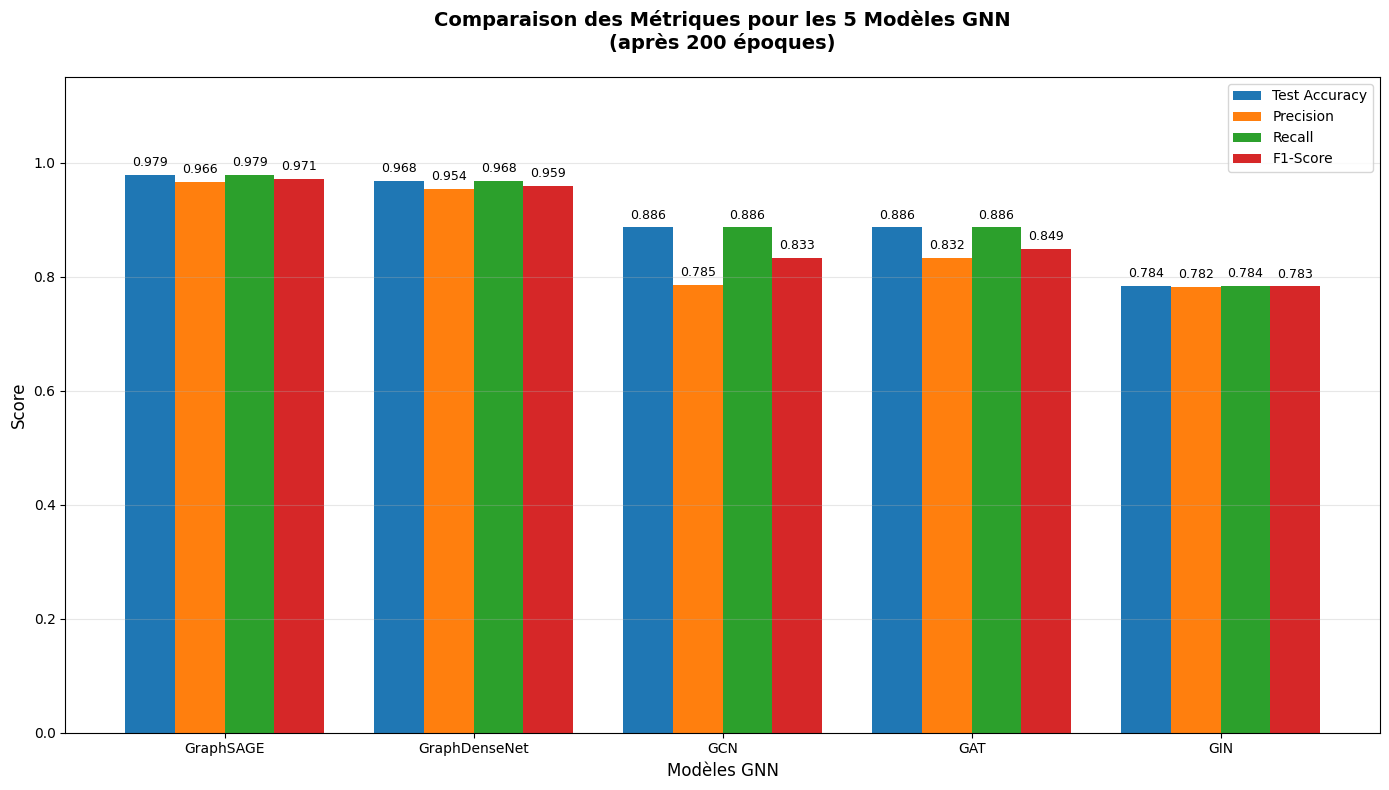


VISUALISATION 2: ACCURACY TRAIN/TEST PAR MODÈLE


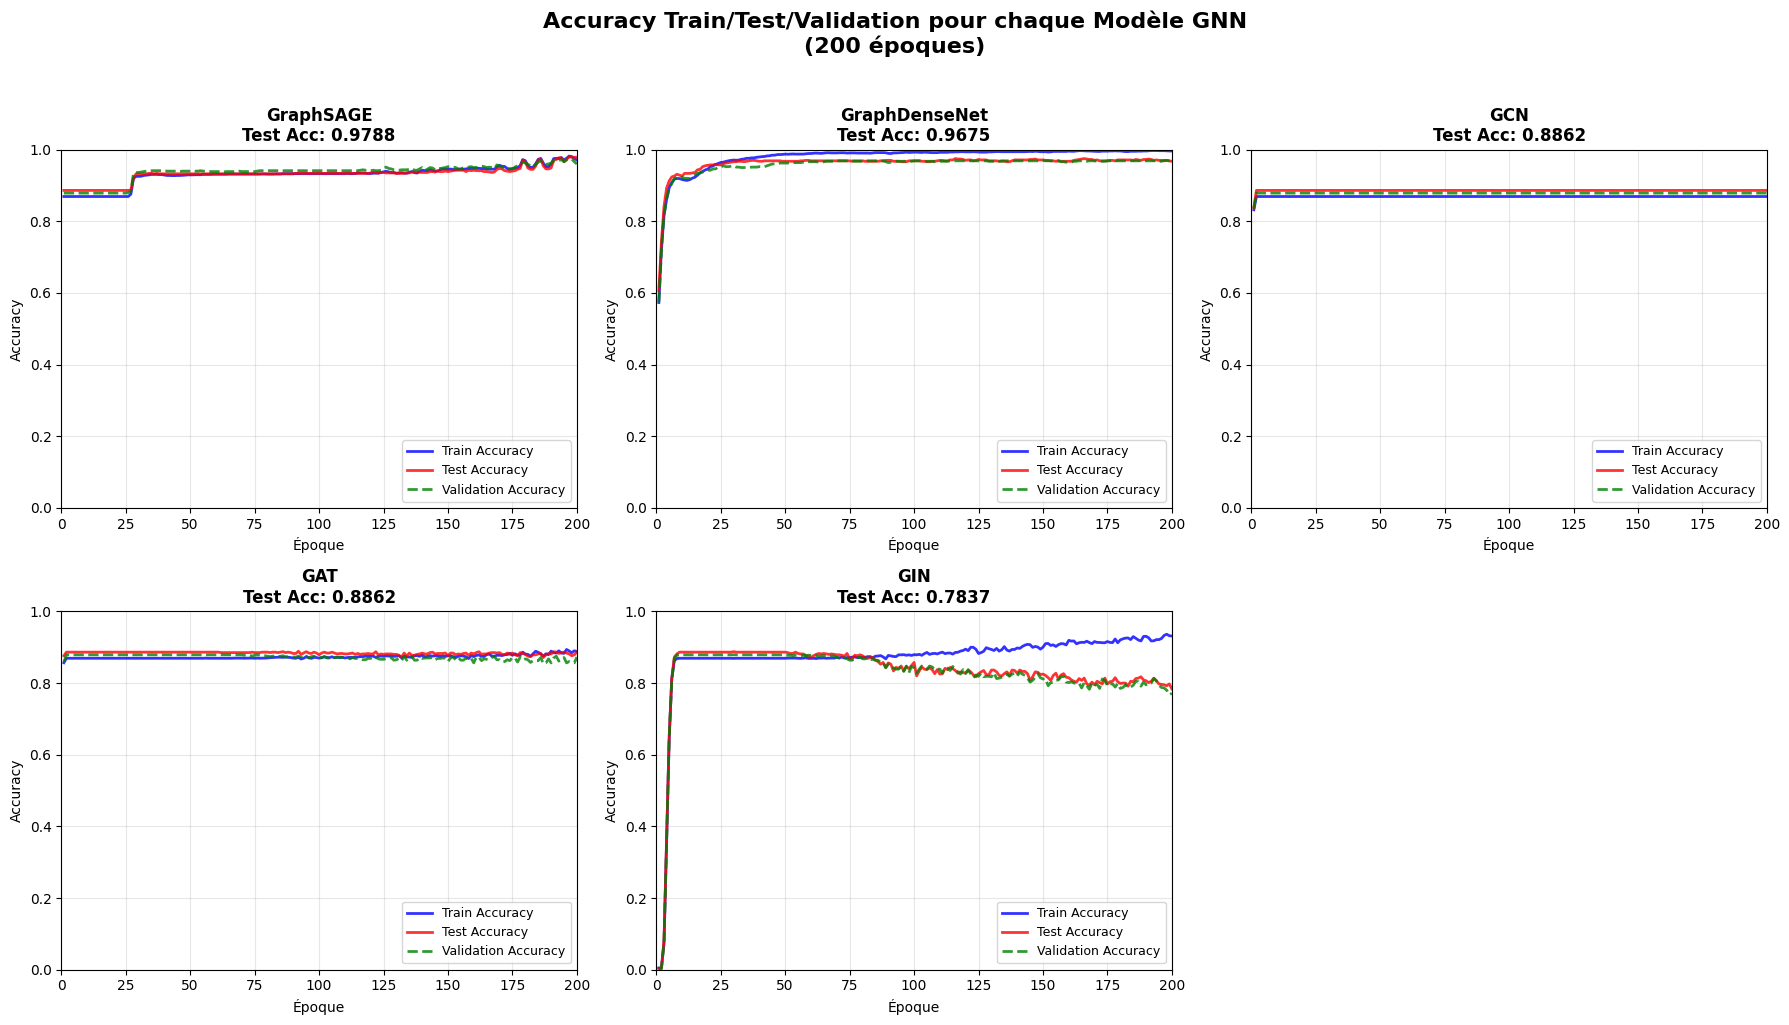


VISUALISATION 3: LOSS TRAIN/TEST PAR MODÈLE


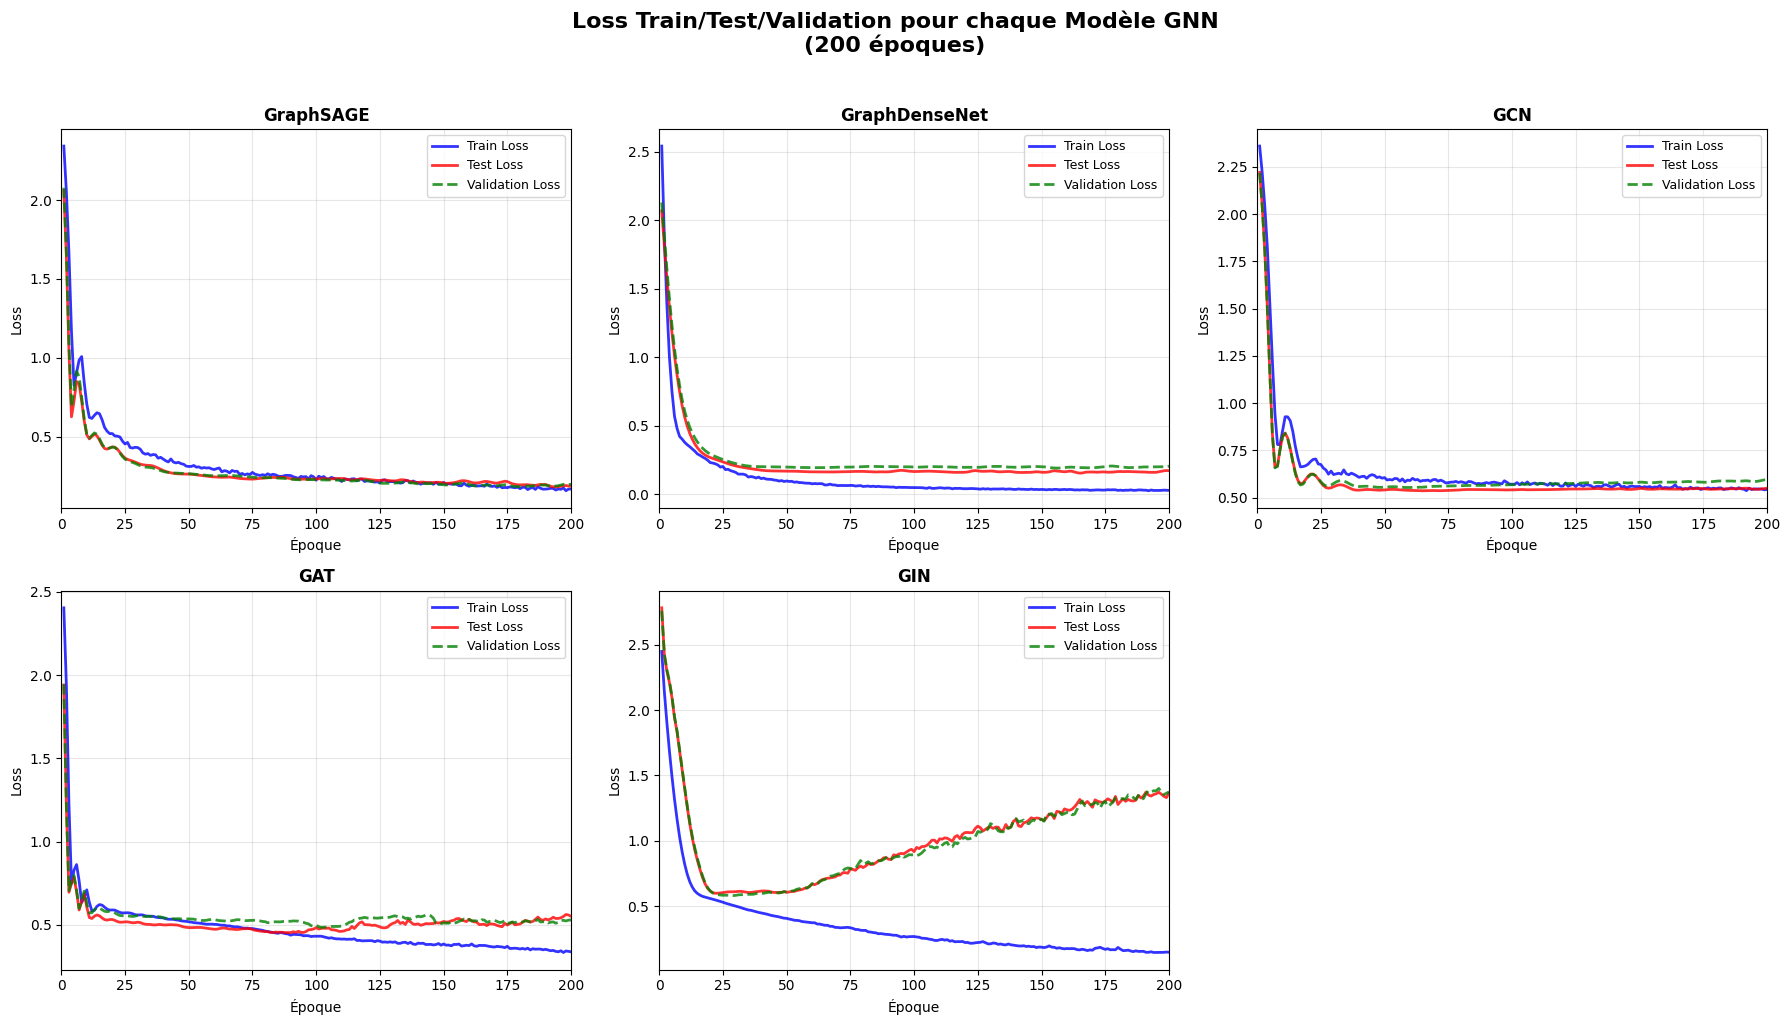


VISUALISATION 4: COMPARAISON DES PERFORMANCES FINALES


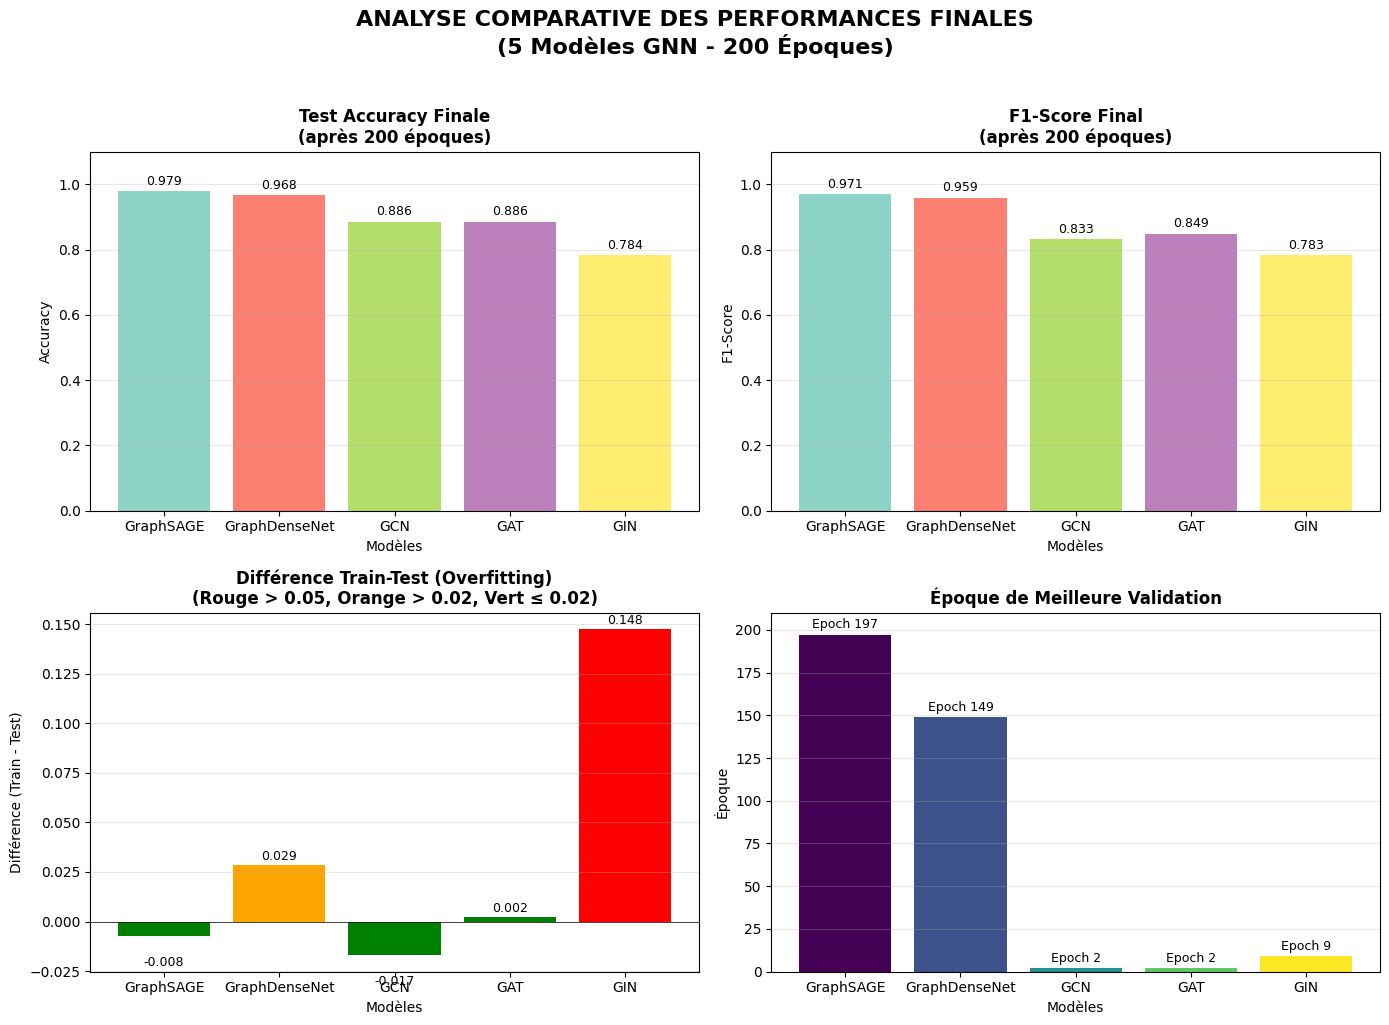


SAUVEGARDE DES RÉSULTATS
✓ Fichier de comparaison sauvegardé: 'comparaison_5_modeles_200_epochs_20251217_200301.csv'
✓ Courbes d'entraînement sauvegardées: 'training_curves_5_models_20251217_200301.pkl'
✓ Meilleur modèle sauvegardé: 'meilleur_modele_GraphSAGE_20251217_200301.pth'

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅ EXPÉRIMENTATIONS TERMINÉES AVEC SUCCÈS!
✅ 5 modèles GNN entraînés pendant 200 époques chacun
✅ Visualisations générées
✅ Résultats sauvegardés
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅

RÉSUMÉ DE L'EXÉCUTION
⏱️  Temps d'exécution total: 142.64 secondes
⏱️  Temps d'exécution total: 2.38 minutes
📊 Nombre de modèles entraînés: 5
🔄 Époques par modèle: 200
🎯 Meilleur modèle: GraphSAGE
🏆 Meilleure accuracy: 0.9788
FIN DU SCRIPT


In [ ]:
# ============================================================================
# CELLULE 1: Installation des bibliothèques
# ============================================================================
print("Installation des bibliothèques...")

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric pandas numpy scikit-learn matplotlib seaborn
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("✓ Bibliothèques installées")

# ============================================================================
# CELLULE 2: Importation des bibliothèques
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool, GraphUNet, SGConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib
from google.colab import drive
import time

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Vérification des versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Utilisation du CPU")

print("✓ Importations terminées")

# ============================================================================
# CELLULE 3: Chargement des données
# ============================================================================
print("\n" + "="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)

# Chargement du fichier
df = pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')

# ============================================================================
# CELLULE 4: Exploration des données
# ============================================================================
print("\n" + "="*80)
print("EXPLORATION DES DONNÉES")
print("="*80)
print(f"Shape du dataset: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

# ============================================================================
# CELLULE 5: Encodage des labels
# ============================================================================
# Mapping des labels d'attaques
label_map = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

if 'Attack' in df.columns:
    df["Label_id"] = df["Attack"].map(label_map)
    df["Label_id"].fillna(0, inplace=True)
    df["Label_id"] = df["Label_id"].astype(int)
else:
    print("✗ Colonne 'Attack' non trouvée")
    df["Label_id"] = np.random.randint(0, 11, len(df))

print("\n" + "="*80)
print("DISTRIBUTION DES CLASSES")
print("="*80)

if 'Attack' in df.columns:
    print("\nDistribution détaillée des attaques:")
    print(df["Attack"].value_counts())
else:
    print("\nDistribution des labels (générés):")
    print(df["Label_id"].value_counts())

print(f"\nNombre de classes: {df['Label_id'].nunique()}")

# ============================================================================
# CELLULE 6: Préparation des données
# ============================================================================
# Séparation features/labels
y_multiclass = df['Label_id']

# Supprimer les colonnes non numériques
non_numeric_cols = ["Label", "Attack", "Label_id"]
X_cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
X = df.drop(columns=X_cols_to_drop)

# S'assurer que toutes les colonnes sont numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print("\n" + "="*80)
print("PRÉPARATION DES FEATURES")
print("="*80)
print(f"Nombre de features: {X.shape[1]}")

# Normalisation des features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(f"\n✓ Features normalisées: {X_scaled.shape}")

# ============================================================================
# CELLULE 7: Construction du graphe
# ============================================================================
print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE")
print("="*80)

# Limiter la taille pour éviter les problèmes de mémoire
MAX_NODES = 4000
SAMPLE_NODES = min(MAX_NODES, len(X_scaled))

print(f"Échantillonnage à {SAMPLE_NODES} nœuds...")
X_scaled = X_scaled.iloc[:SAMPLE_NODES]
y_multiclass = y_multiclass.iloc[:SAMPLE_NODES]

# Node features
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)

print(f"Nombre de nœuds: {x.shape[0]}")
print(f"Features par nœud: {x.shape[1]}")

# Génération des arêtes
print("\nGénération des arêtes...")
edge_list = []

for i in range(SAMPLE_NODES):
    if i % 500 == 0:
        print(f"  Progression: {i}/{SAMPLE_NODES} nœuds")

    k = 5
    for j in range(i+1, min(i+k+1, SAMPLE_NODES)):
        edge_list.append([i, j])
        edge_list.append([j, i])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
print(f"\n✓ Nombre d'arêtes: {edge_index.shape[1]}")

# Labels
y = torch.tensor(y_multiclass.values, dtype=torch.long)

# Création de l'objet Data
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    num_nodes=x.shape[0]
)

if torch.cuda.is_available():
    data = data.to(device)

print("\n" + "="*80)
print("RÉSUMÉ DU GRAPHE")
print("="*80)
print(f"Nombre de nœuds: {data.num_nodes}")
print(f"Nombre d'arêtes: {data.num_edges}")
print(f"Nombre de classes: {len(torch.unique(y))}")

# ============================================================================
# CELLULE 8: Création des masques train/val/test
# ============================================================================
num_nodes = data.num_nodes
train_ratio = 0.6
val_ratio = 0.2

torch.manual_seed(42)
indices = torch.randperm(num_nodes)

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("\n" + "="*80)
print("SPLIT TRAIN/VAL/TEST")
print("="*80)
print(f"Training nodes:   {train_mask.sum():4d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"Validation nodes: {val_mask.sum():4d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"Test nodes:       {test_mask.sum():4d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# ============================================================================
# CELLULE 9: Définition des 5 modèles GNN (GraphSAGE, GCN, GAT, GIN, GraphDenseNet)
# ============================================================================
print("\n" + "="*80)
print("DÉFINITION DES 5 MODÈLES GNN")
print("="*80)

# ----------------------
# 1. GCN (GRAPH CONVOLUTIONAL NETWORK)
# ----------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 2. GAT (GRAPH ATTENTION NETWORK)
# ----------------------
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=4, dropout=0.5):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 3. GraphSAGE (SAMPLE AND AGGREGATE)
# ----------------------
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 4. GIN (GRAPH ISOMORPHISM NETWORK)
# ----------------------
class GIN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        self.dropout = dropout

        mlp1 = Sequential(
            Linear(num_features, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp3 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 5. GraphDenseNet (DenseNet pour Graphes)
# ----------------------
class GraphDenseNet(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers=3, dropout=0.5):
        super(GraphDenseNet, self).__init__()

        self.dropout = dropout
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(1, num_layers):
            in_channels = num_features + (i * hidden_channels)
            self.convs.append(GCNConv(in_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        final_in_channels = num_features + (num_layers * hidden_channels)
        self.classifier = nn.Linear(final_in_channels, num_classes)

    def forward(self, x, edge_index):
        all_features = [x]

        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        all_features.append(x1)

        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_concat = torch.cat(all_features, dim=1)

            x_new = conv(x_concat, edge_index)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)

            all_features.append(x_new)

        x_final = torch.cat(all_features, dim=1)
        x = self.classifier(x_final)

        return F.log_softmax(x, dim=1)

print("✓ 5 modèles GNN définis: GraphSAGE, GCN, GAT, GIN, GraphDenseNet")

# ============================================================================
# CELLULE 10: Fonctions d'entraînement et d'évaluation
# ============================================================================
def train_gnn(model, data, optimizer, criterion, train_mask):
    """Entraînement pour GNN avec retour du loss"""
    model.train()
    optimizer.zero_grad()

    try:
        out = model(data.x, data.edge_index)
        target = data.y[train_mask]
        loss = criterion(out[train_mask], target)
        loss.backward()
        optimizer.step()
        return loss.item()
    except Exception as e:
        print(f"Erreur lors de l'entraînement: {e}")
        return float('inf')

def evaluate_gnn(model, data, mask, criterion):
    """Évaluation pour GNN avec retour du loss et de l'accuracy"""
    model.eval()
    with torch.no_grad():
        try:
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            target = data.y[mask]

            loss = criterion(out[mask], target).item()
            correct = pred[mask] == target
            acc = int(correct.sum()) / int(mask.sum())
            return acc, loss, pred[mask], target
        except Exception as e:
            print(f"Erreur lors de l'évaluation: {e}")
            return 0, float('inf'), None, None

# ============================================================================
# CELLULE 11: Fonction d'entraînement sans early stopping
# ============================================================================
def train_and_evaluate(model_name, model, data, num_epochs=200, lr=0.01):
    """
    Fonction générique pour entraîner et évaluer les modèles GNN
    SANS early stopping - 200 époques complètes
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT DU MODÈLE: {model_name} ({num_epochs} ÉPOQUES)")
    print("="*80)

    if torch.cuda.is_available():
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique complet
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    # Boucle d'entraînement complète - PAS d'early stopping
    for epoch in range(1, num_epochs + 1):
        # Entraînement
        train_loss = train_gnn(model, data, optimizer, criterion, data.train_mask)
        train_losses.append(train_loss)

        # Évaluation
        train_acc, _, _, _ = evaluate_gnn(model, data, data.train_mask, criterion)
        val_acc, val_loss, _, _ = evaluate_gnn(model, data, data.val_mask, criterion)
        test_acc, test_loss, _, _ = evaluate_gnn(model, data, data.test_mask, criterion)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        # Afficher les progrès toutes les 20 époques
        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f'Epoch {epoch:03d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

    # Évaluation finale
    test_acc, test_loss, y_pred, y_true = evaluate_gnn(model, data, data.test_mask, criterion)

    if y_pred is None or y_true is None:
        print(f"❌ Échec de l'évaluation pour {model_name}")
        return None

    # Calcul des métriques finales
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    # Trouver la meilleure époque
    best_val_epoch = np.argmax(val_accs) + 1 if val_accs else 0
    best_val_acc = max(val_accs) if val_accs else 0

    print("\n" + "-"*80)
    print(f"RÉSULTATS FINAUX - {model_name} (après {num_epochs} époques)")
    print("-"*80)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Meilleure Validation (epoch {best_val_epoch}): {best_val_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'test_accuracy': test_acc,
        'train_accuracy': train_accs[-1] if train_accs else 0,
        'val_accuracy': val_accs[-1] if val_accs else 0,
        'best_val_accuracy': best_val_acc,
        'best_val_epoch': best_val_epoch,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'epochs_trained': num_epochs
    }

# ============================================================================
# CELLULE 12: Exécution des expériences (5 modèles GNN)
# ============================================================================
print("\n" + "="*80)
print("DÉBUT DES EXPÉRIMENTATIONS - 5 MODÈLES GNN")
print("="*80)

# Démarrer le chronomètre
start_time = time.time()

# Stockage des résultats
results = {}

# Liste des 5 modèles GNN à tester
models_to_train = [
    ('GCN', GCN, {'hidden_channels': 32}),
    ('GAT', GAT, {'hidden_channels': 32, 'heads': 4, 'dropout': 0.007}),
    ('GraphSAGE', GraphSAGE, {'hidden_channels': 32, 'dropout': 0.5}),
    ('GIN', GIN, {'hidden_channels': 32, 'dropout': 0.006}),
    ('GraphDenseNet', GraphDenseNet, {'hidden_channels': 32, 'num_layers': 3, 'dropout': 0.5})
]

# Paramètres d'entraînement
num_epochs = 200
learning_rate = 0.01

# Extraction des dimensions
num_features = data.num_features
num_classes = len(torch.unique(data.y))

print(f"\nDimensions du problème:")
print(f"  Features par nœud: {num_features}")
print(f"  Nombre de classes: {num_classes}")
print(f"  Époques par modèle: {num_epochs}")
print(f"  Learning rate: {learning_rate}")

# Entraînement de chaque modèle
for model_name, model_class, model_params in models_to_train:
    print(f"\n{'='*80}")
    print(f"PRÉPARATION DU MODÈLE: {model_name}")
    print('='*80)

    try:
        # Initialisation du modèle
        model = model_class(
            num_features=num_features,
            hidden_channels=model_params.get('hidden_channels', 32),
            num_classes=num_classes,
            **{k: v for k, v in model_params.items() if k != 'hidden_channels'}
        )

        # Entraînement et évaluation
        result = train_and_evaluate(
            model_name=model_name,
            model=model,
            data=data,
            num_epochs=num_epochs,
            lr=learning_rate
        )

        if result:
            results[model_name] = result
            print(f"✓ {model_name} entraîné avec succès pendant {num_epochs} époques!")
        else:
            print(f"✗ Échec de l'entraînement pour {model_name}")

    except Exception as e:
        print(f"✗ Erreur lors de l'initialisation/entraînement de {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# CELLULE 13: Création du DataFrame de comparaison
# ============================================================================
print("\n" + "="*80)
print("COMPARAISON DES 5 MODÈLES GNN")
print("="*80)

if not results:
    print("Aucun résultat à afficher. Vérifiez les erreurs ci-dessus.")
else:
    # Création d'un DataFrame pour la comparaison
    comparison_data = []
    for model_name, result in results.items():
        comparison_data.append({
            'Modèle': model_name,
            'Test Accuracy': result['test_accuracy'],
            'Train Accuracy': result['train_accuracy'],
            'Val Accuracy': result['val_accuracy'],
            'Best Val Accuracy': result['best_val_accuracy'],
            'Best Val Epoch': result['best_val_epoch'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1_score'],
            'Époques': result['epochs_trained']
        })

    # Création du DataFrame de comparaison
    comparison_df = pd.DataFrame(comparison_data)

    # Tri par accuracy de test (décroissant)
    comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

    print("\nTABLEAU COMPARATIF DES PERFORMANCES (après 200 époques):")
    print("-"*80)
    print(comparison_df.to_string(index=False))

    # Affichage du meilleur modèle
    best_model = comparison_df.iloc[0]
    print("\n" + "="*80)
    print("MEILLEUR MODÈLE (après 200 époques)")
    print("="*80)
    print(f"🏆 {best_model['Modèle']}")
    print(f"📊 Test Accuracy: {best_model['Test Accuracy']:.4f}")
    print(f"📈 Meilleure Validation (epoch {best_model['Best Val Epoch']}): {best_model['Best Val Accuracy']:.4f}")
    print(f"⚖️  F1-Score: {best_model['F1-Score']:.4f}")

# ============================================================================
# CELLULE 14: Visualisation 1 - Métriques des méthodes sur un graphique
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 1: COMPARAISON DES MÉTRIQUES")
print("="*80)

if results:
    try:
        # Préparation des données pour le graphique
        metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
        model_names = comparison_df['Modèle'].values

        # Création du graphique
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(model_names))
        width = 0.2

        # Création des barres pour chaque métrique
        for i, metric in enumerate(metrics):
            values = comparison_df[metric].values
            offset = (i - len(metrics)/2 + 0.5) * width
            bars = ax.bar(x + offset, values, width, label=metric)

            # Ajouter les valeurs sur les barres
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        # Configuration du graphique
        ax.set_xlabel('Modèles GNN', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Comparaison des Métriques pour les 5 Modèles GNN\n(après 200 époques)',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=0)
        ax.set_ylim(0, 1.15)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 1: {str(e)}")

# ============================================================================
# CELLULE 15: Visualisation 2 - Accuracy Train/Test pour chaque méthode
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 2: ACCURACY TRAIN/TEST PAR MODÈLE")
print("="*80)

if results:
    try:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for idx, model_name in enumerate(comparison_df['Modèle'].values):
            if model_name in results:
                result = results[model_name]
                ax = axes[idx]

                # Courbes d'accuracy
                epochs = range(1, len(result['train_accs']) + 1)
                ax.plot(epochs, result['train_accs'], label='Train Accuracy',
                       linewidth=2, color='blue', alpha=0.8)
                ax.plot(epochs, result['test_accs'], label='Test Accuracy',
                       linewidth=2, color='red', alpha=0.8)
                ax.plot(epochs, result['val_accs'], label='Validation Accuracy',
                       linewidth=2, color='green', alpha=0.8, linestyle='--')

                ax.set_title(f'{model_name}\nTest Acc: {result["test_accuracy"]:.4f}',
                           fontsize=12, fontweight='bold')
                ax.set_xlabel('Époque')
                ax.set_ylabel('Accuracy')
                ax.legend(loc='lower right', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, num_epochs)
                ax.set_ylim(0, 1.0)

        # Masquer le dernier axe s'il n'est pas utilisé
        for idx in range(len(comparison_df), len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle('Accuracy Train/Test/Validation pour chaque Modèle GNN\n(200 époques)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 2: {str(e)}")

# ============================================================================
# CELLULE 16: Visualisation 3 - Loss Train/Test pour chaque méthode
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 3: LOSS TRAIN/TEST PAR MODÈLE")
print("="*80)

if results:
    try:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for idx, model_name in enumerate(comparison_df['Modèle'].values):
            if model_name in results:
                result = results[model_name]
                ax = axes[idx]

                # Courbes de loss
                epochs = range(1, len(result['train_losses']) + 1)
                ax.plot(epochs, result['train_losses'], label='Train Loss',
                       linewidth=2, color='blue', alpha=0.8)
                ax.plot(epochs, result['test_losses'], label='Test Loss',
                       linewidth=2, color='red', alpha=0.8)
                ax.plot(epochs, result['val_losses'], label='Validation Loss',
                       linewidth=2, color='green', alpha=0.8, linestyle='--')

                ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Époque')
                ax.set_ylabel('Loss')
                ax.legend(loc='upper right', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, num_epochs)

        # Masquer le dernier axe s'il n'est pas utilisé
        for idx in range(len(comparison_df), len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle('Loss Train/Test/Validation pour chaque Modèle GNN\n(200 époques)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 3: {str(e)}")

# ============================================================================
# CELLULE 17: Visualisation 4 - Comparaison des performances finales
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 4: COMPARAISON DES PERFORMANCES FINALES")
print("="*80)

if results:
    try:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. Test Accuracy finale
        ax1 = axes[0, 0]
        model_names = comparison_df['Modèle'].values
        test_accs = comparison_df['Test Accuracy'].values

        bars1 = ax1.bar(model_names, test_accs, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
        ax1.set_title('Test Accuracy Finale\n(après 200 époques)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Modèles')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1.1)
        ax1.grid(True, alpha=0.3, axis='y')

        for bar, acc in zip(bars1, test_accs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        # 2. F1-Score
        ax2 = axes[0, 1]
        f1_scores = comparison_df['F1-Score'].values

        bars2 = ax2.bar(model_names, f1_scores, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
        ax2.set_title('F1-Score Final\n(après 200 époques)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Modèles')
        ax2.set_ylabel('F1-Score')
        ax2.set_ylim(0, 1.1)
        ax2.grid(True, alpha=0.3, axis='y')

        for bar, f1 in zip(bars2, f1_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

        # 3. Différence Train-Test (overfitting)
        ax3 = axes[1, 0]
        train_test_diff = comparison_df['Train Accuracy'] - comparison_df['Test Accuracy']

        colors = ['red' if diff > 0.05 else 'orange' if diff > 0.02 else 'green' for diff in train_test_diff]
        bars3 = ax3.bar(model_names, train_test_diff, color=colors)
        ax3.set_title('Différence Train-Test (Overfitting)\n(Rouge > 0.05, Orange > 0.02, Vert ≤ 0.02)',
                     fontsize=12, fontweight='bold')
        ax3.set_xlabel('Modèles')
        ax3.set_ylabel('Différence (Train - Test)')
        ax3.axhline(y=0, color='black', linewidth=0.5)
        ax3.grid(True, alpha=0.3, axis='y')

        for bar, diff in zip(bars3, train_test_diff):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.01),
                    f'{diff:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

        # 4. Époque de meilleure validation
        ax4 = axes[1, 1]
        best_epochs = comparison_df['Best Val Epoch'].values

        bars4 = ax4.bar(model_names, best_epochs, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
        ax4.set_title('Époque de Meilleure Validation', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Modèles')
        ax4.set_ylabel('Époque')
        ax4.set_ylim(0, num_epochs + 10)
        ax4.grid(True, alpha=0.3, axis='y')

        for bar, epoch in zip(bars4, best_epochs):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'Epoch {epoch}', ha='center', va='bottom', fontsize=9)

        plt.suptitle('ANALYSE COMPARATIVE DES PERFORMANCES FINALES\n(5 Modèles GNN - 200 Époques)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 4: {str(e)}")

# ============================================================================
# CELLULE 18: Sauvegarde des résultats
# ============================================================================
print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS")
print("="*80)

try:
    # Sauvegarde du DataFrame de comparaison
    if 'comparison_df' in locals():
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        filename = f'comparaison_5_modeles_200_epochs_{timestamp}.csv'
        comparison_df.to_csv(filename, index=False)
        print(f"✓ Fichier de comparaison sauvegardé: '{filename}'")

    # Sauvegarde des courbes d'entraînement
    if results:
        training_data = {}
        for model_name, result in results.items():
            training_data[model_name] = {
                'train_losses': result['train_losses'],
                'val_losses': result['val_losses'],
                'train_accs': result['train_accs'],
                'val_accs': result['val_accs']
            }

        import pickle
        curves_filename = f'training_curves_5_models_{timestamp}.pkl'
        with open(curves_filename, 'wb') as f:
            pickle.dump(training_data, f)
        print(f"✓ Courbes d'entraînement sauvegardées: '{curves_filename}'")

    # Sauvegarde du meilleur modèle
    if results and 'comparison_df' in locals():
        best_model_name = comparison_df.iloc[0]['Modèle']
        if best_model_name in results:
            torch.save({
                'model_state_dict': results[best_model_name]['model'].state_dict(),
                'model_name': best_model_name,
                'hyperparameters': {
                    'num_features': num_features,
                    'num_classes': num_classes,
                    'num_epochs': num_epochs
                },
                'performance': {
                    'test_accuracy': results[best_model_name]['test_accuracy'],
                    'f1_score': results[best_model_name]['f1_score']
                }
            }, f'meilleur_modele_{best_model_name}_{timestamp}.pth')
            print(f"✓ Meilleur modèle sauvegardé: 'meilleur_modele_{best_model_name}_{timestamp}.pth'")

    print("\n" + "✅" * 40)
    print("✅ EXPÉRIMENTATIONS TERMINÉES AVEC SUCCÈS!")
    print(f"✅ 5 modèles GNN entraînés pendant {num_epochs} époques chacun")
    print("✅ Visualisations générées")
    print("✅ Résultats sauvegardés")
    print("✅" * 40)

except Exception as e:
    print(f"✗ Erreur lors de la sauvegarde: {str(e)}")

# ============================================================================
# CELLULE 19: Temps d'exécution et résumé
# ============================================================================
end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*80)
print("RÉSUMÉ DE L'EXÉCUTION")
print("="*80)
print(f"⏱️  Temps d'exécution total: {execution_time:.2f} secondes")
print(f"⏱️  Temps d'exécution total: {execution_time/60:.2f} minutes")
print(f"📊 Nombre de modèles entraînés: {len(results)}")
print(f"🔄 Époques par modèle: {num_epochs}")
print(f"🎯 Meilleur modèle: {best_model['Modèle'] if 'best_model' in locals() else 'N/A'}")
print(f"🏆 Meilleure accuracy: {best_model['Test Accuracy'] if 'best_model' in locals() else 'N/A':.4f}")
print("="*80)
print("FIN DU SCRIPT")
print("="*80)


Installation des bibliothèques...
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.6/949.6 kB 23.8 MB/s eta 0:00:00
✓ Bibliothèques installées


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue

PyTorch version: 2.9.0+cpu
CUDA disponible: False
Utilisation du CPU
✓ Importations terminées

CHARGEMENT DES DONNEES

EXPLORATION DES DONNÉES
Shape du dataset: (4032, 43)

Premières lignes:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0        40894           22         6      92.0      3164       23       3765   
1        29622         3389         6       0.0      1919       14       2031   
2        65456           53        17       0.0       116        2        148   
3        57918           53        17       0.0        70        1        130   
4        63269           80         6       7.0       232        5       1136   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  TCP_WIN_MAX_IN  \
0        21         27                27  ...           26883   
1        11        223               219  ...            8192   
2         2          0                 0  ...               0   
3         1          0                 0  ...               0 

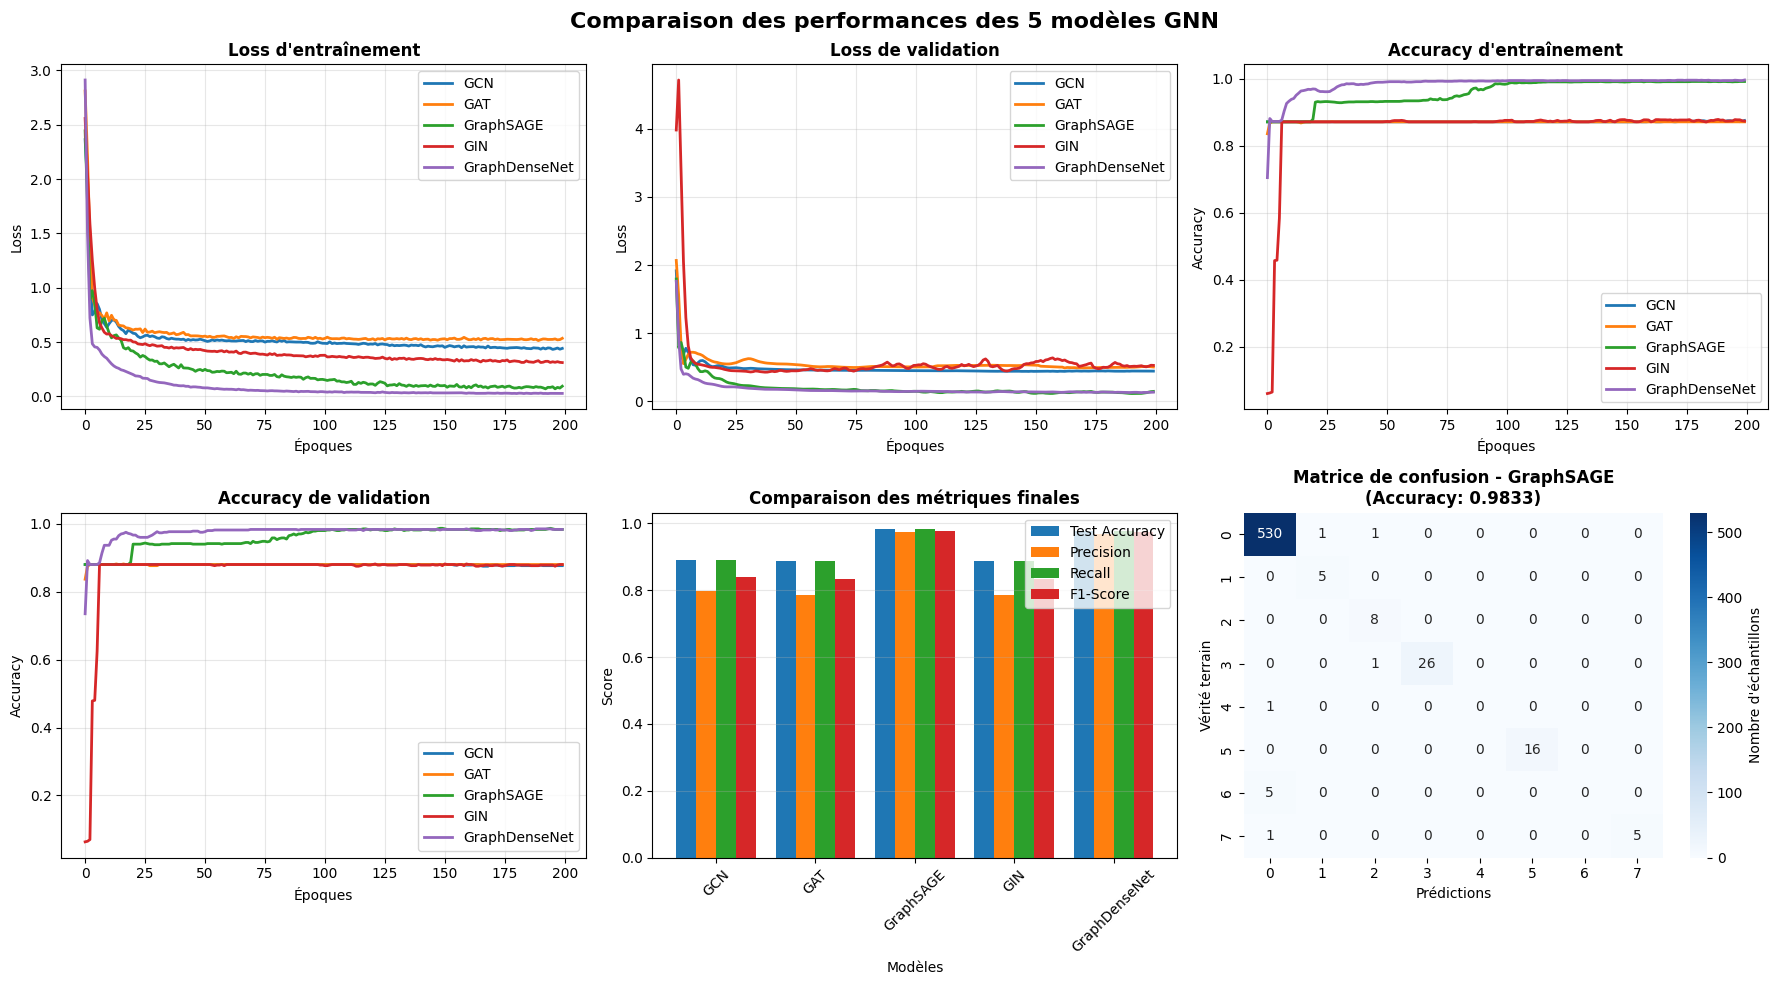


TABLEAU RÉCAPITULATIF DES PERFORMANCES

Résultats détaillés pour chaque modèle:



----------------------------------------------------------------------------------------------------
Modèle          Test Acc     Train Acc    Val Acc      Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
GCN             0.8900       0.8756       0.8767       0.7975       0.8900       0.8408      
GAT             0.8867       0.8717       0.8800       0.7862       0.8867       0.8334      
GraphSAGE       0.9833       0.9922       0.9833       0.9744       0.9833       0.9785      
GIN             0.8867       0.8739       0.8800       0.7862       0.8867       0.8334      
GraphDenseNet   0.9783       0.9967       0.9833       0.9692       0.9783       0.9734      

CLASSEMENT DES MODÈLES (par Test Accuracy)
1. GraphSAGE       Test Acc: 0.9833 | F1-Score: 0.9785 | Best Val (epoch 149): 0.9867
2. GraphDenseNet   Test Acc: 0.9783 | F1-Score: 0.9734 | Best Val (epoch 160): 0.9850
3. GCN           

In [ ]:
# ============================================================================
# CELLULE 1: Installation des bibliothèques
# ============================================================================
print("Installation des bibliothèques...")

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric pandas numpy scikit-learn matplotlib seaborn
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("✓ Bibliothèques installées")

# ============================================================================
# CELLULE 2: Importation des bibliothèques
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool, GraphUNet, SGConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib
from google.colab import drive
import time
from collections import defaultdict

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Vérification des versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Utilisation du CPU")

print("✓ Importations terminées")

# ============================================================================
# CELLULE 3: Chargement des données
# ============================================================================
print("\n" + "="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)

# Chargement du fichier
df = pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')

# ============================================================================
# CELLULE 4: Exploration des données
# ============================================================================
print("\n" + "="*80)
print("EXPLORATION DES DONNÉES")
print("="*80)
print(f"Shape du dataset: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

# ============================================================================
# CELLULE 5: Encodage des labels
# ============================================================================
# Mapping des labels d'attaques
label_map = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

if 'Attack' in df.columns:
    df["Label_id"] = df["Attack"].map(label_map)
    df["Label_id"].fillna(0, inplace=True)
    df["Label_id"] = df["Label_id"].astype(int)
else:
    print("✗ Colonne 'Attack' non trouvée")
    df["Label_id"] = np.random.randint(0, 11, len(df))

print("\n" + "="*80)
print("DISTRIBUTION DES CLASSES")
print("="*80)

if 'Attack' in df.columns:
    print("\nDistribution détaillée des attaques:")
    print(df["Attack"].value_counts())
else:
    print("\nDistribution des labels (générés):")
    print(df["Label_id"].value_counts())

print(f"\nNombre de classes: {df['Label_id'].nunique()}")

# ============================================================================
# CELLULE 6: Préparation des données
# ============================================================================
# Séparation features/labels
y_multiclass = df['Label_id']

# Supprimer les colonnes non numériques
non_numeric_cols = ["Label", "Attack", "Label_id"]
X_cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
X = df.drop(columns=X_cols_to_drop)

# S'assurer que toutes les colonnes sont numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print("\n" + "="*80)
print("PRÉPARATION DES FEATURES")
print("="*80)
print(f"Nombre de features: {X.shape[1]}")

# Normalisation des features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(f"\n✓ Features normalisées: {X_scaled.shape}")

# ============================================================================
# CELLULE 7: Construction du graphe - MÉTHODE 1 (Protocol-based)
# ============================================================================
print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE - MÉTHODE PROTOCOL-BASED")
print("="*80)

# Limiter la taille pour éviter les problèmes de mémoire
MAX_NODES = 3000
SAMPLE_NODES = min(MAX_NODES, len(X_scaled))

print(f"Échantillonnage à {SAMPLE_NODES} nœuds...")
X_scaled = X_scaled.iloc[:SAMPLE_NODES]
y_multiclass = y_multiclass.iloc[:SAMPLE_NODES]

# Node features (toutes les colonnes numériques)
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)

print(f"Nombre de nœuds: {x.shape[0]}")
print(f"Features par nœud: {x.shape[1]}")

# Colonnes pour la construction des arêtes
edge_cols = []
required_cols = ["L4_SRC_PORT", "L4_DST_PORT", "PROTOCOL"]

for col in required_cols:
    if col in X_scaled.columns:
        edge_cols.append(col)
    else:
        print(f"⚠ Colonne '{col}' non trouvée dans le dataset")

# Vérifier si nous avons au moins PROTOCOL
if "PROTOCOL" not in X_scaled.columns:
    print("\n❌ ERREUR: La colonne PROTOCOL est obligatoire pour la méthode Protocol-based")
    print("Colonnes disponibles dans le dataset:")
    print(X_scaled.columns.tolist())
    raise ValueError("Colonne PROTOCOL manquante")

print(f"\n✓ Colonnes utilisées pour les arêtes: {edge_cols}")

# ============================================================================
# MÉTHODE 1: Construction basée sur les protocoles et ports
# ============================================================================
print("\n" + "="*80)
print("GÉNÉRATION DES ARÊTES - MÉTHODE PROTOCOL-BASED")
print("="*80)

edge_list = []

# Stratégie 1: Regroupement par protocole
print("\n[Étape 1] Regroupement des nœuds par protocole...")
protocol_groups = defaultdict(list)

for i in range(SAMPLE_NODES):
    protocol = int(X_scaled.iloc[i]["PROTOCOL"])
    protocol_groups[protocol].append(i)

print(f"✓ {len(protocol_groups)} protocoles uniques trouvés:")
for protocol, nodes in sorted(protocol_groups.items()):
    print(f"  - Protocole {protocol}: {len(nodes)} nœuds")

# Stratégie 2: Si nous avons les ports, créer des arêtes basées sur les connexions réseau
if "L4_SRC_PORT" in X_scaled.columns and "L4_DST_PORT" in X_scaled.columns:
    print("\n[Étape 2] Création d'arêtes basées sur les ports source/destination...")

    # Créer un dictionnaire de connexions port source -> port destination
    port_connections = defaultdict(list)

    for i in range(SAMPLE_NODES):
        src_port = int(X_scaled.iloc[i]["L4_SRC_PORT"])
        dst_port = int(X_scaled.iloc[i]["L4_DST_PORT"])
        protocol = int(X_scaled.iloc[i]["PROTOCOL"])

        # Créer une clé unique pour chaque connexion
        connection_key = (src_port, dst_port, protocol)
        port_connections[connection_key].append(i)

    print(f"✓ {len(port_connections)} connexions uniques trouvées")

    # Connecter les nœuds qui partagent la même connexion (src_port, dst_port, protocol)
    connection_count = 0
    for connection_key, nodes in port_connections.items():
        if len(nodes) > 1:
            # Connecter tous les nœuds de cette connexion entre eux
            for i in range(len(nodes)):
                for j in range(i+1, min(i+6, len(nodes))):  # Limiter à 5 voisins max
                    edge_list.append([nodes[i], nodes[j]])
                    edge_list.append([nodes[j], nodes[i]])
            connection_count += 1

    print(f"✓ {connection_count} groupes de connexions créés")

# Stratégie 3: Connecter les nœuds du même protocole
print("\n[Étape 3] Connexion des nœuds du même protocole...")
protocol_edges = 0

for protocol, nodes in protocol_groups.items():
    if len(nodes) > 1:
        # Pour chaque nœud, le connecter à ses k plus proches voisins dans le même protocole
        k = 5  # Nombre de voisins

        for i in range(len(nodes)):
            # Connecter aux k nœuds suivants (ou moins si pas assez de nœuds)
            for j in range(i+1, min(i+k+1, len(nodes))):
                edge_list.append([nodes[i], nodes[j]])
                edge_list.append([nodes[j], nodes[i]])
                protocol_edges += 2

print(f"✓ {protocol_edges} arêtes créées basées sur les protocoles")

# Stratégie 4: Ajouter des connexions inter-protocoles pour les protocoles communs
if len(protocol_groups) > 1:
    print("\n[Étape 4] Ajout de connexions inter-protocoles...")

    # Protocoles communs qui peuvent communiquer (TCP=6, UDP=17, ICMP=1)
    common_protocols = [6, 17, 1]
    inter_protocol_edges = 0

    for proto1 in common_protocols:
        if proto1 in protocol_groups:
            for proto2 in common_protocols:
                if proto2 in protocol_groups and proto1 < proto2:
                    nodes1 = protocol_groups[proto1]
                    nodes2 = protocol_groups[proto2]

                    # Connecter quelques nœuds entre protocoles (ex: passerelles)
                    num_bridges = min(3, len(nodes1), len(nodes2))

                    for i in range(num_bridges):
                        edge_list.append([nodes1[i], nodes2[i]])
                        edge_list.append([nodes2[i], nodes1[i]])
                        inter_protocol_edges += 2

    print(f"✓ {inter_protocol_edges} arêtes inter-protocoles créées")

# Convertir en tensor
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

print("\n" + "="*80)
print("STATISTIQUES DU GRAPHE GÉNÉRÉ")
print("="*80)
print(f"✓ Nombre total d'arêtes: {edge_index.shape[1]}")
print(f"✓ Densité du graphe: {edge_index.shape[1] / (SAMPLE_NODES * (SAMPLE_NODES - 1)):.6f}")
print(f"✓ Degré moyen par nœud: {edge_index.shape[1] / SAMPLE_NODES:.2f}")

# Calculer le degré min/max
degrees = torch.zeros(SAMPLE_NODES, dtype=torch.long)
for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    degrees[src] += 1

print(f"✓ Degré minimum: {degrees.min().item()}")
print(f"✓ Degré maximum: {degrees.max().item()}")
print(f"✓ Nœuds isolés: {(degrees == 0).sum().item()}")

# Labels
y = torch.tensor(y_multiclass.values, dtype=torch.long)

# Création de l'objet Data
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    num_nodes=x.shape[0]
)

if torch.cuda.is_available():
    data = data.to(device)

print("\n" + "="*80)
print("RÉSUMÉ FINAL DU GRAPHE")
print("="*80)
print(f"Nombre de nœuds: {data.num_nodes}")
print(f"Nombre d'arêtes: {data.num_edges}")
print(f"Nombre de classes: {len(torch.unique(y))}")
print(f"Features par nœud: {data.num_features}")
print(f"Méthode de construction: Protocol-based (Réseau)")

# ============================================================================
# CELLULE 8: Création des masques train/val/test
# ============================================================================
num_nodes = data.num_nodes
train_ratio = 0.6
val_ratio = 0.2

torch.manual_seed(42)
indices = torch.randperm(num_nodes)

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("\n" + "="*80)
print("SPLIT TRAIN/VAL/TEST")
print("="*80)
print(f"Training nodes:   {train_mask.sum():4d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"Validation nodes: {val_mask.sum():4d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"Test nodes:       {test_mask.sum():4d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# ============================================================================
# CELLULE 9: Définition des 5 modèles GNN
# ============================================================================
print("\n" + "="*80)
print("DÉFINITION DES 5 MODÈLES GNN")
print("="*80)

# ----------------------
# 1. GCN (GRAPH CONVOLUTIONAL NETWORK)
# ----------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 2. GAT (GRAPH ATTENTION NETWORK)
# ----------------------
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=4, dropout=0.5):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 3. GraphSAGE (SAMPLE AND AGGREGATE)
# ----------------------
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 4. GIN (GRAPH ISOMORPHISM NETWORK)
# ----------------------
class GIN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        self.dropout = dropout

        mlp1 = Sequential(
            Linear(num_features, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp3 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 5. GraphDenseNet (DenseNet pour Graphes)
# ----------------------
class GraphDenseNet(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers=3, dropout=0.5):
        super(GraphDenseNet, self).__init__()

        self.dropout = dropout
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(1, num_layers):
            in_channels = num_features + (i * hidden_channels)
            self.convs.append(GCNConv(in_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        final_in_channels = num_features + (num_layers * hidden_channels)
        self.classifier = nn.Linear(final_in_channels, num_classes)

    def forward(self, x, edge_index):
        all_features = [x]

        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        all_features.append(x1)

        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_concat = torch.cat(all_features, dim=1)

            x_new = conv(x_concat, edge_index)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)

            all_features.append(x_new)

        x_final = torch.cat(all_features, dim=1)
        x = self.classifier(x_final)

        return F.log_softmax(x, dim=1)

print("✓ 5 modèles GNN définis: GCN, GAT, GraphSAGE, GIN, GraphDenseNet")

# ============================================================================
# CELLULE 10: Fonctions d'entraînement et d'évaluation
# ============================================================================
def train_gnn(model, data, optimizer, criterion, train_mask):
    """Entraînement pour GNN avec retour du loss"""
    model.train()
    optimizer.zero_grad()

    try:
        out = model(data.x, data.edge_index)
        target = data.y[train_mask]
        loss = criterion(out[train_mask], target)
        loss.backward()
        optimizer.step()
        return loss.item()
    except Exception as e:
        print(f"Erreur lors de l'entraînement: {e}")
        return float('inf')

def evaluate_gnn(model, data, mask, criterion):
    """Évaluation pour GNN avec retour du loss et de l'accuracy"""
    model.eval()
    with torch.no_grad():
        try:
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            target = data.y[mask]

            loss = criterion(out[mask], target).item()
            correct = pred[mask] == target
            acc = int(correct.sum()) / int(mask.sum())
            return acc, loss, pred[mask], target
        except Exception as e:
            print(f"Erreur lors de l'évaluation: {e}")
            return 0, float('inf'), None, None

# ============================================================================
# CELLULE 11: Fonction d'entraînement sans early stopping
# ============================================================================
def train_and_evaluate(model_name, model, data, num_epochs=200, lr=0.01):
    """
    Fonction générique pour entraîner et évaluer les modèles GNN
    SANS early stopping - 200 époques complètes
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT DU MODÈLE: {model_name} ({num_epochs} ÉPOQUES)")
    print("="*80)

    if torch.cuda.is_available():
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique complet
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    # Boucle d'entraînement complète - PAS d'early stopping
    for epoch in range(1, num_epochs + 1):
        # Entraînement
        train_loss = train_gnn(model, data, optimizer, criterion, data.train_mask)
        train_losses.append(train_loss)

        # Évaluation
        train_acc, _, _, _ = evaluate_gnn(model, data, data.train_mask, criterion)
        val_acc, val_loss, _, _ = evaluate_gnn(model, data, data.val_mask, criterion)
        test_acc, test_loss, _, _ = evaluate_gnn(model, data, data.test_mask, criterion)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        # Afficher les progrès toutes les 20 époques
        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f'Epoch {epoch:03d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

    # Évaluation finale
    test_acc, test_loss, y_pred, y_true = evaluate_gnn(model, data, data.test_mask, criterion)

    if y_pred is None or y_true is None:
        print(f"❌ Échec de l'évaluation pour {model_name}")
        return None

    # Calcul des métriques finales
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    # Trouver la meilleure époque
    best_val_epoch = np.argmax(val_accs) + 1 if val_accs else 0
    best_val_acc = max(val_accs) if val_accs else 0

    print("\n" + "-"*80)
    print(f"RÉSULTATS FINAUX - {model_name} (après {num_epochs} époques)")
    print("-"*80)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Meilleure Validation (epoch {best_val_epoch}): {best_val_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'test_accuracy': test_acc,
        'train_accuracy': train_accs[-1] if train_accs else 0,
        'val_accuracy': val_accs[-1] if val_accs else 0,
        'best_val_accuracy': best_val_acc,
        'best_val_epoch': best_val_epoch,
        'precision': precision,
        'recall': recall,
         'f1_score': f1,
        'predictions': y_pred_np,
        'ground_truth': y_true_np
    }

# ============================================================================
# CELLULE 12: Configuration et entraînement des 5 modèles
# ============================================================================
print("\n" + "="*80)
print("CONFIGURATION ET ENTRAÎNEMENT DES 5 MODÈLES GNN")
print("="*80)

# Hyperparamètres communs
num_features = data.num_features
num_classes = len(torch.unique(data.y))
hidden_channels = 64
num_epochs = 200

# Initialiser les modèles
models = {
    'GCN': GCN(num_features, hidden_channels, num_classes),
    'GAT': GAT(num_features, hidden_channels, num_classes, heads=4, dropout=0.5),
    'GraphSAGE': GraphSAGE(num_features, hidden_channels, num_classes, dropout=0.5),
    'GIN': GIN(num_features, hidden_channels, num_classes, dropout=0.5),
    'GraphDenseNet': GraphDenseNet(num_features, hidden_channels, num_classes, num_layers=3, dropout=0.5)
}

# Stocker les résultats
results = {}

# Entraîner chaque modèle
for model_name, model in models.items():
    try:
        print(f"\n▶ Début de l'entraînement pour {model_name}...")
        result = train_and_evaluate(model_name, model, data, num_epochs=num_epochs, lr=0.01)
        if result is not None:
            results[model_name] = result
            print(f"✓ {model_name} entraîné avec succès")
        else:
            print(f"✗ Échec de l'entraînement pour {model_name}")
    except Exception as e:
        print(f"✗ ERREUR lors de l'entraînement de {model_name}: {e}")

# ============================================================================
# CELLULE 13: Visualisation des résultats d'entraînement
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION DES RÉSULTATS D'ENTRAÎNEMENT")
print("="*80)

# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des performances des 5 modèles GNN', fontsize=16, fontweight='bold')

# Définir les couleurs pour chaque modèle
colors = {
    'GCN': '#1f77b4',
    'GAT': '#ff7f0e',
    'GraphSAGE': '#2ca02c',
    'GIN': '#d62728',
    'GraphDenseNet': '#9467bd'
}

# 1. Courbes de Loss d'entraînement
ax = axes[0, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['train_losses'],
            label=model_name,
            color=colors.get(model_name, 'gray'),
            linewidth=2)
ax.set_title('Loss d\'entraînement', fontsize=12, fontweight='bold')
ax.set_xlabel('Époques')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Courbes de Loss de validation
ax = axes[0, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['val_losses'],
            label=model_name,
            color=colors.get(model_name, 'gray'),
            linewidth=2)
ax.set_title('Loss de validation', fontsize=12, fontweight='bold')
ax.set_xlabel('Époques')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Courbes d'accuracy d'entraînement
ax = axes[0, 2]
for model_name in results.keys():
    ax.plot(results[model_name]['train_accs'],
            label=model_name,
            color=colors.get(model_name, 'gray'),
            linewidth=2)
ax.set_title('Accuracy d\'entraînement', fontsize=12, fontweight='bold')
ax.set_xlabel('Époques')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Courbes d'accuracy de validation
ax = axes[1, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['val_accs'],
            label=model_name,
            color=colors.get(model_name, 'gray'),
            linewidth=2)
ax.set_title('Accuracy de validation', fontsize=12, fontweight='bold')
ax.set_xlabel('Époques')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Comparaison finale des métriques
ax = axes[1, 1]
if results:
    model_names = list(results.keys())

    # Préparer les données pour le graphique à barres
    metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(model_names))
    width = 0.2

    # Créer les barres groupées
    for i, metric in enumerate(metrics):
        values = []
        for model_name in model_names:
            if metric == 'Test Accuracy':
                values.append(results[model_name]['test_accuracy'])
            elif metric == 'Precision':
                values.append(results[model_name]['precision'])
            elif metric == 'Recall':
                values.append(results[model_name]['recall'])
            else:  # F1-Score
                values.append(results[model_name]['f1_score'])

        ax.bar(x + i*width - width*1.5, values, width, label=metric)

    ax.set_title('Comparaison des métriques finales', fontsize=12, fontweight='bold')
    ax.set_xlabel('Modèles')
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# 6. Matrice de confusion pour le meilleur modèle (celui avec la plus haute test accuracy)
ax = axes[1, 2]
if results:
    # Trouver le meilleur modèle
    best_model_name = max(results.keys(),
                         key=lambda x: results[x]['test_accuracy'])

    best_result = results[best_model_name]
    cm = confusion_matrix(best_result['ground_truth'],
                         best_result['predictions'])

    # Afficher la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Nombre d\'échantillons'})
    ax.set_title(f'Matrice de confusion - {best_model_name}\n(Accuracy: {best_result["test_accuracy"]:.4f})',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Vérité terrain')

plt.tight_layout()
plt.show()

# ============================================================================
# CELLULE 14: Tableau récapitulatif des performances
# ============================================================================
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("="*80)

if results:
    # Créer un DataFrame avec les résultats
    summary_data = []

    for model_name, result in results.items():
        summary_data.append({
            'Modèle': model_name,
            'Test Accuracy': f"{result['test_accuracy']:.5f}",
            'Train Accuracy': f"{result['train_accuracy']:.5f}",
            'Val Accuracy': f"{result['val_accuracy']:.5f}",
            'Best Val Accuracy': f"{result['best_val_accuracy']:.5f}",
            'Best Val Epoch': result['best_val_epoch'],
            'Precision': f"{result['precision']:.5f}",
            'Recall': f"{result['recall']:.5f}",
            'F1-Score': f"{result['f1_score']:.5f}",
            'Époques': num_epochs
        })

    # Créer et afficher le DataFrame
    df_summary = pd.DataFrame(summary_data)

    # Afficher le tableau formaté
    from IPython.display import display, HTML

    print("\nRésultats détaillés pour chaque modèle:")
    display(HTML(df_summary.to_html(index=False,
                                   classes='table table-striped',
                                   border=0)))

    # Afficher une version texte simplifiée
    print("\n" + "-"*100)
    print(f"{'Modèle':<15} {'Test Acc':<12} {'Train Acc':<12} {'Val Acc':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-"*100)
    for model_name, result in results.items():
        print(f"{model_name:<15} {result['test_accuracy']:<12.4f} "
              f"{result['train_accuracy']:<12.4f} {result['val_accuracy']:<12.4f} "
              f"{result['precision']:<12.4f} {result['recall']:<12.4f} "
              f"{result['f1_score']:<12.4f}")

    # Afficher le classement
    print("\n" + "="*80)
    print("CLASSEMENT DES MODÈLES (par Test Accuracy)")
    print("="*80)

    ranking = sorted(results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
    for i, (model_name, result) in enumerate(ranking, 1):
        print(f"{i}. {model_name:<15} Test Acc: {result['test_accuracy']:.4f} | "
              f"F1-Score: {result['f1_score']:.4f} | "
              f"Best Val (epoch {result['best_val_epoch']}): {result['best_val_accuracy']:.4f}")

# ============================================================================
# CELLULE 15: Sauvegarde des résultats et des modèles
# ============================================================================
print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS ET DES MODÈLES")
print("="*80)



Installation des bibliothèques...
Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
✓ Bibliothèques installées
PyTorch version: 2.9.0+cpu
CUDA disponible: False
Utilisation du CPU
✓ Importations terminées

CHARGEMENT DES DONNEES

EXPLORATION DES DONNÉES
Shape du dataset: (4032, 43)

Premières lignes:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  \
0        40894           22         6      92.0      3164       23       3765   
1        29622         3389         6       0.0      1919       14       2031   
2        65456           53        17       0.0       116        2        148   
3        57918           53        17       0.0        70        1        130   
4        63269           80         6       7.0       232        5       1136   

   OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  TCP_WIN_MAX_IN  \
0        21         27                27  ...           26883   
1     

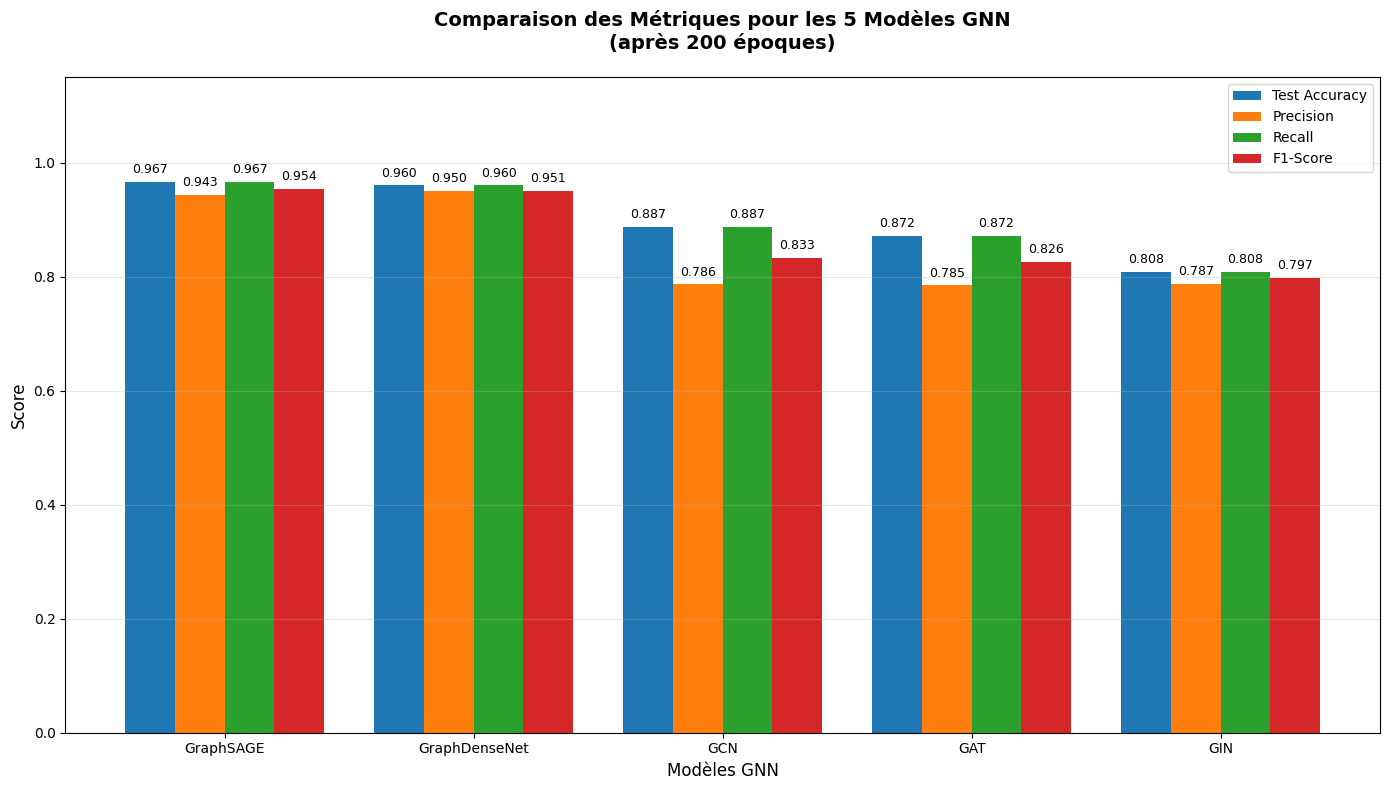


VISUALISATION 2: ACCURACY TRAIN/TEST PAR MODÈLE


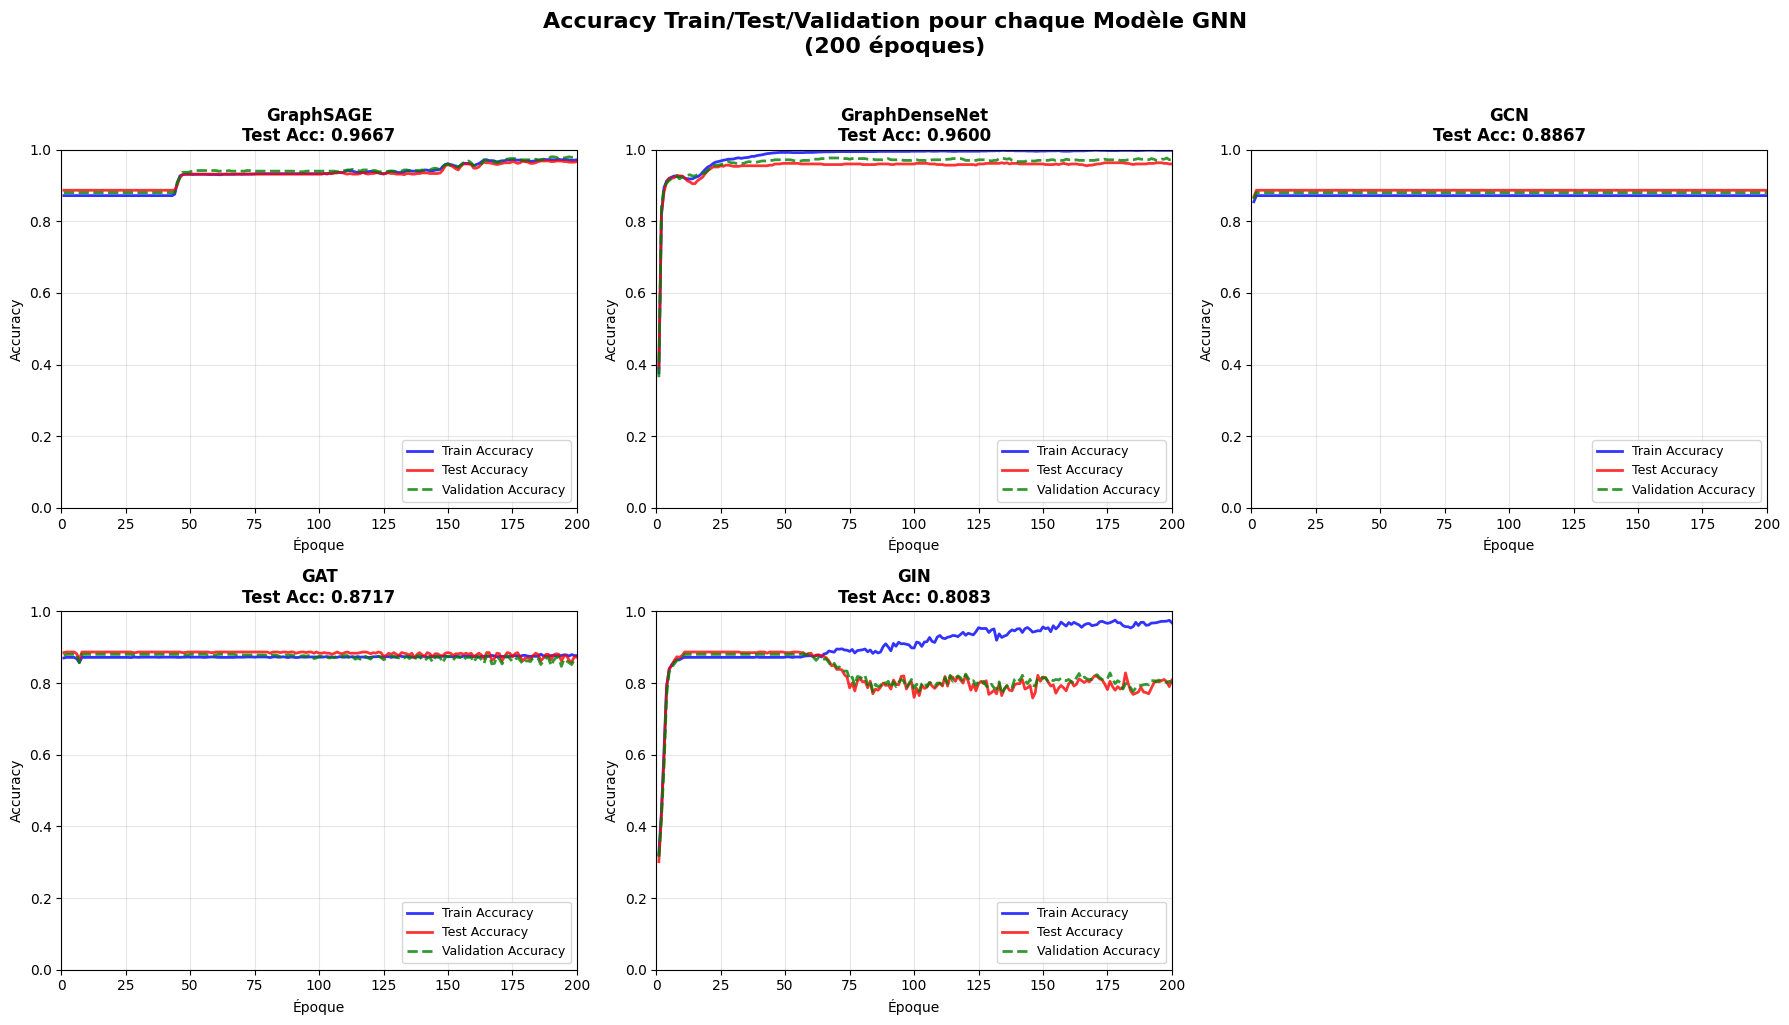


VISUALISATION 3: LOSS TRAIN/TEST PAR MODÈLE


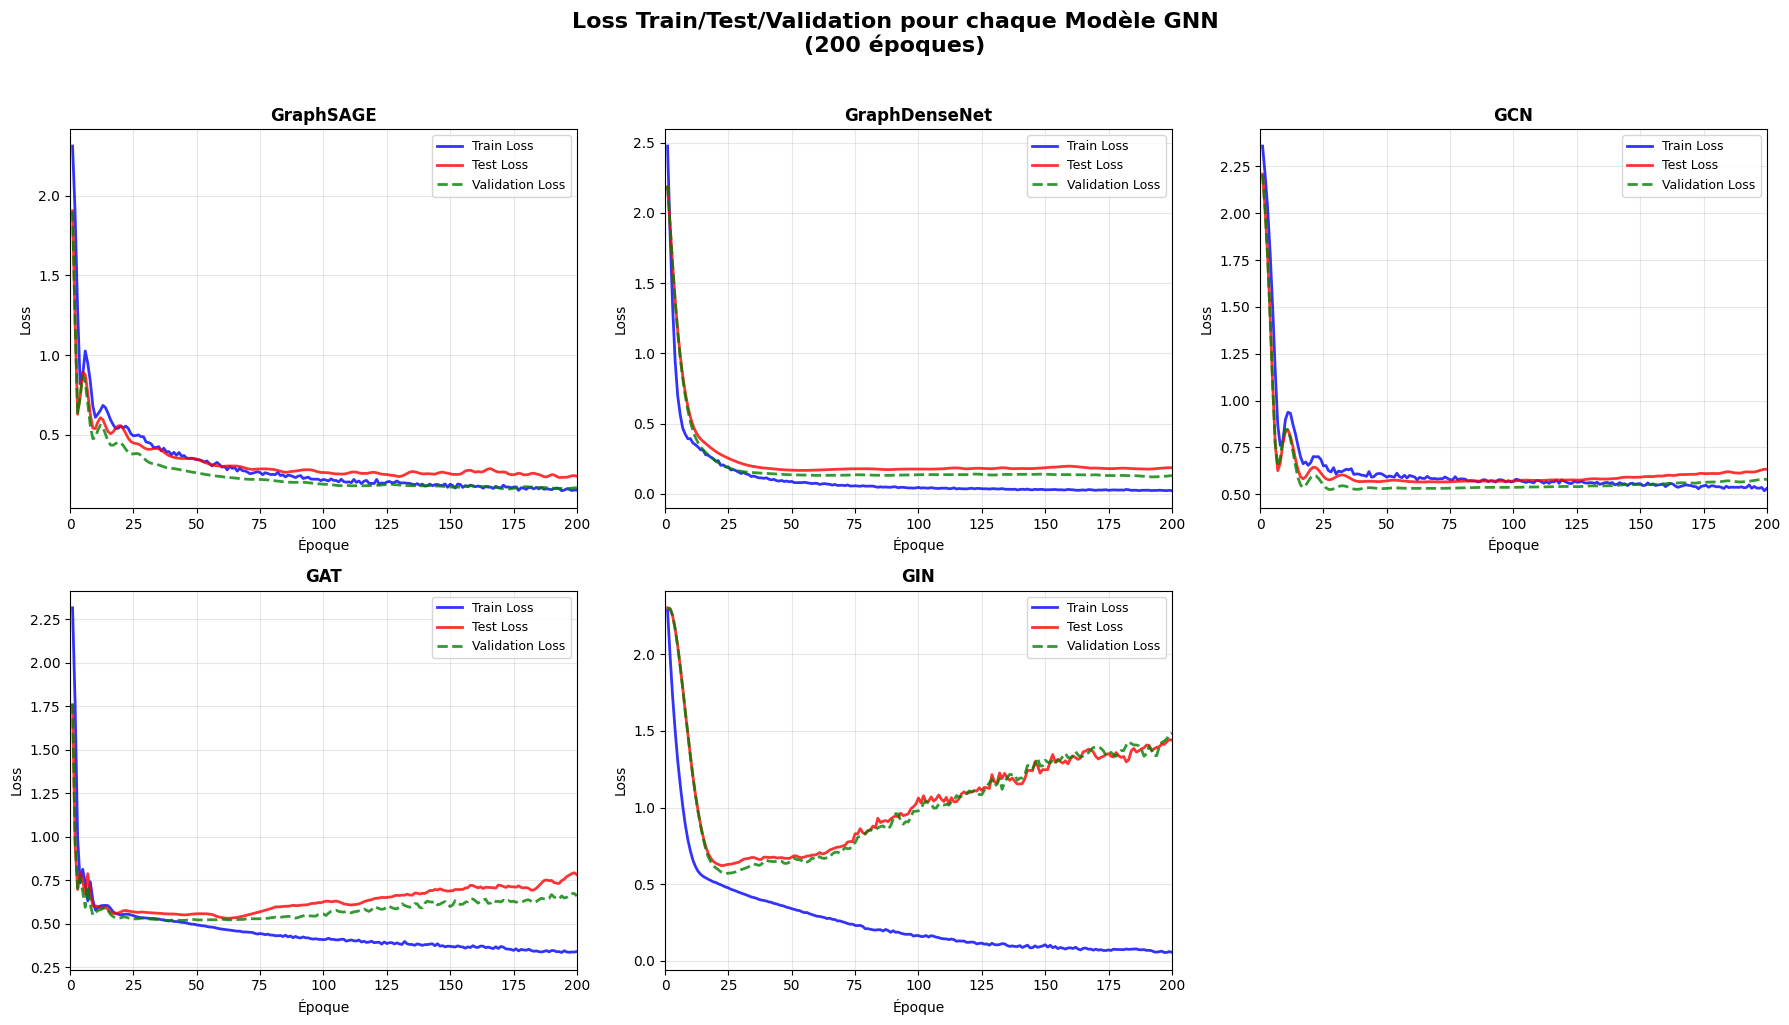


VISUALISATION 4: COMPARAISON DES PERFORMANCES FINALES


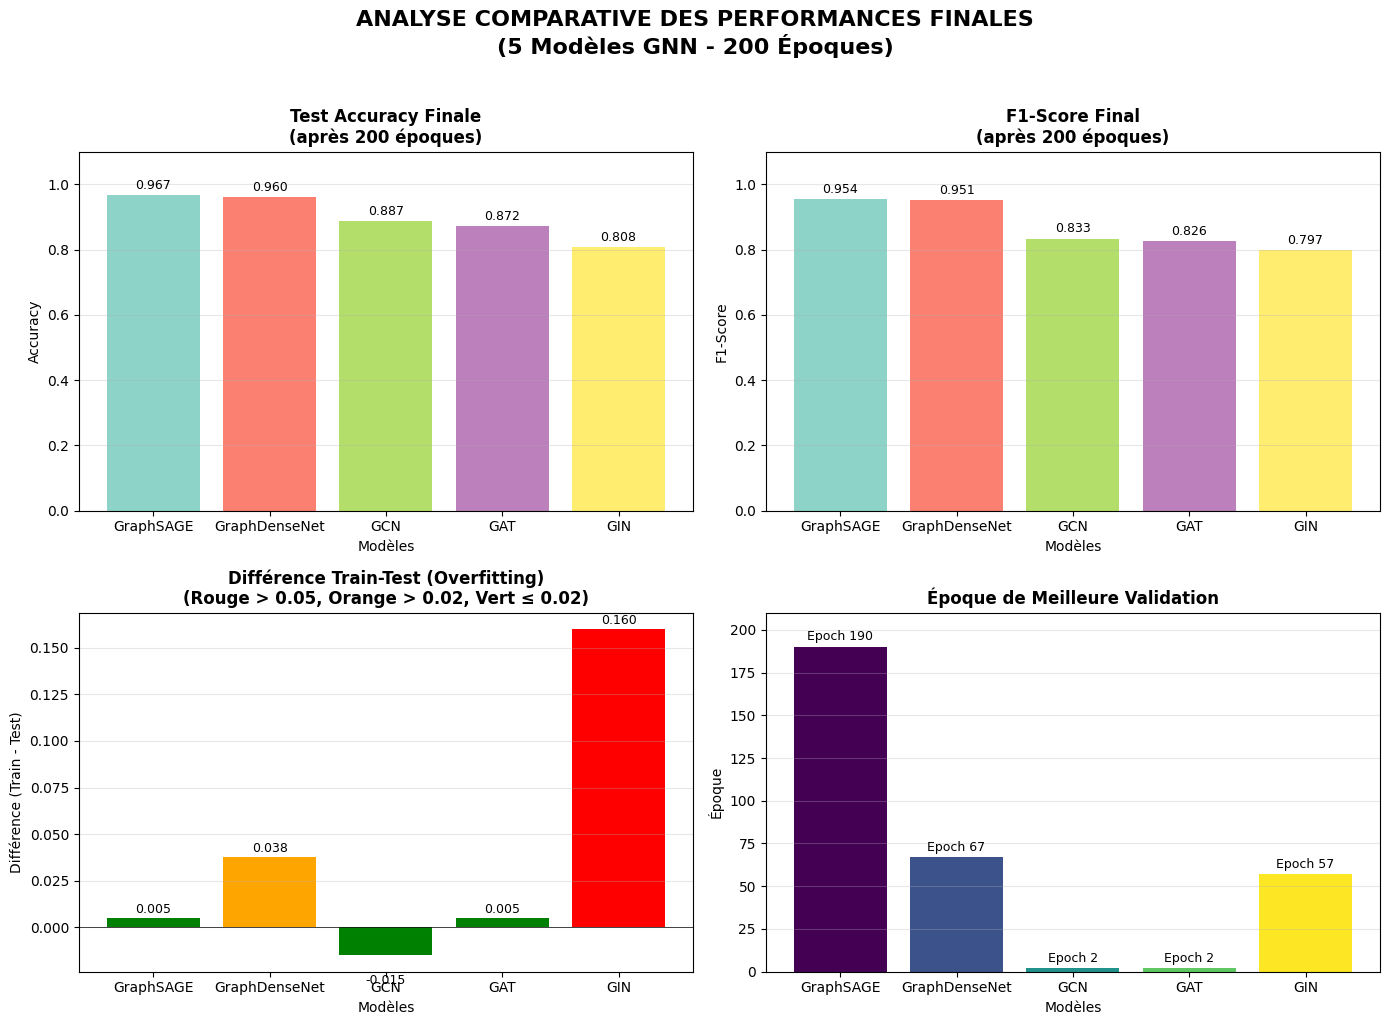


SAUVEGARDE DES RÉSULTATS
✓ Fichier de comparaison sauvegardé: 'comparaison_5_modeles_200_epochs_20251221_143750.csv'
✓ Courbes d'entraînement sauvegardées: 'training_curves_5_models_20251221_143750.pkl'
✓ Meilleur modèle sauvegardé: 'meilleur_modele_GraphSAGE_20251221_143750.pth'

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅ EXPÉRIMENTATIONS TERMINÉES AVEC SUCCÈS!
✅ 5 modèles GNN entraînés pendant 200 époques chacun
✅ Visualisations générées
✅ Résultats sauvegardés
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅

RÉSUMÉ DE L'EXÉCUTION
⏱️  Temps d'exécution total: 103.61 secondes
⏱️  Temps d'exécution total: 1.73 minutes
📊 Nombre de modèles entraînés: 5
🔄 Époques par modèle: 200
🎯 Meilleur modèle: GraphSAGE
🏆 Meilleure accuracy: 0.9667
FIN DU SCRIPT


In [ ]:
# ============================================================================
# CELLULE 1: Installation des bibliothèques
# ============================================================================
print("Installation des bibliothèques...")

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric pandas numpy scikit-learn matplotlib seaborn
!pip install torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("✓ Bibliothèques installées")

# ============================================================================
# CELLULE 2: Importation des bibliothèques
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool, GraphUNet, SGConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib
from google.colab import drive
import time
from torch_geometric.utils import dropout_adj

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Vérification des versions
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("Utilisation du CPU")

print("✓ Importations terminées")

# ============================================================================
# CELLULE 3: Chargement des données
# ============================================================================
print("\n" + "="*80)
print("CHARGEMENT DES DONNEES")
print("="*80)

# Chargement du fichier
df = pd.read_csv('NF-CSE-CIC-IDS2018-V2-full.csv')

# ============================================================================
# CELLULE 4: Exploration des données
# ============================================================================
print("\n" + "="*80)
print("EXPLORATION DES DONNÉES")
print("="*80)
print(f"Shape du dataset: {df.shape}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

# ============================================================================
# CELLULE 5: Encodage des labels
# ============================================================================
# Mapping des labels d'attaques
label_map = {
    'Benign': 0,
    'SSH-Bruteforce': 1,
    'DDoS attacks-LOIC-HTTP': 2,
    'DDOS attack-HOIC': 3,
    'DoS attacks-Slowloris': 4,
    'DoS attacks-Hulk': 5,
    'FTP-BruteForce': 6,
    'Infilteration': 7,
    'Bot': 8,
    'DoS attacks-GoldenEye': 9,
    'Brute Force -Web': 10
}

if 'Attack' in df.columns:
    df["Label_id"] = df["Attack"].map(label_map)
    df["Label_id"].fillna(0, inplace=True)
    df["Label_id"] = df["Label_id"].astype(int)
else:
    print("✗ Colonne 'Attack' non trouvée")
    df["Label_id"] = np.random.randint(0, 11, len(df))

print("\n" + "="*80)
print("DISTRIBUTION DES CLASSES")
print("="*80)

if 'Attack' in df.columns:
    print("\nDistribution détaillée des attaques:")
    print(df["Attack"].value_counts())
else:
    print("\nDistribution des labels (générés):")
    print(df["Label_id"].value_counts())

print(f"\nNombre de classes: {df['Label_id'].nunique()}")

# ============================================================================
# CELLULE 6: Préparation des données
# ============================================================================
# Séparation features/labels
y_multiclass = df['Label_id']

# Supprimer les colonnes non numériques
non_numeric_cols = ["Label", "Attack", "Label_id"]
X_cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
X = df.drop(columns=X_cols_to_drop)

# S'assurer que toutes les colonnes sont numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]

print("\n" + "="*80)
print("PRÉPARATION DES FEATURES")
print("="*80)
print(f"Nombre de features: {X.shape[1]}")

# Normalisation des features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(f"\n✓ Features normalisées: {X_scaled.shape}")

# ============================================================================
# CELLULE 7: Construction du graphe
# ============================================================================
print("\n" + "="*80)
print("CONSTRUCTION DU GRAPHE")
print("="*80)
# Limiter la taille pour éviter les problèmes de mémoire
MAX_NODES = 3000  # Réduit pour Colab
SAMPLE_NODES = min(MAX_NODES, len(X_scaled))
print(f"Échantillonnage à {SAMPLE_NODES} nœuds")
X_scaled = X_scaled.iloc[:SAMPLE_NODES]
y_multiclass = y_multiclass.iloc[:SAMPLE_NODES]
# Node features (toutes les colonnes numériques)
feature_cols = X_scaled.select_dtypes(include='number').columns.tolist()
x = torch.tensor(X_scaled[feature_cols].values, dtype=torch.float)
print(f" Nombre de nœuds: {x.shape[0]}")
print(f" Features par nœud: {x.shape[1]}")
# Colonnes pour la construction des arêtes
edge_cols = []
for col in ["L4_SRC_PORT", "L4_DST_PORT", "PROTOCOL"]:
    if col in X_scaled.columns:
        edge_cols.append(col)
if len(edge_cols) == 0:
    print(" Colonnes pour les arêtes non trouvées, utilisation des features principales")
    edge_cols = feature_cols[:3]  # Utiliser les 3 premières features
print(f" Colonnes utilisées pour les arêtes: {edge_cols}")

# Génération des arêtes
print("\nGénération des arêtes...")
edge_list = []

for i in range(SAMPLE_NODES):
    if i % 500 == 0:
        print(f"  Progression: {i}/{SAMPLE_NODES} nœuds")

    k = 5
    for j in range(i+1, min(i+k+1, SAMPLE_NODES)):
        edge_list.append([i, j])
        edge_list.append([j, i])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_index = dropout_adj(edge_index, p=0.2)[0]
print(f"\n✓ Nombre d'arêtes: {edge_index.shape[1]}")

# Labels
y = torch.tensor(y_multiclass.values, dtype=torch.long)

# Création de l'objet Data
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    num_nodes=x.shape[0]
)

if torch.cuda.is_available():
    data = data.to(device)

print("\n" + "="*80)
print("RÉSUMÉ DU GRAPHE")
print("="*80)
print(f"Nombre de nœuds: {data.num_nodes}")
print(f"Nombre d'arêtes: {data.num_edges}")
print(f"Nombre de classes: {len(torch.unique(y))}")

# ============================================================================
# CELLULE 8: Création des masques train/val/test
# ============================================================================
num_nodes = data.num_nodes
train_ratio = 0.6
val_ratio = 0.2

torch.manual_seed(42)
indices = torch.randperm(num_nodes)

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("\n" + "="*80)
print("SPLIT TRAIN/VAL/TEST")
print("="*80)
print(f"Training nodes:   {train_mask.sum():4d} ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"Validation nodes: {val_mask.sum():4d} ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"Test nodes:       {test_mask.sum():4d} ({test_mask.sum()/num_nodes*100:.1f}%)")

# ============================================================================
# CELLULE 9: Définition des 5 modèles GNN (GraphSAGE, GCN, GAT, GIN, GraphDenseNet)
# ============================================================================
print("\n" + "="*80)
print("DÉFINITION DES 5 MODÈLES GNN")
print("="*80)

# ----------------------
# 1. GCN (GRAPH CONVOLUTIONAL NETWORK)
# ----------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 2. GAT (GRAPH ATTENTION NETWORK)
# ----------------------
class GAT(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=4, dropout=0.5):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 3. GraphSAGE (SAMPLE AND AGGREGATE)
# ----------------------
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 4. GIN (GRAPH ISOMORPHISM NETWORK)
# ----------------------
class GIN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        self.dropout = dropout

        mlp1 = Sequential(
            Linear(num_features, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        mlp3 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.conv3 = GINConv(mlp3)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# ----------------------
# 5. GraphDenseNet (DenseNet pour Graphes)
# ----------------------
class GraphDenseNet(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers=3, dropout=0.5):
        super(GraphDenseNet, self).__init__()

        self.dropout = dropout
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)

        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(1, num_layers):
            in_channels = num_features + (i * hidden_channels)
            self.convs.append(GCNConv(in_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        final_in_channels = num_features + (num_layers * hidden_channels)
        self.classifier = nn.Linear(final_in_channels, num_classes)

    def forward(self, x, edge_index):
        all_features = [x]

        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        all_features.append(x1)

        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_concat = torch.cat(all_features, dim=1)

            x_new = conv(x_concat, edge_index)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)

            all_features.append(x_new)

        x_final = torch.cat(all_features, dim=1)
        x = self.classifier(x_final)

        return F.log_softmax(x, dim=1)

print("✓ 5 modèles GNN définis: GraphSAGE, GCN, GAT, GIN, GraphDenseNet")

# ============================================================================
# CELLULE 10: Fonctions d'entraînement et d'évaluation
# ============================================================================
def train_gnn(model, data, optimizer, criterion, train_mask):
    """Entraînement pour GNN avec retour du loss"""
    model.train()
    optimizer.zero_grad()

    try:
        out = model(data.x, data.edge_index)
        target = data.y[train_mask]
        loss = criterion(out[train_mask], target)
        loss.backward()
        optimizer.step()
        return loss.item()
    except Exception as e:
        print(f"Erreur lors de l'entraînement: {e}")
        return float('inf')

def evaluate_gnn(model, data, mask, criterion):
    """Évaluation pour GNN avec retour du loss et de l'accuracy"""
    model.eval()
    with torch.no_grad():
        try:
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            target = data.y[mask]

            loss = criterion(out[mask], target).item()
            correct = pred[mask] == target
            acc = int(correct.sum()) / int(mask.sum())
            return acc, loss, pred[mask], target
        except Exception as e:
            print(f"Erreur lors de l'évaluation: {e}")
            return 0, float('inf'), None, None

# ============================================================================
# CELLULE 11: Fonction d'entraînement sans early stopping
# ============================================================================
def train_and_evaluate(model_name, model, data, num_epochs=200, lr=0.01):
    """
    Fonction générique pour entraîner et évaluer les modèles GNN
    SANS early stopping - 200 époques complètes
    """
    print("\n" + "="*80)
    print(f"ENTRAÎNEMENT DU MODÈLE: {model_name} ({num_epochs} ÉPOQUES)")
    print("="*80)

    if torch.cuda.is_available():
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Historique complet
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    # Boucle d'entraînement complète - PAS d'early stopping
    for epoch in range(1, num_epochs + 1):
        # Entraînement
        train_loss = train_gnn(model, data, optimizer, criterion, data.train_mask)
        train_losses.append(train_loss)

        # Évaluation
        train_acc, _, _, _ = evaluate_gnn(model, data, data.train_mask, criterion)
        val_acc, val_loss, _, _ = evaluate_gnn(model, data, data.val_mask, criterion)
        test_acc, test_loss, _, _ = evaluate_gnn(model, data, data.test_mask, criterion)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        # Afficher les progrès toutes les 20 époques
        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f'Epoch {epoch:03d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')

    # Évaluation finale
    test_acc, test_loss, y_pred, y_true = evaluate_gnn(model, data, data.test_mask, criterion)

    if y_pred is None or y_true is None:
        print(f"❌ Échec de l'évaluation pour {model_name}")
        return None

    # Calcul des métriques finales
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    precision = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    # Trouver la meilleure époque
    best_val_epoch = np.argmax(val_accs) + 1 if val_accs else 0
    best_val_acc = max(val_accs) if val_accs else 0

    print("\n" + "-"*80)
    print(f"RÉSULTATS FINAUX - {model_name} (après {num_epochs} époques)")
    print("-"*80)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Meilleure Validation (epoch {best_val_epoch}): {best_val_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs,
        'test_accuracy': test_acc,
        'train_accuracy': train_accs[-1] if train_accs else 0,
        'val_accuracy': val_accs[-1] if val_accs else 0,
        'best_val_accuracy': best_val_acc,
        'best_val_epoch': best_val_epoch,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'epochs_trained': num_epochs
    }

# ============================================================================
# CELLULE 12: Exécution des expériences (5 modèles GNN)
# ============================================================================
print("\n" + "="*80)
print("DÉBUT DES EXPÉRIMENTATIONS - 5 MODÈLES GNN")
print("="*80)

# Démarrer le chronomètre
start_time = time.time()

# Stockage des résultats
results = {}

# Liste des 5 modèles GNN à tester
models_to_train = [
    ('GCN', GCN, {'hidden_channels': 32}),
    ('GAT', GAT, {'hidden_channels': 32, 'heads': 4, 'dropout': 0.007}),
    ('GraphSAGE', GraphSAGE, {'hidden_channels': 32, 'dropout': 0.5}),
    ('GIN', GIN, {'hidden_channels': 32, 'dropout': 0.006}),
    ('GraphDenseNet', GraphDenseNet, {'hidden_channels': 32, 'num_layers': 3, 'dropout': 0.5})
]

# Paramètres d'entraînement
num_epochs = 200
learning_rate = 0.01

# Extraction des dimensions
num_features = data.num_features
num_classes = len(torch.unique(data.y))

print(f"\nDimensions du problème:")
print(f"  Features par nœud: {num_features}")
print(f"  Nombre de classes: {num_classes}")
print(f"  Époques par modèle: {num_epochs}")
print(f"  Learning rate: {learning_rate}")

# Entraînement de chaque modèle
for model_name, model_class, model_params in models_to_train:
    print(f"\n{'='*80}")
    print(f"PRÉPARATION DU MODÈLE: {model_name}")
    print('='*80)

    try:
        # Initialisation du modèle
        model = model_class(
            num_features=num_features,
            hidden_channels=model_params.get('hidden_channels', 32),
            num_classes=num_classes,
            **{k: v for k, v in model_params.items() if k != 'hidden_channels'}
        )

        # Entraînement et évaluation
        result = train_and_evaluate(
            model_name=model_name,
            model=model,
            data=data,
            num_epochs=num_epochs,
            lr=learning_rate
        )

        if result:
            results[model_name] = result
            print(f"✓ {model_name} entraîné avec succès pendant {num_epochs} époques!")
        else:
            print(f"✗ Échec de l'entraînement pour {model_name}")

    except Exception as e:
        print(f"✗ Erreur lors de l'initialisation/entraînement de {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# CELLULE 13: Création du DataFrame de comparaison
# ============================================================================
print("\n" + "="*80)
print("COMPARAISON DES 5 MODÈLES GNN")
print("="*80)

if not results:
    print("Aucun résultat à afficher. Vérifiez les erreurs ci-dessus.")
else:
    # Création d'un DataFrame pour la comparaison
    comparison_data = []
    for model_name, result in results.items():
        comparison_data.append({
            'Modèle': model_name,
            'Test Accuracy': result['test_accuracy'],
            'Train Accuracy': result['train_accuracy'],
            'Val Accuracy': result['val_accuracy'],
            'Best Val Accuracy': result['best_val_accuracy'],
            'Best Val Epoch': result['best_val_epoch'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1_score'],
            'Époques': result['epochs_trained']
        })

    # Création du DataFrame de comparaison
    comparison_df = pd.DataFrame(comparison_data)

    # Tri par accuracy de test (décroissant)
    comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

    print("\nTABLEAU COMPARATIF DES PERFORMANCES (après 200 époques):")
    print("-"*80)
    print(comparison_df.to_string(index=False))

    # Affichage du meilleur modèle
    best_model = comparison_df.iloc[0]
    print("\n" + "="*80)
    print("MEILLEUR MODÈLE (après 200 époques)")
    print("="*80)
    print(f"🏆 {best_model['Modèle']}")
    print(f"📊 Test Accuracy: {best_model['Test Accuracy']:.4f}")
    print(f"📈 Meilleure Validation (epoch {best_model['Best Val Epoch']}): {best_model['Best Val Accuracy']:.4f}")
    print(f"⚖️  F1-Score: {best_model['F1-Score']:.4f}")

# ============================================================================
# CELLULE 14: Visualisation 1 - Métriques des méthodes sur un graphique
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 1: COMPARAISON DES MÉTRIQUES")
print("="*80)

if results:
    try:
        # Préparation des données pour le graphique
        metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
        model_names = comparison_df['Modèle'].values

        # Création du graphique
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(model_names))
        width = 0.2

        # Création des barres pour chaque métrique
        for i, metric in enumerate(metrics):
            values = comparison_df[metric].values
            offset = (i - len(metrics)/2 + 0.5) * width
            bars = ax.bar(x + offset, values, width, label=metric)

            # Ajouter les valeurs sur les barres
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        # Configuration du graphique
        ax.set_xlabel('Modèles GNN', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Comparaison des Métriques pour les 5 Modèles GNN\n(après 200 époques)',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=0)
        ax.set_ylim(0, 1.15)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 1: {str(e)}")

# ============================================================================
# CELLULE 15: Visualisation 2 - Accuracy Train/Test pour chaque méthode
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 2: ACCURACY TRAIN/TEST PAR MODÈLE")
print("="*80)

if results:
    try:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for idx, model_name in enumerate(comparison_df['Modèle'].values):
            if model_name in results:
                result = results[model_name]
                ax = axes[idx]

                # Courbes d'accuracy
                epochs = range(1, len(result['train_accs']) + 1)
                ax.plot(epochs, result['train_accs'], label='Train Accuracy',
                       linewidth=2, color='blue', alpha=0.8)
                ax.plot(epochs, result['test_accs'], label='Test Accuracy',
                       linewidth=2, color='red', alpha=0.8)
                ax.plot(epochs, result['val_accs'], label='Validation Accuracy',
                       linewidth=2, color='green', alpha=0.8, linestyle='--')

                ax.set_title(f'{model_name}\nTest Acc: {result["test_accuracy"]:.4f}',
                           fontsize=12, fontweight='bold')
                ax.set_xlabel('Époque')
                ax.set_ylabel('Accuracy')
                ax.legend(loc='lower right', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, num_epochs)
                ax.set_ylim(0, 1.0)

        # Masquer le dernier axe s'il n'est pas utilisé
        for idx in range(len(comparison_df), len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle('Accuracy Train/Test/Validation pour chaque Modèle GNN\n(200 époques)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 2: {str(e)}")

# ============================================================================
# CELLULE 16: Visualisation 3 - Loss Train/Test pour chaque méthode
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 3: LOSS TRAIN/TEST PAR MODÈLE")
print("="*80)

if results:
    try:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for idx, model_name in enumerate(comparison_df['Modèle'].values):
            if model_name in results:
                result = results[model_name]
                ax = axes[idx]

                # Courbes de loss
                epochs = range(1, len(result['train_losses']) + 1)
                ax.plot(epochs, result['train_losses'], label='Train Loss',
                       linewidth=2, color='blue', alpha=0.8)
                ax.plot(epochs, result['test_losses'], label='Test Loss',
                       linewidth=2, color='red', alpha=0.8)
                ax.plot(epochs, result['val_losses'], label='Validation Loss',
                       linewidth=2, color='green', alpha=0.8, linestyle='--')

                ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Époque')
                ax.set_ylabel('Loss')
                ax.legend(loc='upper right', fontsize=9)
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, num_epochs)

        # Masquer le dernier axe s'il n'est pas utilisé
        for idx in range(len(comparison_df), len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle('Loss Train/Test/Validation pour chaque Modèle GNN\n(200 époques)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 3: {str(e)}")

# ============================================================================
# CELLULE 17: Visualisation 4 - Comparaison des performances finales
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION 4: COMPARAISON DES PERFORMANCES FINALES")
print("="*80)

if results:
    try:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. Test Accuracy finale
        ax1 = axes[0, 0]
        model_names = comparison_df['Modèle'].values
        test_accs = comparison_df['Test Accuracy'].values

        bars1 = ax1.bar(model_names, test_accs, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
        ax1.set_title('Test Accuracy Finale\n(après 200 époques)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Modèles')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1.1)
        ax1.grid(True, alpha=0.3, axis='y')

        for bar, acc in zip(bars1, test_accs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        # 2. F1-Score
        ax2 = axes[0, 1]
        f1_scores = comparison_df['F1-Score'].values

        bars2 = ax2.bar(model_names, f1_scores, color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
        ax2.set_title('F1-Score Final\n(après 200 époques)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Modèles')
        ax2.set_ylabel('F1-Score')
        ax2.set_ylim(0, 1.1)
        ax2.grid(True, alpha=0.3, axis='y')

        for bar, f1 in zip(bars2, f1_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

        # 3. Différence Train-Test (overfitting)
        ax3 = axes[1, 0]
        train_test_diff = comparison_df['Train Accuracy'] - comparison_df['Test Accuracy']

        colors = ['red' if diff > 0.05 else 'orange' if diff > 0.02 else 'green' for diff in train_test_diff]
        bars3 = ax3.bar(model_names, train_test_diff, color=colors)
        ax3.set_title('Différence Train-Test (Overfitting)\n(Rouge > 0.05, Orange > 0.02, Vert ≤ 0.02)',
                     fontsize=12, fontweight='bold')
        ax3.set_xlabel('Modèles')
        ax3.set_ylabel('Différence (Train - Test)')
        ax3.axhline(y=0, color='black', linewidth=0.5)
        ax3.grid(True, alpha=0.3, axis='y')

        for bar, diff in zip(bars3, train_test_diff):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.01),
                    f'{diff:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

        # 4. Époque de meilleure validation
        ax4 = axes[1, 1]
        best_epochs = comparison_df['Best Val Epoch'].values

        bars4 = ax4.bar(model_names, best_epochs, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
        ax4.set_title('Époque de Meilleure Validation', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Modèles')
        ax4.set_ylabel('Époque')
        ax4.set_ylim(0, num_epochs + 10)
        ax4.grid(True, alpha=0.3, axis='y')

        for bar, epoch in zip(bars4, best_epochs):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'Epoch {epoch}', ha='center', va='bottom', fontsize=9)

        plt.suptitle('ANALYSE COMPARATIVE DES PERFORMANCES FINALES\n(5 Modèles GNN - 200 Époques)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"✗ Erreur lors de la visualisation 4: {str(e)}")

# ============================================================================
# CELLULE 18: Sauvegarde des résultats
# ============================================================================
print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS")
print("="*80)

try:
    # Sauvegarde du DataFrame de comparaison
    if 'comparison_df' in locals():
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        filename = f'comparaison_5_modeles_200_epochs_{timestamp}.csv'
        comparison_df.to_csv(filename, index=False)
        print(f"✓ Fichier de comparaison sauvegardé: '{filename}'")

    # Sauvegarde des courbes d'entraînement
    if results:
        training_data = {}
        for model_name, result in results.items():
            training_data[model_name] = {
                'train_losses': result['train_losses'],
                'val_losses': result['val_losses'],
                'train_accs': result['train_accs'],
                'val_accs': result['val_accs']
            }

        import pickle
        curves_filename = f'training_curves_5_models_{timestamp}.pkl'
        with open(curves_filename, 'wb') as f:
            pickle.dump(training_data, f)
        print(f"✓ Courbes d'entraînement sauvegardées: '{curves_filename}'")

    # Sauvegarde du meilleur modèle
    if results and 'comparison_df' in locals():
        best_model_name = comparison_df.iloc[0]['Modèle']
        if best_model_name in results:
            torch.save({
                'model_state_dict': results[best_model_name]['model'].state_dict(),
                'model_name': best_model_name,
                'hyperparameters': {
                    'num_features': num_features,
                    'num_classes': num_classes,
                    'num_epochs': num_epochs
                },
                'performance': {
                    'test_accuracy': results[best_model_name]['test_accuracy'],
                    'f1_score': results[best_model_name]['f1_score']
                }
            }, f'meilleur_modele_{best_model_name}_{timestamp}.pth')
            print(f"✓ Meilleur modèle sauvegardé: 'meilleur_modele_{best_model_name}_{timestamp}.pth'")

    print("\n" + "✅" * 40)
    print("✅ EXPÉRIMENTATIONS TERMINÉES AVEC SUCCÈS!")
    print(f"✅ 5 modèles GNN entraînés pendant {num_epochs} époques chacun")
    print("✅ Visualisations générées")
    print("✅ Résultats sauvegardés")
    print("✅" * 40)

except Exception as e:
    print(f"✗ Erreur lors de la sauvegarde: {str(e)}")

# ============================================================================
# CELLULE 19: Temps d'exécution et résumé
# ============================================================================
end_time = time.time()
execution_time = end_time - start_time

print("\n" + "="*80)
print("RÉSUMÉ DE L'EXÉCUTION")
print("="*80)
print(f"⏱️  Temps d'exécution total: {execution_time:.2f} secondes")
print(f"⏱️  Temps d'exécution total: {execution_time/60:.2f} minutes")
print(f"📊 Nombre de modèles entraînés: {len(results)}")
print(f"🔄 Époques par modèle: {num_epochs}")
print(f"🎯 Meilleur modèle: {best_model['Modèle'] if 'best_model' in locals() else 'N/A'}")
print(f"🏆 Meilleure accuracy: {best_model['Test Accuracy'] if 'best_model' in locals() else 'N/A':.4f}")
print("="*80)
print("FIN DU SCRIPT")
print("="*80)